# Курс "Методы современной прикладной статистики"
# 3 курс ФПМИ МФТИ, весна 2022
## Домашнее задание 8-9. Регрессионный анализ.

In [394]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.special as spss
import seaborn as sns
import pandas as pd
sns.set(style='darkgrid', font_scale=1.4)
%matplotlib inline
%config InlineBackend.figure_format="retina"  # only for retina display

In [395]:
import warnings
warnings.filterwarnings('ignore')
from scipy.optimize import minimize, fmin

In [396]:
import sklearn
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn import metrics
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.feature_selection import RFE

In [397]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning

### Задача 1

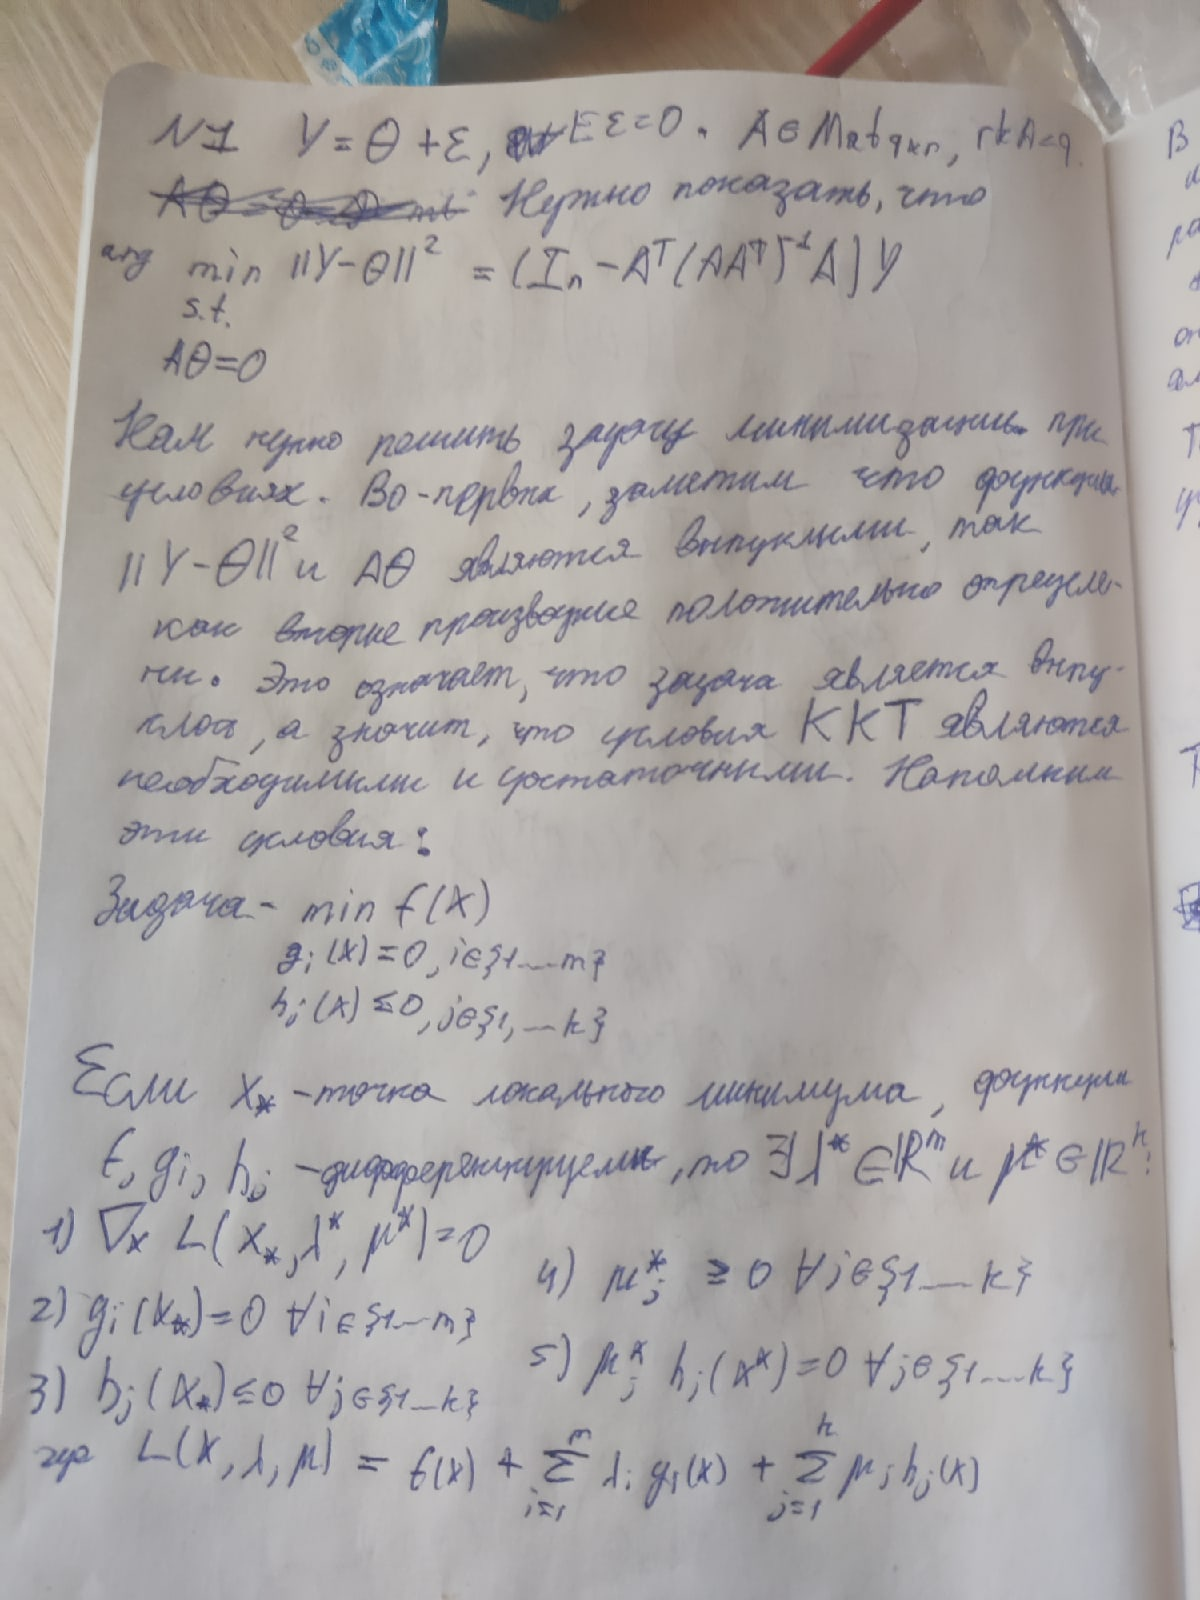

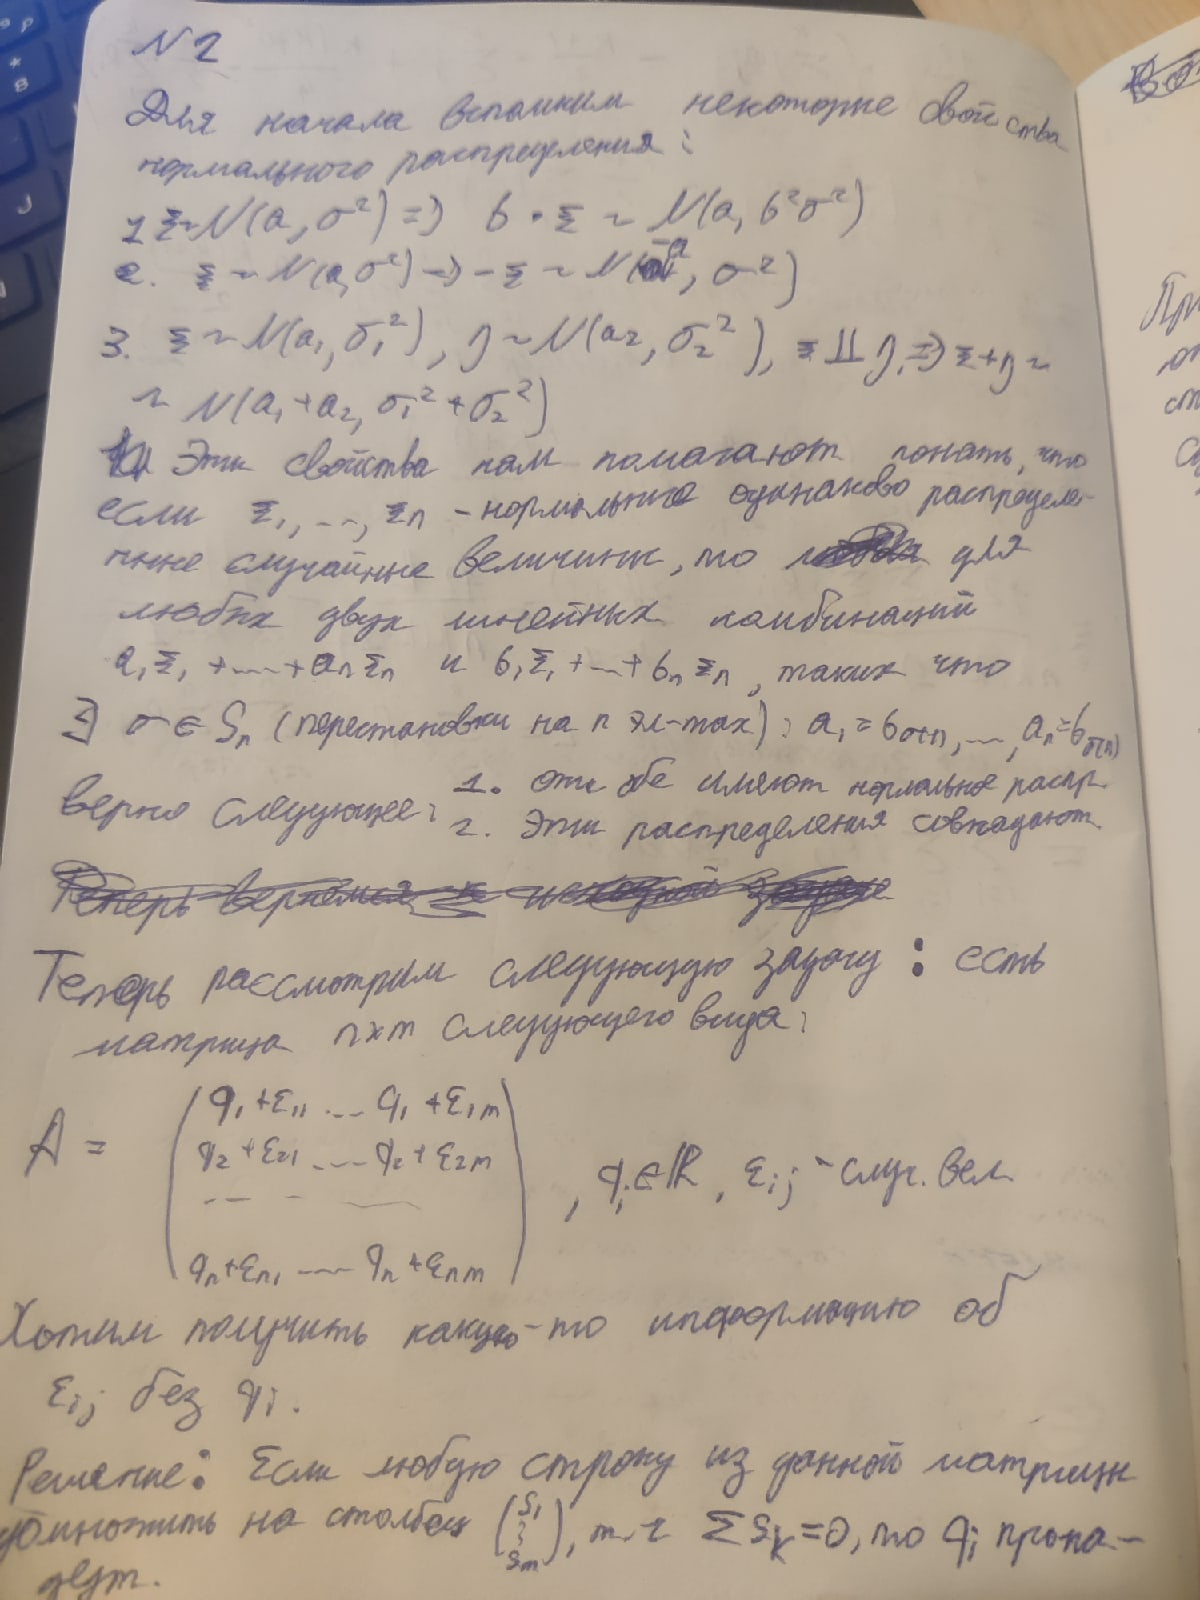

### Задача 2

Считаем данные.

In [398]:
all_data = pd.read_csv('data/msps2018-hw9-2/Prostate_train.csv')

In [298]:
all_data

id    lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45  \
0    1 -0.579818  2.769459   50 -1.386294    0 -1.386294        6      0   
1    2 -0.994252  3.319626   58 -1.386294    0 -1.386294        6      0   
2    3 -0.510826  2.691243   74 -1.386294    0 -1.386294        7     20   
3    4 -1.203973  3.282789   58 -1.386294    0 -1.386294        6      0   
4    5  0.751416  3.432373   62 -1.386294    0 -1.386294        6      0   
..  ..       ...       ...  ...       ...  ...       ...      ...    ...   
92  93  2.830268  3.876396   68 -1.386294    1  1.321756        7     60   
93  94  3.821004  3.896909   44 -1.386294    1  2.169054        7     40   
94  95  2.907447  3.396185   52 -1.386294    1  2.463853        7     10   
95  96  2.882564  3.773910   68  1.558145    1  1.558145        7     80   
96  97  3.471966  3.974998   68  0.438255    1  2.904165        7     20   

        lpsa  
0  -0.430783  
1  -0.162519  
2  -0.162519  
3  -0.162519  
4   0.371564  
..       ...  
92  4.385147  
93  4.684443  
94       NaN  
95  5.477509  
96       NaN  

[97 rows x 10 columns]

In [299]:
all_data.isna().any()

id         False
lcavol     False
lweight    False
age        False
lbph       False
svi        False
lcp        False
gleason    False
pgg45      False
lpsa        True
dtype: bool

Пропуски есть только в таргете. Очевидно, их нужно убрать для обучения.

In [300]:
all_X = all_data.drop(['lpsa'], axis = 1)

In [301]:
data = all_data.dropna()

In [302]:
X, y = data.drop(['lpsa'], axis = 1), data['lpsa']

In [303]:
X.shape, y.shape

((68, 9), (68,))

In [304]:
X

id    lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45
0    1 -0.579818  2.769459   50 -1.386294    0 -1.386294        6      0
1    2 -0.994252  3.319626   58 -1.386294    0 -1.386294        6      0
2    3 -0.510826  2.691243   74 -1.386294    0 -1.386294        7     20
3    4 -1.203973  3.282789   58 -1.386294    0 -1.386294        6      0
4    5  0.751416  3.432373   62 -1.386294    0 -1.386294        6      0
..  ..       ...       ...  ...       ...  ...       ...      ...    ...
90  91  3.246491  4.101817   68 -1.386294    0 -1.386294        6      0
91  92  2.532903  3.677566   61  1.348073    1 -1.386294        7     15
92  93  2.830268  3.876396   68 -1.386294    1  1.321756        7     60
93  94  3.821004  3.896909   44 -1.386294    1  2.169054        7     40
95  96  2.882564  3.773910   68  1.558145    1  1.558145        7     80

[68 rows x 9 columns]

In [305]:
y

0    -0.430783
1    -0.162519
2    -0.162519
3    -0.162519
4     0.371564
        ...   
90    4.029806
91    4.129551
92    4.385147
93    4.684443
95    5.477509
Name: lpsa, Length: 68, dtype: float64

План такой -- посмотреть, что нам выдаст обычная линейная регрессия, затем применить нормальзацию и проверить, что получится. Это будет оправная точка. Затем произвести отбор признаков по значимости, затем убрать скоррелированные признаки. После этого можно будет еще посмотреть на остатки, возможно модель будет неполна и произвести добавление параметров. 

В Ridge и Lasso моделях у нас есть параметр регуляризации. Для него нужно построить GridSearch. Сделаем для него функцию, а также общую функцию обучения.

Также напишем небольшой пайплайн для нормализации и функцию нахождения Стьюдентизированных остатков.

In [306]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

def make_basic_pipeline(model):
    return Pipeline([
        ("Scaler", StandardScaler()),
        ("Model", model),
    ])

In [307]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning

def find_best_params(model, params_grid, X_train, y_train):
    searcher = GridSearchCV(model,params_grid,scoring='neg_mean_squared_error')
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        searcher.fit(X_train, y_train)

    print("Best parameters:", searcher.best_params_)
    model = searcher.best_estimator_
    return model

In [308]:
def train_and_test_cv(model, parameters, title, X, y, need_grid = False):
    best_model = model
    if need_grid:
        best_model = find_best_params(model,parameters, X, y)
    else:
        best_model.fit(X, y)
    
    r2 = best_model.score(X, y)
    
    print(f'R^2 score  -- ', r2)
    cv_score = cross_val_score(best_model, X, y, scoring='neg_mean_squared_error', cv=4).mean()
    print(f'cv score  -- ', cv_score)
    return r2, cv_score

In [309]:
def find_student_remainders(model, X, y):
    vals = sklearn.preprocessing.normalize(X)
    H = vals.dot(np.linalg.inv(vals.T.dot(vals))).dot(vals.T)
    rss = ((y - model.predict(X))**2).sum()
    std = rss / (vals.shape[0] - vals.shape[1] - 1)
    err = (y.values - model.predict(X)) / np.sqrt(std) / np.sqrt(1 - np.diag(H))
    return err

In [310]:
model =  LinearRegression(fit_intercept=True)
r2_lin, cv_lin = train_and_test_cv(model, None, "Linear", X, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))

R^2 score  --  0.9362463323386865
cv score  --  -0.18862978267790875
R^2 fixed --  0.9263535218395171


In [311]:
model_n =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin_n, cv_lin = train_and_test_cv(model_n, None, "Linear", X, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin_n) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))

R^2 score  --  0.9362463323386865
cv score  --  -0.1886297826779087
R^2 fixed --  0.9263535218395171


Вывод: отличий особых нет. Поэтому далее по дефолту будем нормализировать. Посмотрим на значимость признаков с помощью ExtraTreeRegressor:

In [312]:
forest = ExtraTreesRegressor(n_estimators=100)
forest.fit(X, y)

ExtraTreesRegressor()

In [313]:
forest.feature_importances_

array([0.8899519 , 0.03109058, 0.00826067, 0.00663705, 0.00856633,
       0.04851597, 0.00250738, 0.00098217, 0.00348795])

Тут кажется, что все очевидно. Заметим, что первый признак ('id') имеет очень большую значимость. И если внимательно присмотреться в данные, то таргеты упорядочены согласно id, где пропусков нет. Поэтому видимо нам дали упорядоченную выборку. Что же, видимо здесь наша задача уйдет в 2 стороны, в одной из которых мы будем отталкиваться от того, что id -- главный значащий признак и все остальные имеют небольшой вклад (и задача переходит в разряд восстановите утерянные данные в таблице), а в другой -- мы избавимся от id в предположении того, что id не имеет значения и нам просто решили дать посорченный сет.

В первом случае заметим, что у нас есть еще 2 относительно значащих признака -- второй и пятый. Поэтому если оставить количество признаков, равных 3, то возможно получим хороший результат. Проверим это:

In [314]:
k = X.shape[1]
print(k)

for features_count in range(1, k + 1):
    print('------------------------------------------------------')
    print('features number -- ', features_count)
    tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100), n_features_to_select=features_count, step=1)
    X_rfe = tree.fit_transform(X, y)
    model = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
    r2, cv = train_and_test_cv(model, None, "Linear", X_rfe, y, False)
    print(f"R^2 fixed -- ", 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - features_count - 1))
    print('------------------------------------------------------')

9
------------------------------------------------------
features number --  1
R^2 score  --  0.9244373820538764
cv score  --  -0.14585430255913734
R^2 fixed --  0.9232924939031776
------------------------------------------------------
------------------------------------------------------
features number --  2
R^2 score  --  0.9249334496439716
cv score  --  -0.15918165224664071
R^2 fixed --  0.9226237096330169
------------------------------------------------------
------------------------------------------------------
features number --  3
R^2 score  --  0.9301173509865577
cv score  --  -0.15706109432703336
R^2 fixed --  0.9268416018140526
------------------------------------------------------
------------------------------------------------------
features number --  4
R^2 score  --  0.9325561963626804
cv score  --  -0.16034747393902277
R^2 fixed --  0.9282740500999934
------------------------------------------------------
------------------------------------------------------
feature

Как видим, лучший cv_score выдало на 1, а $R^2$ -- на четырех фичах,  причем R2 стал чуть-чуть (совсем незначительно) лучше, чем на обычной линейной модели. 

In [315]:
tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100), n_features_to_select=3, step=1)
X_rfe = tree.fit_transform(X, y)
model_rfe = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
train_and_test_cv(model_rfe, None, "Linear", X_rfe, y, False)
X_all_rfe = tree.transform(all_X)
X_all_rfe = all_X[all_X.columns[tree.support_]]

R^2 score  --  0.9301173509865577
cv score  --  -0.15706109432703336


In [316]:
X_rfe = X[X.columns[tree.support_]]

Посмотрим на распределение остатков.

In [317]:
err = find_student_remainders(model_rfe, X_rfe, y) 

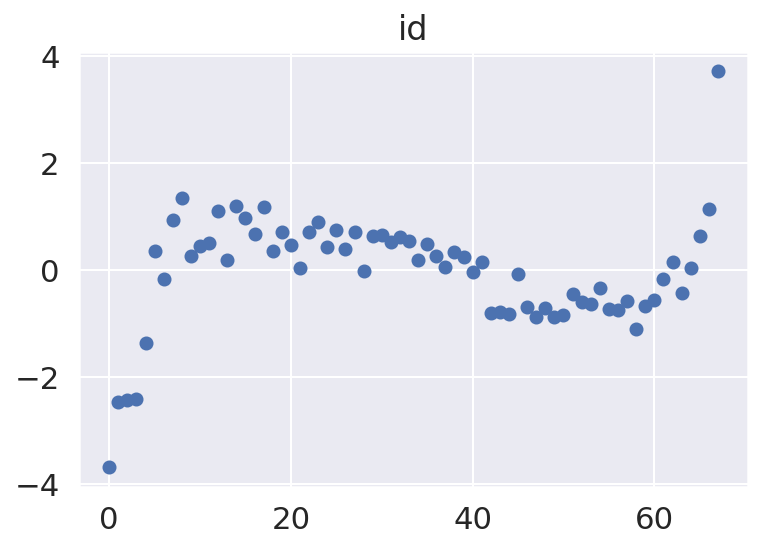

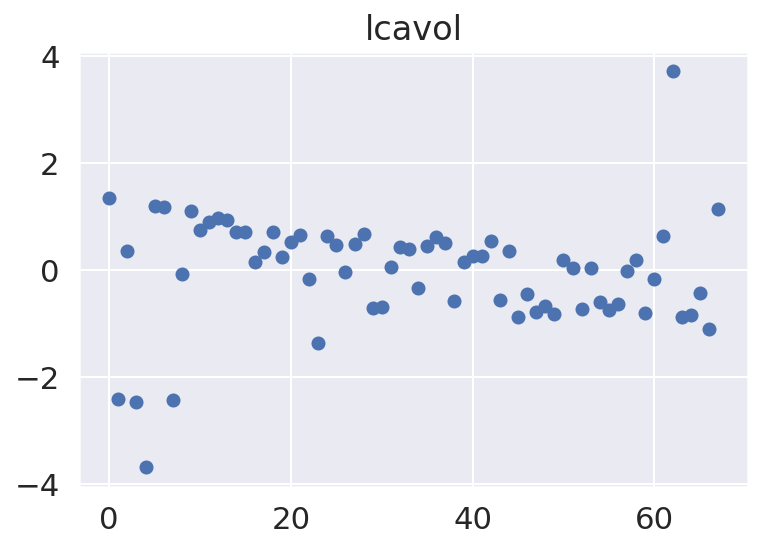

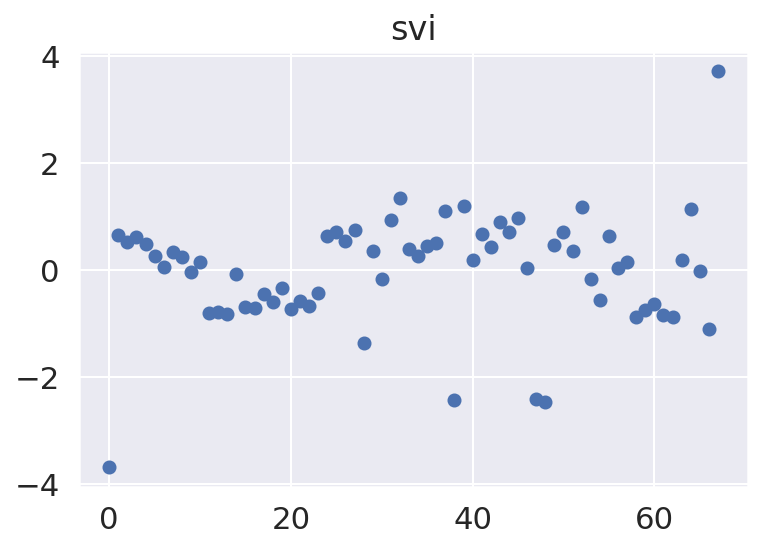

In [318]:
for i in range(X_rfe.shape[1]):
    plt.figure()
    plt.plot(err[X_rfe.values[:, i].argsort()], 'o')
    plt.title(X_rfe.columns[i])

Видно, что есть определенный тренд от id. Зависимость сложная, но имеется всего 2 перегиба, кажется эта зависимость должна описываться многочленом, причем число различных одночленов равно 3. Построим сетку и найдем лучшие степени для cv_score.

In [319]:
%%capture

best_z = None
best_f = None
best_s = None
cur_m = -5

zero = np.linspace(0, 1, 10)
first = np.linspace(1, 3, 21)
second = np.linspace(5, 7, 21)
for z in zero:
    for f in first:
        for s in second:
            X_rfe_mod = X_rfe.copy()
            X_rfe_mod['id0'] = X_rfe_mod['id'].values ** z
            X_rfe_mod['id2'] = X_rfe_mod['id'].values ** f
            X_rfe_mod['id3'] = X_rfe_mod['id'].values ** s
            X_rfe_mod = X_rfe_mod.drop(['id'], axis = 1)
            model_rfe_3 = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
            _, cv = train_and_test_cv(model_rfe_3, None, "Linear", X_rfe_mod, y, False)
            if cv > cur_m:
                cur_m = cv
                best_z = z
                best_f = f
                best_s = s
            

In [320]:
cur_m

-0.10106886424462043

In [321]:
X_rfe_mod = X_rfe.copy()
X_rfe_mod['id0'] = X_rfe_mod['id'].values ** best_z
X_rfe_mod['id2'] = X_rfe_mod['id'].values ** best_f
X_rfe_mod['id3'] = X_rfe_mod['id'].values ** best_s
X_rfe_mod = X_rfe_mod.drop(['id'], axis = 1)
model_rfe_3 = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
train_and_test_cv(model_rfe_3, None, "Linear", X_rfe_mod, y, False)
best_z, best_f, best_s

R^2 score  --  0.9868436375039928
cv score  --  -0.10106886424462043


(0.3333333333333333, 3.0, 7.0)

In [322]:
all_X_mod = X_all_rfe.copy()
all_X_mod['id0'] = all_X_mod['id'].values ** best_z
all_X_mod['id2'] = all_X_mod['id'].values ** best_f
all_X_mod['id3'] = all_X_mod['id'].values ** best_s
all_X_mod = all_X_mod.drop(['id'], axis = 1)
res = model_rfe_3.predict(all_X_mod)
res_fr = pd.DataFrame({'id' : all_X['id'].values, 'lpsa': res})
res_fr.to_csv("polynom3.csv", index = False)

Теперь положим, что id не имеет значение. Удалим 'id', не будем отталкиваться от него. Посмотрим сначала на то, что выдаст обычная линейная модель, затем на важности фич.

In [323]:
X_new = X.drop(['id'], axis = 1)

In [324]:
model_n =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2, cv = train_and_test_cv(model_n, None, "Linear", X_new, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_new.shape[0] - 1) / (X_new.shape[0] - X_new.shape[1] - 1))

R^2 score  --  0.6822017443997477
cv score  --  -1.319879043039944
R^2 fixed --  0.6391104555047982


In [325]:
forest = ExtraTreesRegressor(n_estimators=100, random_state = 1)
forest.fit(X_new, y)

ExtraTreesRegressor(random_state=1)

In [326]:
forest.feature_importances_

array([0.29923699, 0.12888028, 0.06974614, 0.13395182, 0.25512058,
       0.03349835, 0.03640976, 0.04315609])

Как видим,  четыре признака наименее значимы (с theshold в 0.1, значимость меньше больше чем в почти 2 раза), скорее всего их можно выкинуть. Посмотрим, что скажет cv_score и $R^2$:

In [327]:
k = X_new.shape[1]
print(k)

for features_count in range(1, k + 1):
    print('------------------------------------------------------')
    print('features number -- ', features_count)
    tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100, 
                                             random_state = 1), n_features_to_select=features_count, step=1)
    X_rfe = tree.fit_transform(X_new, y)
    model = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
    r2, cv = train_and_test_cv(model, None, "Linear", X_rfe, y, False)
    print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_new.shape[0] - 1) / (X_new.shape[0] - features_count - 1))
    print('------------------------------------------------------')

8
------------------------------------------------------
features number --  1
R^2 score  --  0.537126311188026
cv score  --  -1.196772563336003
R^2 fixed --  0.5301130734787537
------------------------------------------------------
------------------------------------------------------
features number --  2
R^2 score  --  0.5989179530180537
cv score  --  -1.1517155910421066
R^2 fixed --  0.5865769669570707
------------------------------------------------------
------------------------------------------------------
features number --  3
R^2 score  --  0.6216120460289243
cv score  --  -1.2416036116022595
R^2 fixed --  0.6038751106865301
------------------------------------------------------
------------------------------------------------------
features number --  4
R^2 score  --  0.6488935506507885
cv score  --  -1.2318114649869552
R^2 fixed --  0.6266010776762354
------------------------------------------------------
------------------------------------------------------
features numb

Как можем заметить, привиденный коэффициент детерминации падает, а cv_score нестабилен. Таким образом, признаки не отбрасываем.

Теперь посмотрим на коррелируемость (какие признаки возможно описываются другими).

In [328]:
import statsmodels
import statsmodels.stats
import statsmodels.stats.outliers_influence
import statsmodels.stats.outliers_influence
import statsmodels.stats.outliers_influence
import statsmodels.stats.diagnostic

In [329]:
[statsmodels.stats.outliers_influence.variance_inflation_factor(X_new, i) for i in range(X_new.shape[1])]

[4.689972209207753,
 47.70563264414068,
 96.5694686372998,
 1.2532632017015308,
 2.621805119829915,
 3.2367895349963844,
 103.55605902605107,
 4.5511821158410655]

У 1,2 и 5 признака VIF большой, значит их можно попробовать исключить. Так и сделаем.

In [330]:
X_new.head()

lcavol   lweight  age      lbph  svi       lcp  gleason  pgg45
0 -0.579818  2.769459   50 -1.386294    0 -1.386294        6      0
1 -0.994252  3.319626   58 -1.386294    0 -1.386294        6      0
2 -0.510826  2.691243   74 -1.386294    0 -1.386294        7     20
3 -1.203973  3.282789   58 -1.386294    0 -1.386294        6      0
4  0.751416  3.432373   62 -1.386294    0 -1.386294        6      0

In [331]:
X_del = X_new.drop(X_new.columns[[1, 2,6 ]], axis=1)
columns = X_del.columns
X_del.head()

lcavol      lbph  svi       lcp  pgg45
0 -0.579818 -1.386294    0 -1.386294      0
1 -0.994252 -1.386294    0 -1.386294      0
2 -0.510826 -1.386294    0 -1.386294     20
3 -1.203973 -1.386294    0 -1.386294      0
4  0.751416 -1.386294    0 -1.386294      0

In [332]:
model_fixed = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
r2, cv = train_and_test_cv(model_fixed, None, "Linear", X_del, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_del.shape[0] - 1) / (X_del.shape[0] - X_del.shape[1] - 1))

R^2 score  --  0.648047308214864
cv score  --  -1.1830601292164256
R^2 fixed --  0.6196640266192885


Как видим, привиденный коэффициент детерминации  стал хуже, хотя cv_score стал сильно приятнее. Удалим коррелируемые признаки.

Теперь посмотрим на распределение остатков:

In [333]:
err = find_student_remainders(model_fixed, X_del, y)

Text(0.5, 1.0, 'Распределение стьюдентизированных остатков')

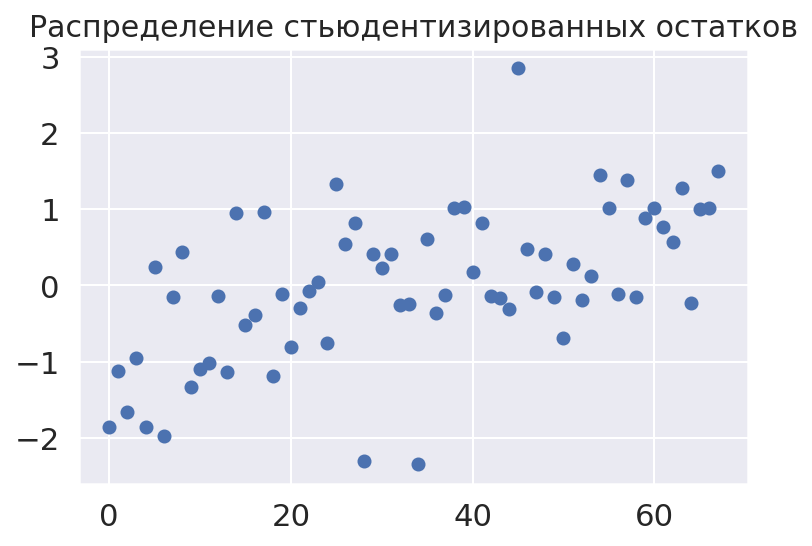

In [334]:
plt.plot(err, 'o')
plt.title("Распределение стьюдентизированных остатков", fontsize=15)

Как видим, распредление остатков имеет тренд и кажется, что есть зависимость от времени. Но это мы уже проверяли -- 'id' отвечал за время, и да действительно тренд есть, мы его просто исключили из рассмотрения в данный момент.

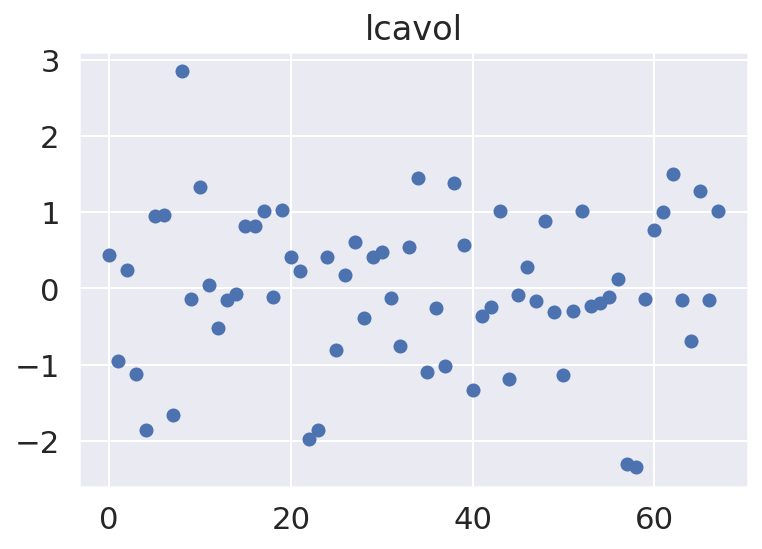

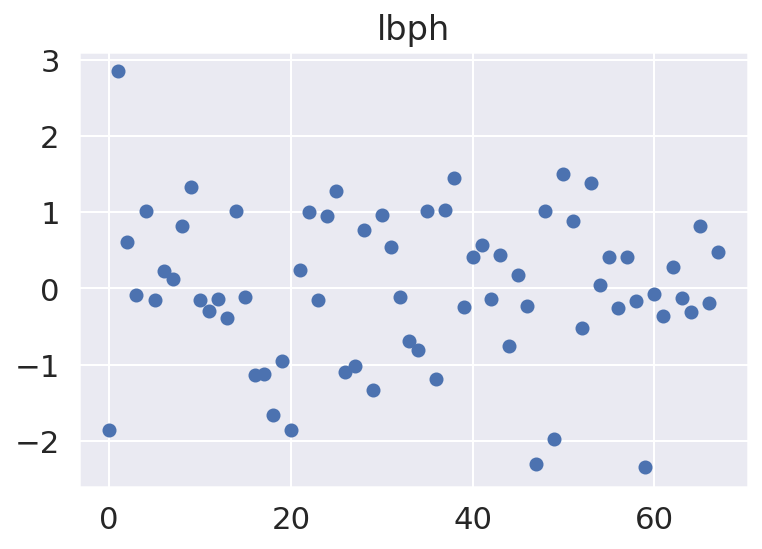

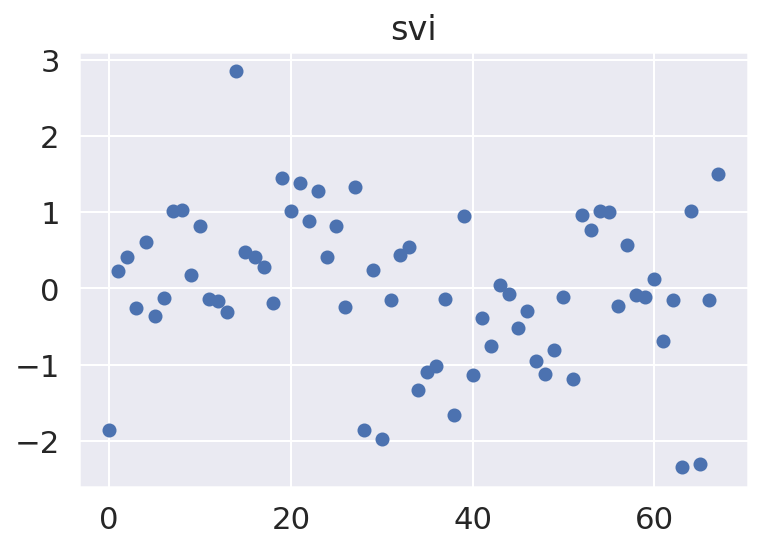

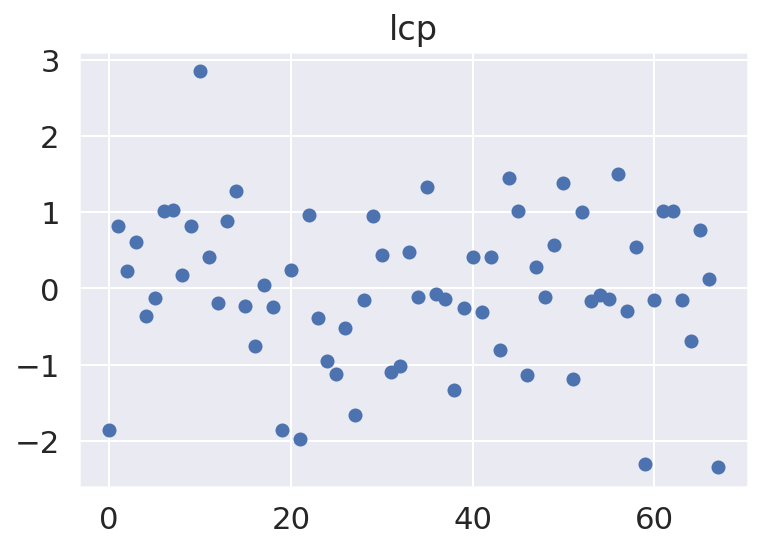

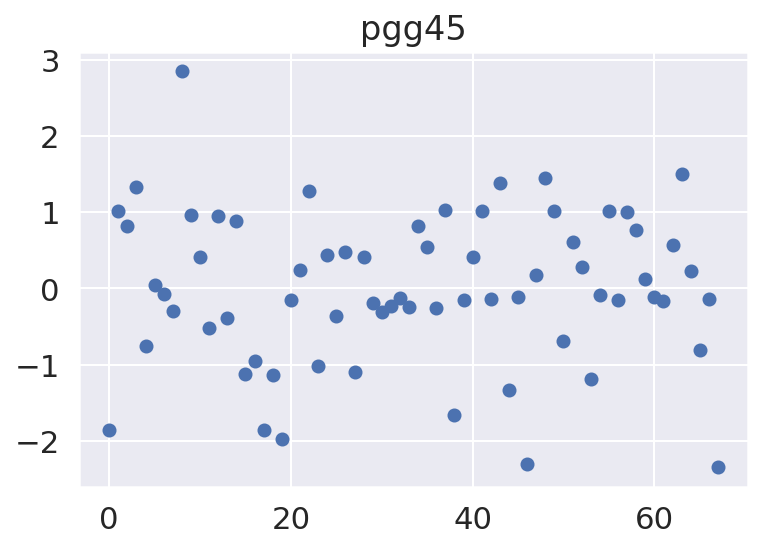

In [335]:
for i in range(X_del.shape[1]):
    plt.figure()
    plt.plot(err[X_del.values[:, i].argsort()], 'o')
    plt.title(X_del.columns[i])

Каких-то явных зависимостей не видно. 

 Попробуем преобразование Бокса-Кокса.

In [336]:
import sklearn

In [337]:
X_boxcox = np.array([
    sps.boxcox((X_del.values - X_del.values.min(axis=0) + 0.001)[:, i])[0] for i in range(X_del.shape[1])
]).T

In [338]:
model = LinearRegression(fit_intercept=True)
r2, cv = train_and_test_cv(model, None, "Linear", X_boxcox, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_boxcox.shape[0] - 1) / (X_boxcox.shape[0] - X_boxcox.shape[1] - 1))

R^2 score  --  0.6351407800796496
cv score  --  -1.280107328453839
R^2 fixed --  0.6057166494409116


Стало хуже. Попробуем понормализировать перед преобразованием.

In [339]:
X_norm = sklearn.preprocessing.normalize(X_del.values, axis = 0)
X_boxcox = np.array([
    sps.boxcox((X_norm - X_norm.min(axis=0) + 0.001)[:, i])[0] for i in range(X_norm.shape[1])
]).T

In [340]:
model = LinearRegression(fit_intercept=True)
r2, cv = train_and_test_cv(model, None, "Linear", X_boxcox, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_boxcox.shape[0] - 1) / (X_boxcox.shape[0] - X_boxcox.shape[1] - 1))

R^2 score  --  0.637907057687294
cv score  --  -1.2711654292361556
R^2 fixed --  0.6087060139523984


Все равно осталось хуже, чем до преобразования.

Попробуем попользоваться нормализацией. Для этого будем использовать уже подготовленные ранее функции с grid_search.

In [341]:
parameters = {'Model__alpha': np.append(np.arange(0.2, 20.1, 0.05), np.logspace(-6, -3, 4))}
model = make_basic_pipeline(Ridge(fit_intercept=True)) 
r2, cv = train_and_test_cv(model, parameters, "Ridge", X_del, y, True)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_del.shape[0] - 1) / (X_del.shape[0] - X_del.shape[1] - 1))

Best parameters: {'Model__alpha': 1e-06}
R^2 score  --  0.6480473082148637
cv score  --  -1.1830601450829468
R^2 fixed --  0.6196640266192881


In [342]:
parameters = {'Model__alpha': np.append(np.arange(0.01, 3, 0.01), np.logspace(-6, -3, 4))}
model = make_basic_pipeline(Lasso(fit_intercept=True)) 
r2, cv = train_and_test_cv(model, parameters, "Lasso", X_del, y, True)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_del.shape[0] - 1) / (X_del.shape[0] - X_del.shape[1] - 1))

Best parameters: {'Model__alpha': 1e-06}
R^2 score  --  0.6480473082047
cv score  --  -1.1830641827611736
R^2 fixed --  0.6196640266083049


Как видим, регуляризация также не принесла плодов. Таким образом, используем обычную линейную регрессию с нормализацией и отбросом признаков 1, 2 и 7.

In [343]:
#сейв данной модели для высылки

all_X_del = all_X[columns]
res = model_fixed.predict(all_X_del)
res_fr = pd.DataFrame({'id' : all_X['id'].values, 'lpsa': res})
res_fr.to_csv("second.csv", index = False)

**Замечание:** В kaggle засланы другие данные. Данные, отправленые в архиве, обучены как раз на модели с отброшенным id и далее с отборошенными признаками.

### Задача 3

In [399]:
all_data = pd.read_csv('data/msps2018-hw9-3/hw9t3_train.csv')

In [400]:
all_data

id  Fadeev  Khaldeev  Pepermaldeev  kees  top hat  turtle  gloves  \
0      0       1         1             1     0        0       0       1   
1      1       0         1             1     1        1       1       1   
2      2       0         0             1     1        1       1       1   
3      3       1         1             1     1        1       1       1   
4      4       0         1             1     1        1       1       0   
..   ...     ...       ...           ...   ...      ...     ...     ...   
495  495       0         0             1     1        0       1       1   
496  496       0         1             1     0        1       0       1   
497  497       1         0             1     1        0       1       0   
498  498       0         0             1     0        1       0       0   
499  499       0         1             1     1        1       0       0   

     small cart  cardboard  ...  elefant  zeta function  Alla Pugachyova  \
0             1          1  ...        0              1                1   
1             1          0  ...        0              0                0   
2             1          0  ...        0              0                0   
3             1          1  ...        1              0                0   
4             0          0  ...        0              0                0   
..          ...        ...  ...      ...            ...              ...   
495           0          0  ...        0              1                0   
496           0          0  ...        1              1                0   
497           0          1  ...        1              1                0   
498           0          0  ...        0              0                0   
499           1          0  ...        0              0                0   

     soldering iron  frypan  drums  yellow submarine     sleep       mood  \
0                 0       0      0                 1  3.418333  frivolous   
1                 1       1      0                 1  3.080932  frivolous   
2                 0       0      1                 1  3.229007      so-so   
3                 1       1      1                 0  2.513620  emotional   
4                 1       0      0                 1  3.270901  excellent   
..              ...     ...    ...               ...       ...        ...   
495               1       0      1                 1  3.246401    apathic   
496               0       0      1                 1  3.679052  frivolous   
497               0       1      1                 1  2.970870  frivolous   
498               0       0      1                 0  3.111193       good   
499               0       0      0                 1  3.137531  frivolous   

      duration  
0    11.851099  
1          NaN  
2     3.751619  
3     9.366979  
4          NaN  
..         ...  
495   7.854242  
496   6.641359  
497   7.629977  
498   1.152128  
499   5.649038  

[500 rows x 38 columns]

In [401]:
all_data.isna().any()

id                  False
Fadeev              False
Khaldeev            False
Pepermaldeev        False
kees                False
top hat             False
turtle              False
gloves              False
small cart          False
cardboard           False
brush               False
toothpaste          False
watch               False
table               False
flute               False
tallboy             False
drill               False
monkey              False
apple               False
irunine             False
gel                 False
rocket              False
rabbit              False
grand piano         False
whistle             False
Coca-cola           False
Stanley cup         False
desk                False
elefant             False
zeta function       False
Alla Pugachyova     False
soldering iron      False
frypan              False
drums               False
yellow submarine    False
sleep               False
mood                False
duration             True
dtype: bool

Как видим, не все признаки у нас численны. Признак 'mood' -- строковый. Закодируем его с помощью mean_target_encoding.

In [402]:
def mean_target_encoding(df, target, column):
    mean_enc = df.groupby(column)[target].mean()
    df[column + '_m_enc'] = df[column].map(mean_enc)
    return (df)

In [403]:
data_tr = mean_target_encoding(all_data, 'duration', 'mood')

In [404]:
data_tr

id  Fadeev  Khaldeev  Pepermaldeev  kees  top hat  turtle  gloves  \
0      0       1         1             1     0        0       0       1   
1      1       0         1             1     1        1       1       1   
2      2       0         0             1     1        1       1       1   
3      3       1         1             1     1        1       1       1   
4      4       0         1             1     1        1       1       0   
..   ...     ...       ...           ...   ...      ...     ...     ...   
495  495       0         0             1     1        0       1       1   
496  496       0         1             1     0        1       0       1   
497  497       1         0             1     1        0       1       0   
498  498       0         0             1     0        1       0       0   
499  499       0         1             1     1        1       0       0   

     small cart  cardboard  ...  zeta function  Alla Pugachyova  \
0             1          1  ...              1                1   
1             1          0  ...              0                0   
2             1          0  ...              0                0   
3             1          1  ...              0                0   
4             0          0  ...              0                0   
..          ...        ...  ...            ...              ...   
495           0          0  ...              1                0   
496           0          0  ...              1                0   
497           0          1  ...              1                0   
498           0          0  ...              0                0   
499           1          0  ...              0                0   

     soldering iron  frypan  drums  yellow submarine     sleep       mood  \
0                 0       0      0                 1  3.418333  frivolous   
1                 1       1      0                 1  3.080932  frivolous   
2                 0       0      1                 1  3.229007      so-so   
3                 1       1      1                 0  2.513620  emotional   
4                 1       0      0                 1  3.270901  excellent   
..              ...     ...    ...               ...       ...        ...   
495               1       0      1                 1  3.246401    apathic   
496               0       0      1                 1  3.679052  frivolous   
497               0       1      1                 1  2.970870  frivolous   
498               0       0      1                 0  3.111193       good   
499               0       0      0                 1  3.137531  frivolous   

      duration  mood_m_enc  
0    11.851099    6.714133  
1          NaN    6.714133  
2     3.751619    5.829616  
3     9.366979    5.393682  
4          NaN    4.609219  
..         ...         ...  
495   7.854242    5.236975  
496   6.641359    6.714133  
497   7.629977    6.714133  
498   1.152128    5.235479  
499   5.649038    6.714133  

[500 rows x 39 columns]

In [405]:
all_X = data_tr.drop(['duration', 'mood'], axis = 1)

In [406]:
data = data_tr.dropna()

In [407]:
X, y = data.drop(['duration', 'mood'], axis = 1), data['duration']

In [408]:
X.shape, y.shape

((378, 37), (378,))

In [409]:
model =  LinearRegression(fit_intercept=True)
r2_lin, cv_lin = train_and_test_cv(model, None, "Linear", X, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))

R^2 score  --  0.9008176918039482
cv score  --  -1.738256929072357
R^2 fixed --  0.8900243229708484


In [410]:
model =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin, cv_lin = train_and_test_cv(model, None, "Linear", X, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))

R^2 score  --  0.9008176918039482
cv score  --  -1.7382569290724232
R^2 fixed --  0.8900243229708484


In [411]:
forest = ExtraTreesRegressor(n_estimators=100)
forest.fit(X, y)

ExtraTreesRegressor()

In [412]:
forest.feature_importances_

array([0.00286005, 0.38297696, 0.1103397 , 0.16602926, 0.00717945,
       0.00118368, 0.07241468, 0.00360557, 0.00099105, 0.00331774,
       0.00115615, 0.00695689, 0.0151071 , 0.02418166, 0.00211443,
       0.00129946, 0.00118238, 0.0100353 , 0.00144464, 0.05677242,
       0.00101481, 0.00228698, 0.0058881 , 0.03277273, 0.00439341,
       0.00262293, 0.00455253, 0.0100699 , 0.00335031, 0.00832424,
       0.00648391, 0.00464989, 0.00165313, 0.00495723, 0.00757829,
       0.00362069, 0.02463237])

In [413]:
k = X.shape[1]
print(k)

cv_scores, r2_fixed_scores = [], []

for features_count in range(1, k + 1):
    tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100, 
                                             random_state = 1), n_features_to_select=features_count, step=1)
    X_rfe = tree.fit_transform(X, y)
    model = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
    r2, cv = train_and_test_cv(model, None, "Linear", X_rfe, y, False)
    cv_scores.append(cv)
    r2_fixed_scores.append(1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - features_count - 1))

37
R^2 score  --  0.38297696080060517
cv score  --  -9.41217872688992
R^2 score  --  0.5383516678665966
cv score  --  -7.078834406169776
R^2 score  --  0.597936063603884
cv score  --  -6.157074322489984
R^2 score  --  0.6748443291318088
cv score  --  -5.0131479159786005
R^2 score  --  0.7018615114545077
cv score  --  -4.619950838686842
R^2 score  --  0.7468593172945461
cv score  --  -3.9609603387210526
R^2 score  --  0.7810903838699038
cv score  --  -3.4473655475532765
R^2 score  --  0.8102961473395768
cv score  --  -2.9920605477367213
R^2 score  --  0.8390729842921256
cv score  --  -2.551191455465748
R^2 score  --  0.8605491638090217
cv score  --  -2.2046425190993295
R^2 score  --  0.8605620887458211
cv score  --  -2.215128969700539
R^2 score  --  0.8608854223392413
cv score  --  -2.2343335611070114
R^2 score  --  0.8609346640628128
cv score  --  -2.2387964786031187
R^2 score  --  0.878791632899588
cv score  --  -1.9651354614864271
R^2 score  --  0.8788273032520251
cv score  --  -1.97

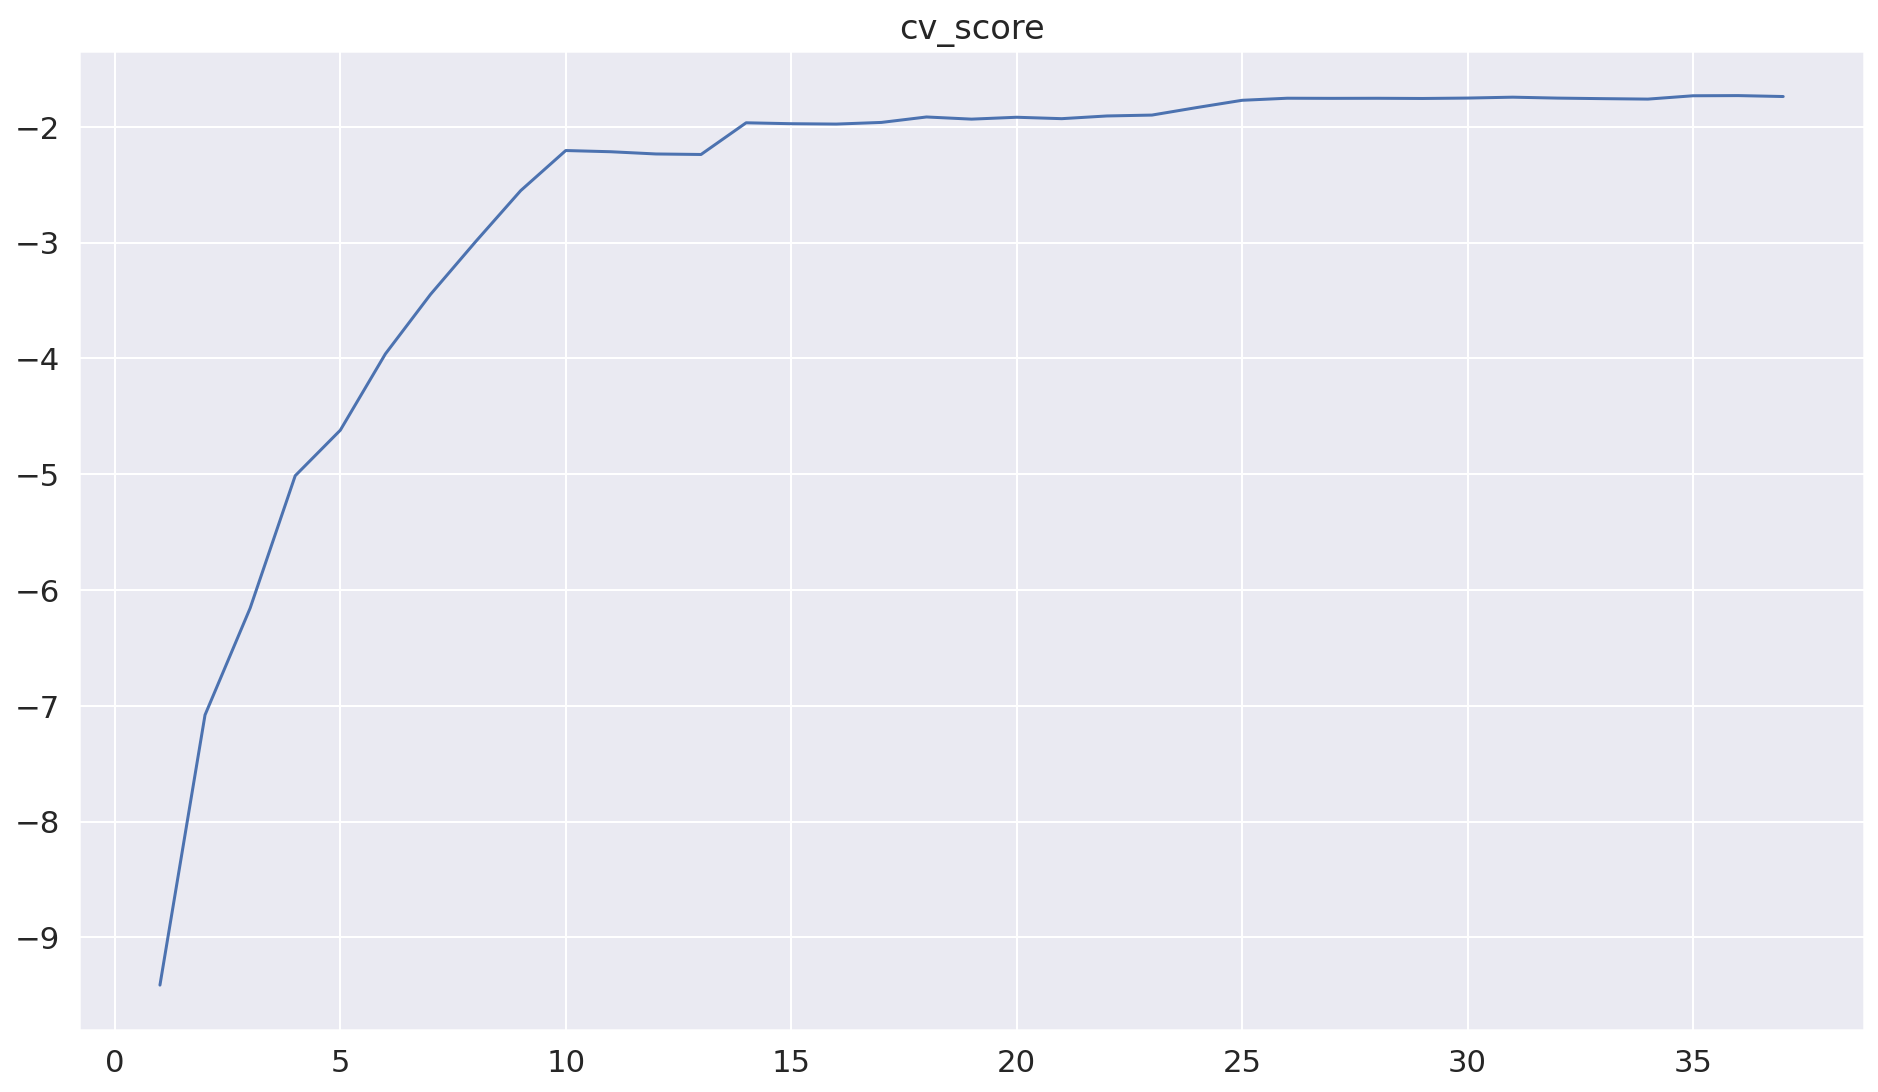

In [414]:
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, k  + 1), cv_scores)
plt.title('cv_score')
plt.show()

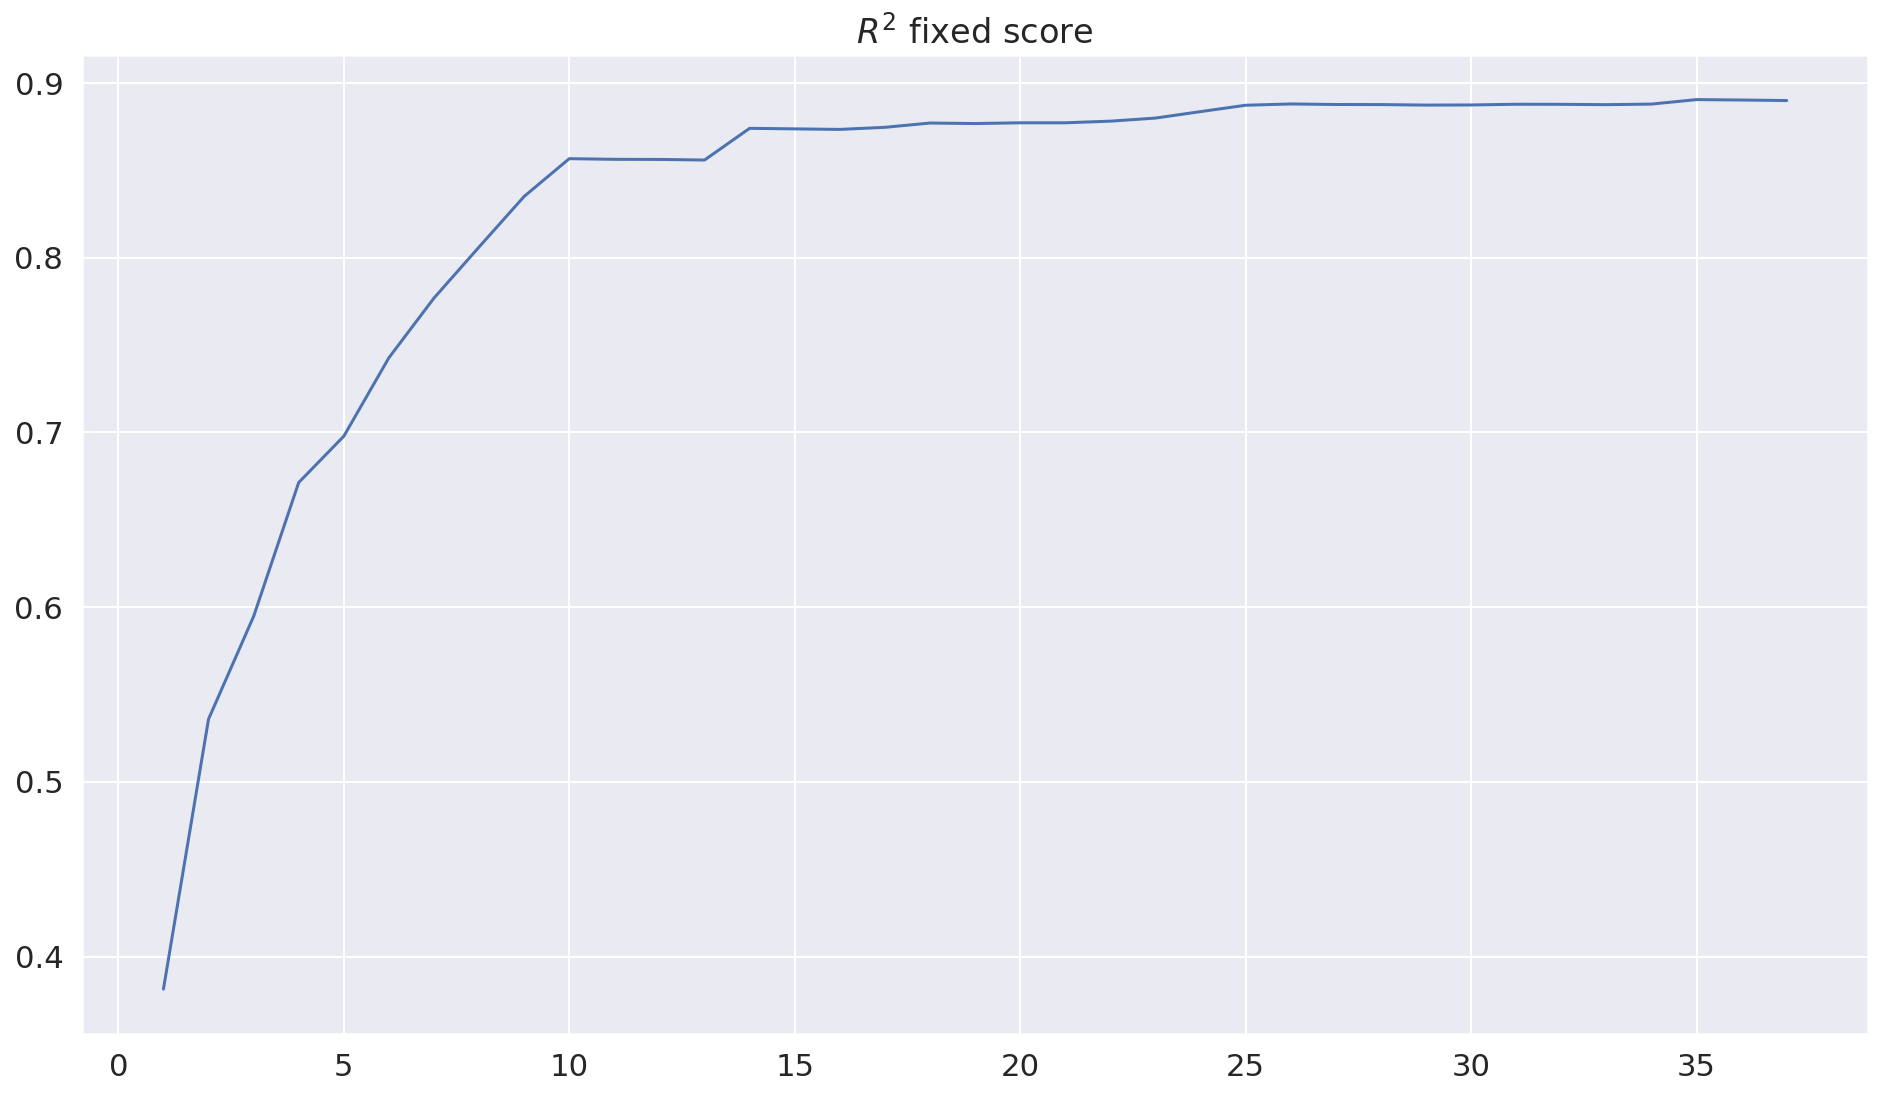

In [415]:
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, k  + 1), r2_fixed_scores)
plt.title(fr'$R^2$ fixed score')
plt.show()

In [416]:
tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100, random_state = 1),n_features_to_select=25,  step=1)
X_mod = tree.fit_transform(X, y)
model_mod = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
r2, cv = train_and_test_cv(model_mod, None, "Linear", X_mod, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_mod.shape[0] - 1) / (X_mod.shape[0] - X_mod.shape[1] - 1))

R^2 score  --  0.8948076492978774
cv score  --  -1.7708342587167987
R^2 fixed --  0.8873366016627835


Как видим, после 25 признаков -- стабильное плато, значит остальные признаки будем отбрасывать.

In [417]:
X_mod = X[X.columns[tree.support_]]

In [418]:
X_mod.head()

Fadeev  Khaldeev  Pepermaldeev  kees  turtle  gloves  cardboard  \
0        1         1             1     0       0       1          1   
2        0         0             1     1       1       1          0   
3        1         1             1     1       1       1          1   
7        0         0             0     0       0       0          1   
10       0         0             0     0       0       0          0   

    toothpaste  watch  table  ...  Stanley cup  desk  elefant  zeta function  \
0            1      1      1  ...            1     1        0              1   
2            0      0      0  ...            0     0        0              0   
3            0      1      0  ...            1     1        1              0   
7            1      1      1  ...            0     0        0              1   
10           0      0      0  ...            0     1        1              1   

    Alla Pugachyova  soldering iron  drums  yellow submarine     sleep  \
0                 1               0      0                 1  3.418333   
2                 0               0      1                 1  3.229007   
3                 0               1      1                 0  2.513620   
7                 1               0      0                 0  3.039107   
10                1               0      1                 0  3.770051   

    mood_m_enc  
0     6.714133  
2     5.829616  
3     5.393682  
7     6.714133  
10    5.236975  

[5 rows x 25 columns]

Теперь посмотрим на скоррелированность.

In [419]:
corr = [statsmodels.stats.outliers_influence.variance_inflation_factor(X_mod, i)
        for i in range(X_mod.shape[1])]
ind = np.argsort(np.array(corr))
corr

[3.308622728621216,
 3.3598924860964225,
 4.846497504305581,
 2.417176968392499,
 1.9787827341945152,
 2.5823770995372626,
 2.1076948664882265,
 2.1401250486003773,
 2.336960876316988,
 2.1254863569546867,
 2.273975751824557,
 2.340117527624487,
 2.1025674621266615,
 1.9045455330499914,
 2.0535894921685753,
 2.1943476048446393,
 2.3870126194287575,
 1.9413208408835079,
 2.1548442947981274,
 2.0956240337687984,
 1.9709767876308133,
 2.3400551276155888,
 2.2793702736849686,
 29.986104311671337,
 31.980332348184564]

In [420]:
X_del = X_mod.drop(X_mod.columns[ind[-2:]], axis=1)
X_del.head()

Fadeev  Khaldeev  Pepermaldeev  kees  turtle  gloves  cardboard  \
0        1         1             1     0       0       1          1   
2        0         0             1     1       1       1          0   
3        1         1             1     1       1       1          1   
7        0         0             0     0       0       0          1   
10       0         0             0     0       0       0          0   

    toothpaste  watch  table  ...  grand piano  whistle  Stanley cup  desk  \
0            1      1      1  ...            1        1            1     1   
2            0      0      0  ...            0        0            0     0   
3            0      1      0  ...            0        0            1     1   
7            1      1      1  ...            1        0            0     0   
10           0      0      0  ...            0        0            0     1   

    elefant  zeta function  Alla Pugachyova  soldering iron  drums  \
0         0              1                1               0      0   
2         0              0                0               0      1   
3         1              0                0               1      1   
7         0              1                1               0      0   
10        1              1                1               0      1   

    yellow submarine  
0                  1  
2                  1  
3                  0  
7                  0  
10                 0  

[5 rows x 23 columns]

In [421]:
model =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin, cv_lin = train_and_test_cv(model, None, "Linear", X_del, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin) * (X_del.shape[0] - 1) / (X_del.shape[0] - X_del.shape[1] - 1))

R^2 score  --  0.8711598055506455
cv score  --  -2.176346643129935
R^2 fixed --  0.8627888324649531


Все стало намного хуже, поэтому не убираем. Теперь будем смотреть на остатки. 

In [422]:
err = find_student_remainders(model_mod, X_mod, y)

Text(0.5, 1.0, 'Распределение стьюдентизированных остатков')

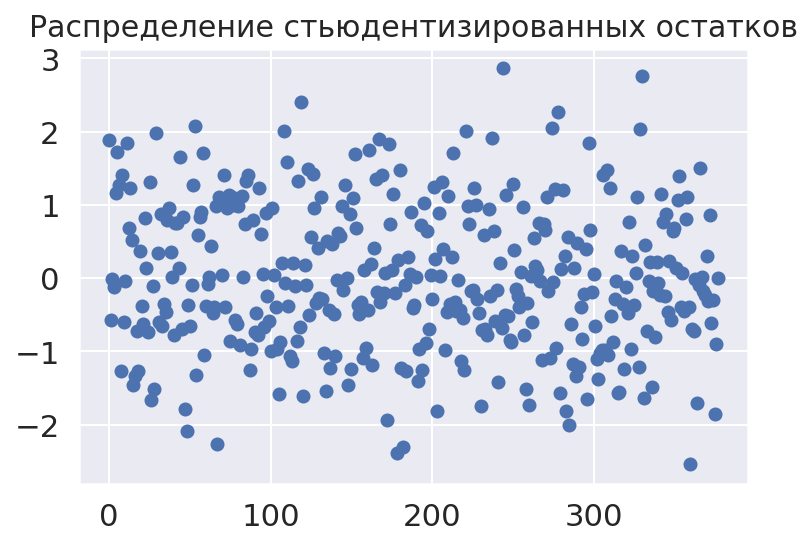

In [423]:
plt.plot(err, 'o')
plt.title("Распределение стьюдентизированных остатков", fontsize=15)

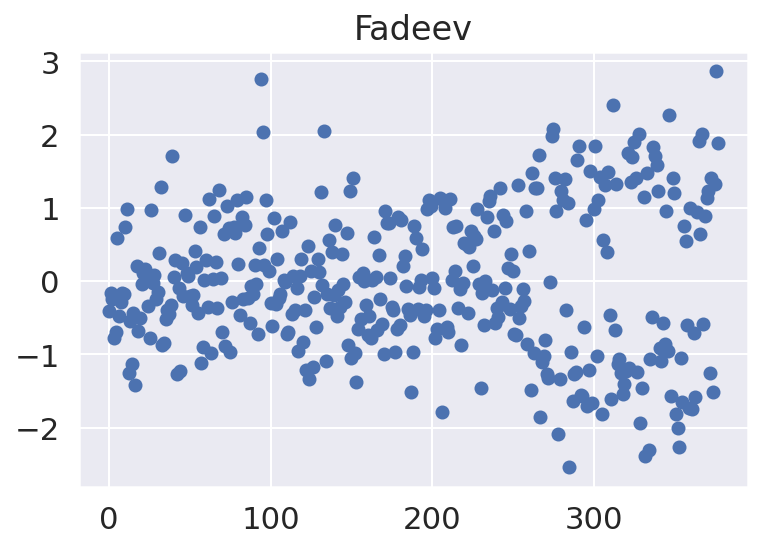

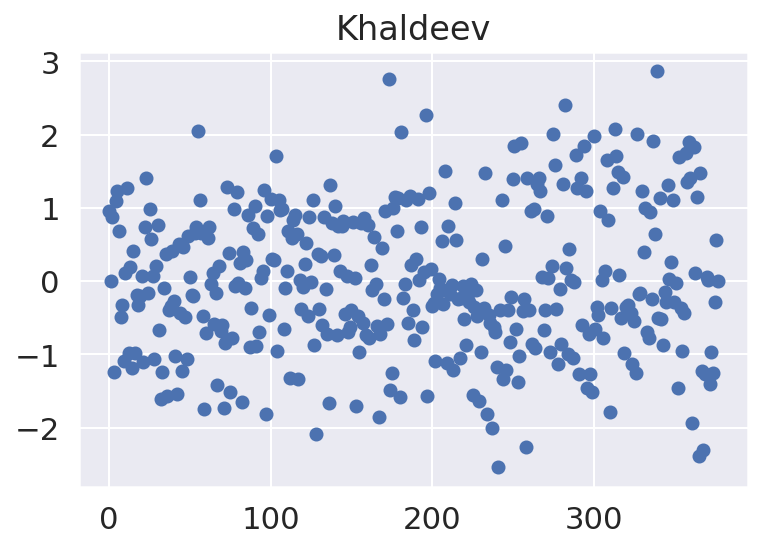

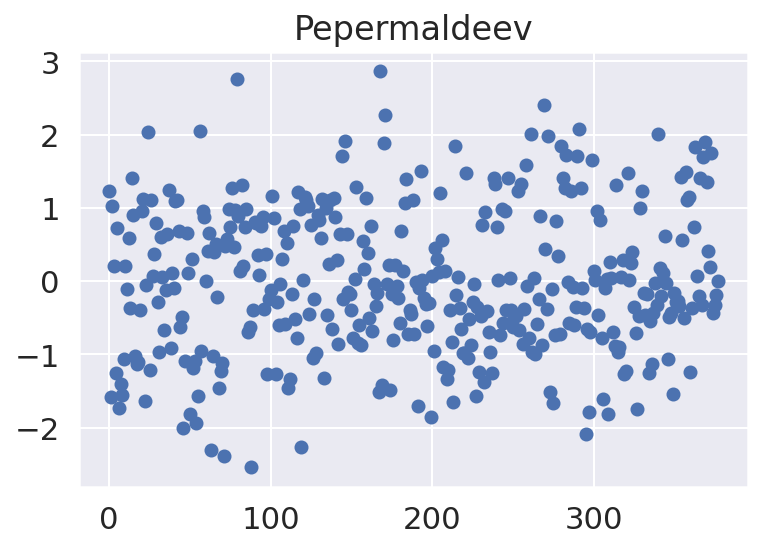

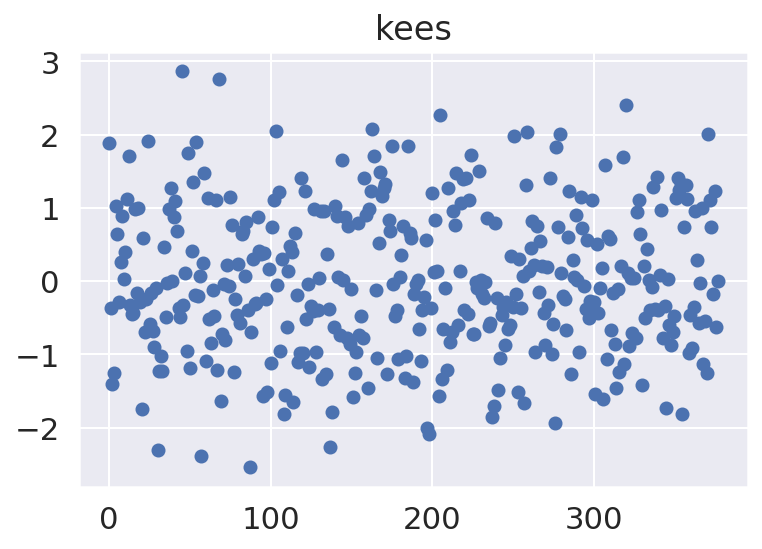

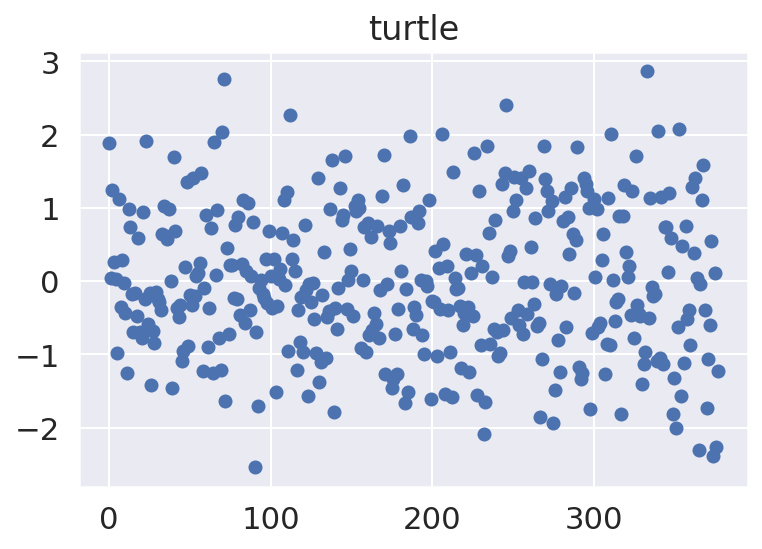

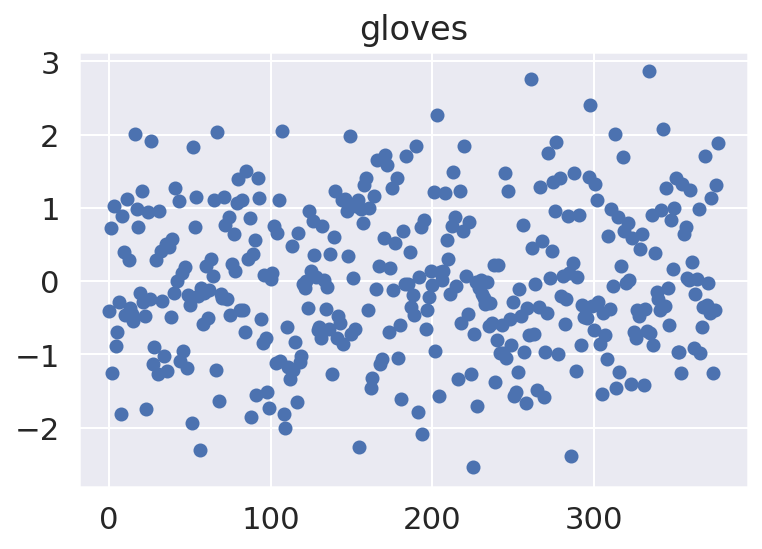

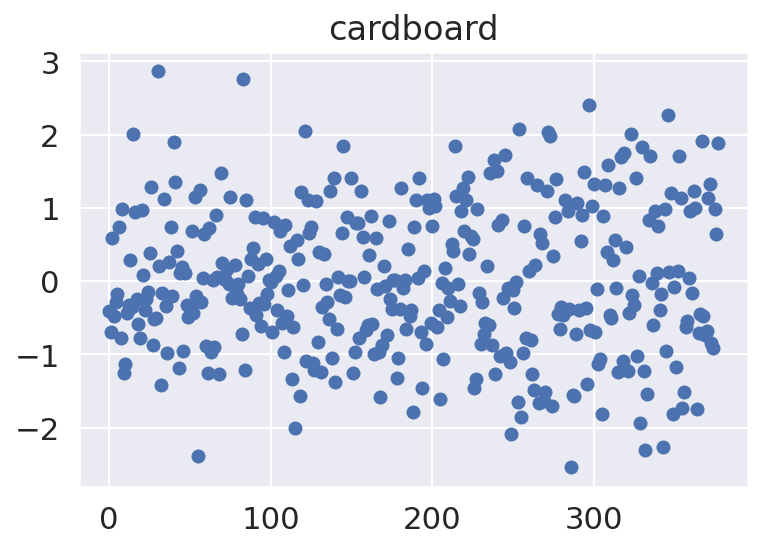

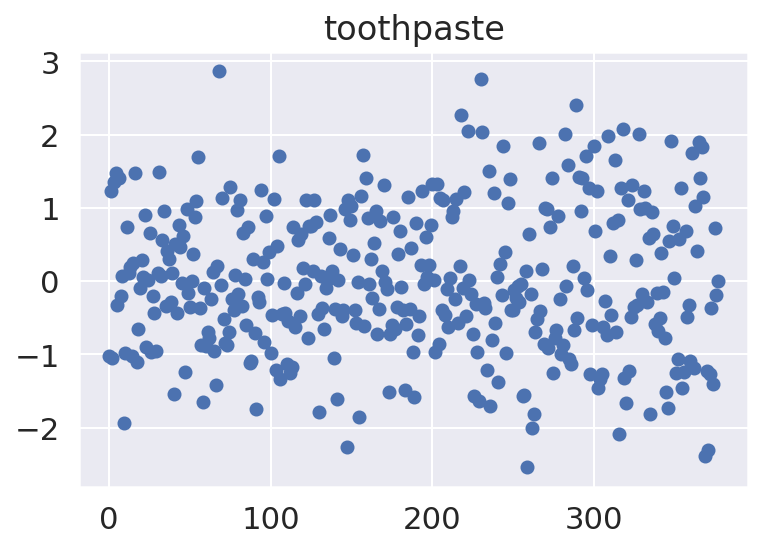

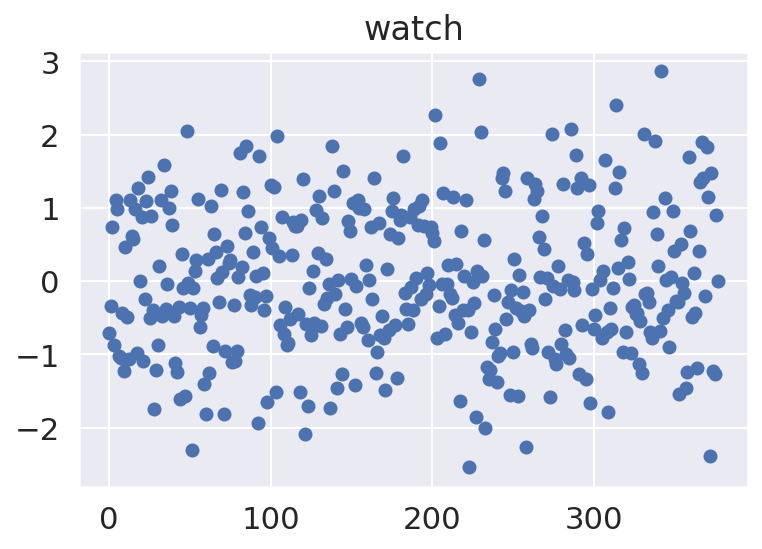

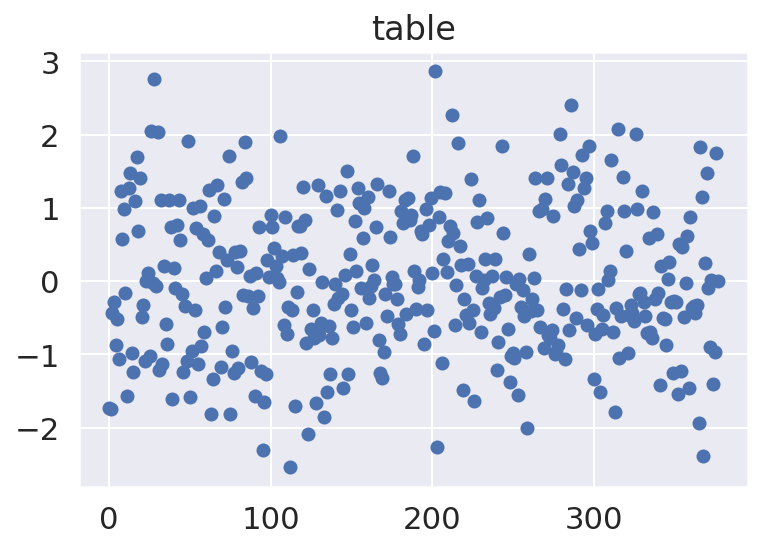

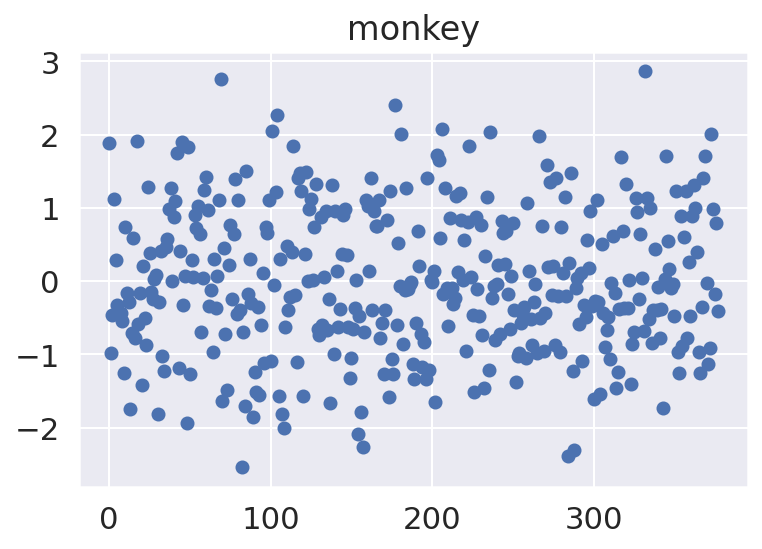

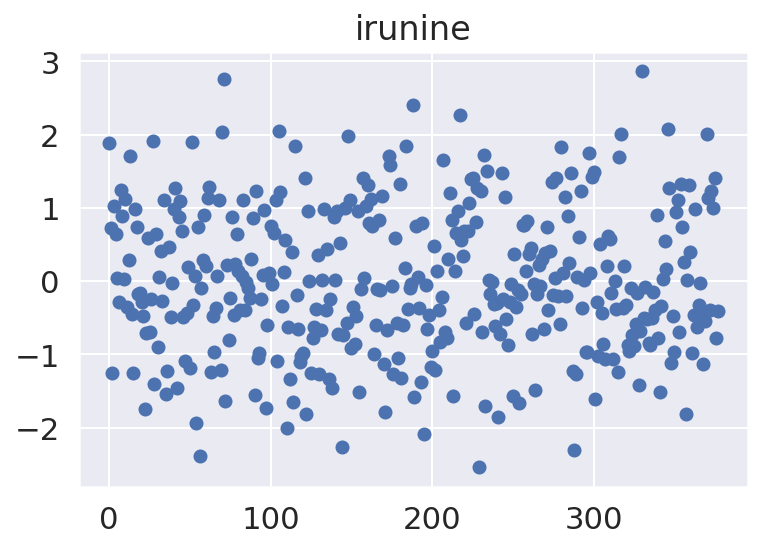

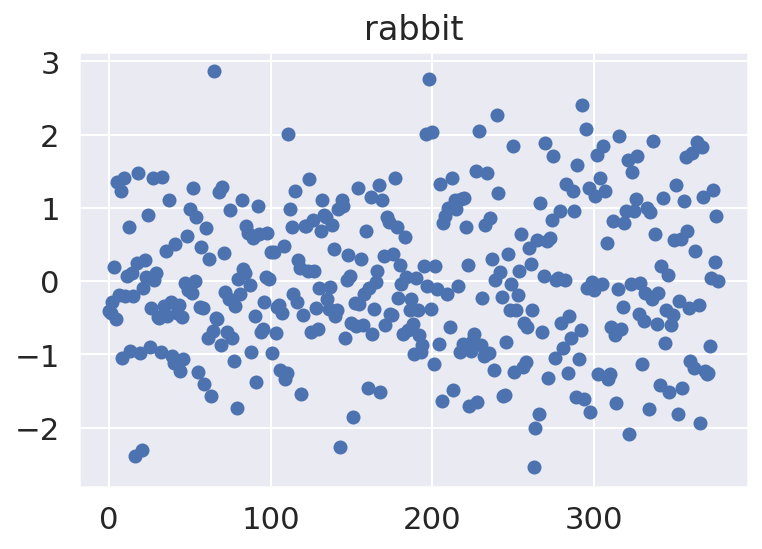

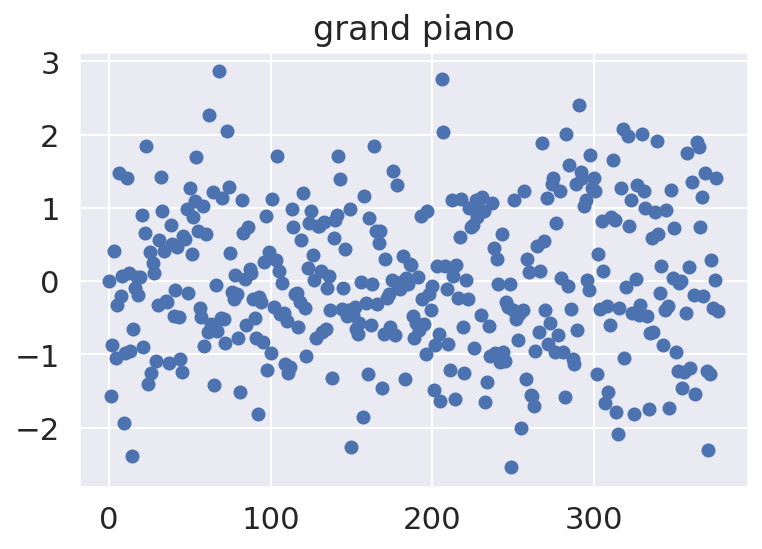

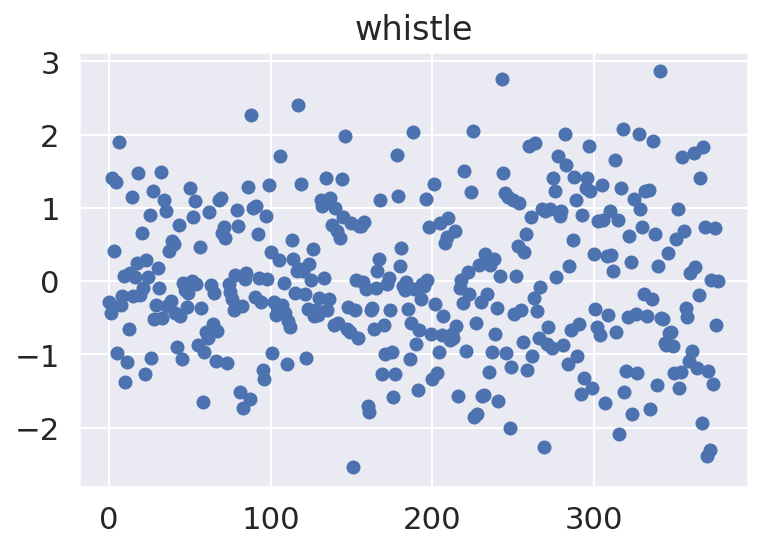

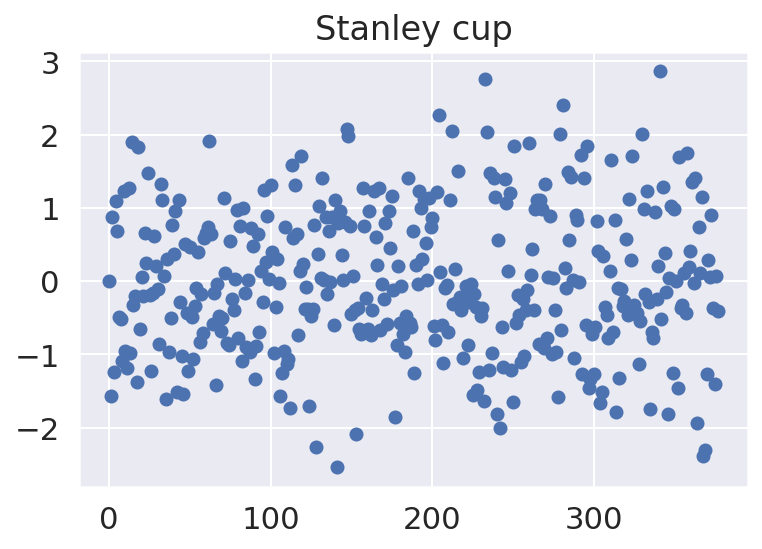

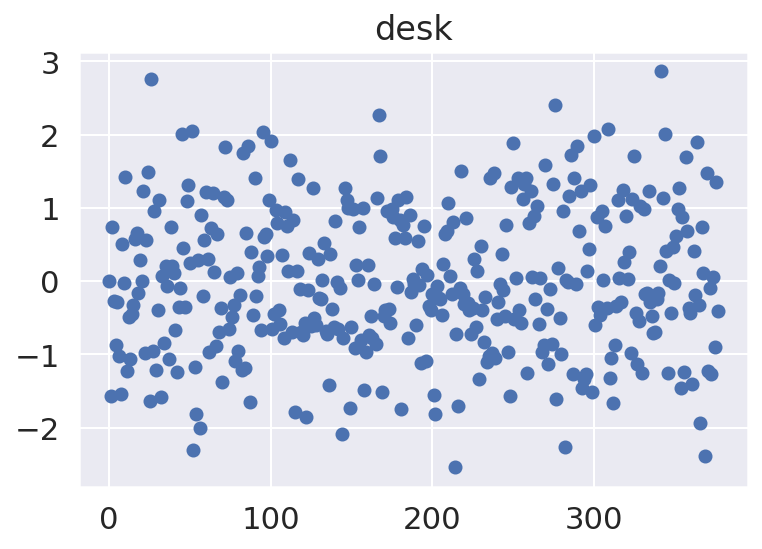

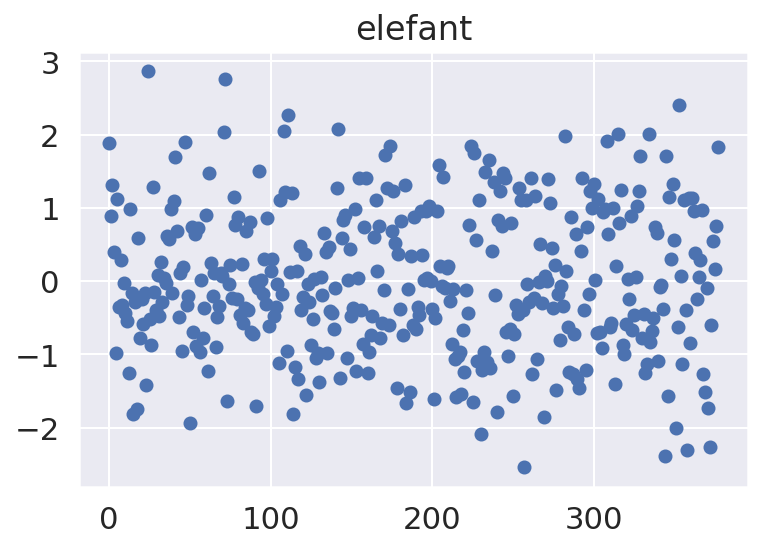

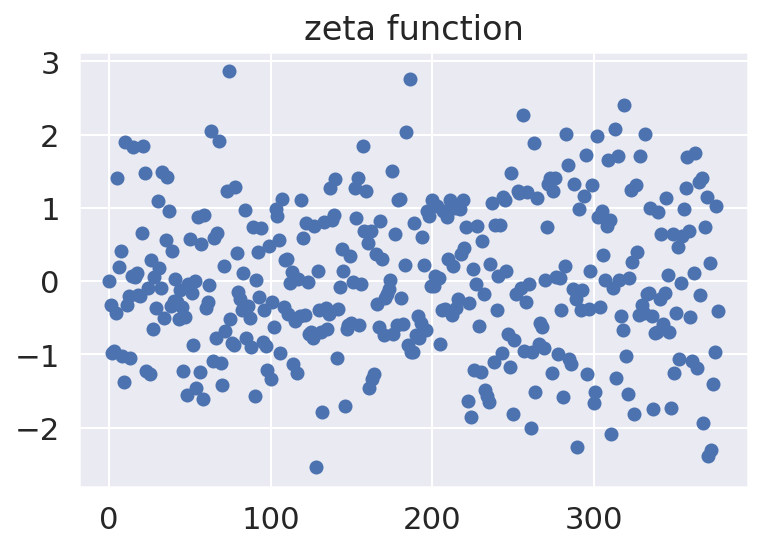

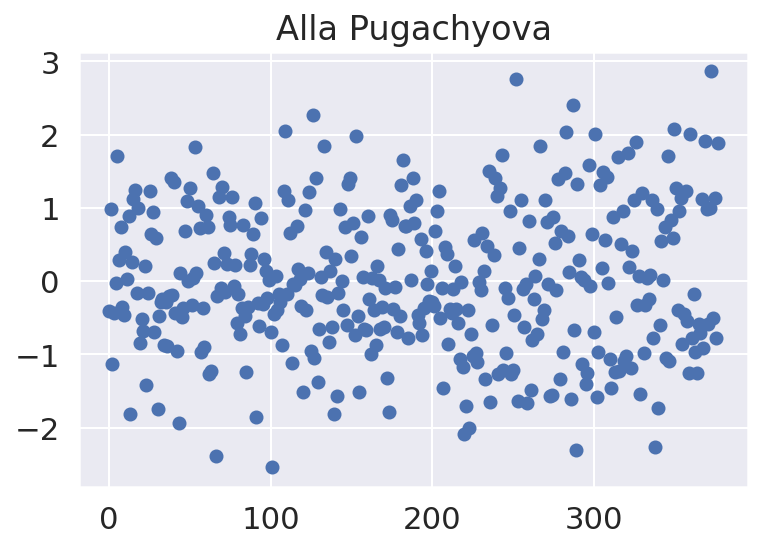

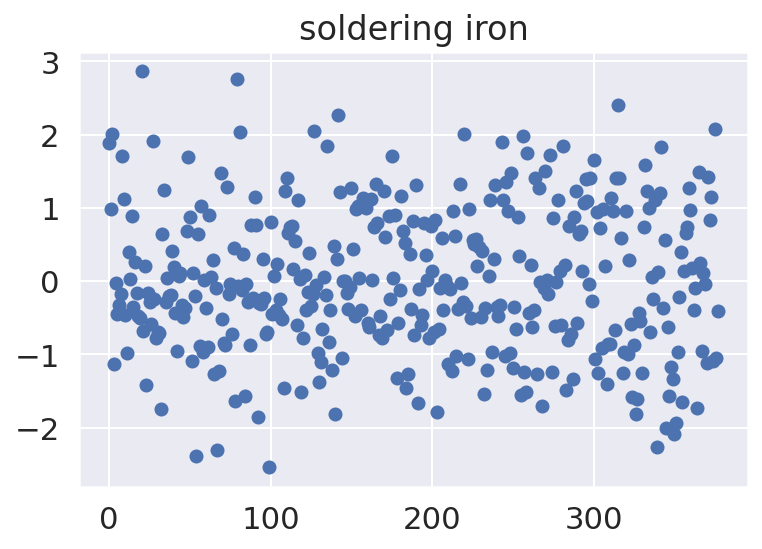

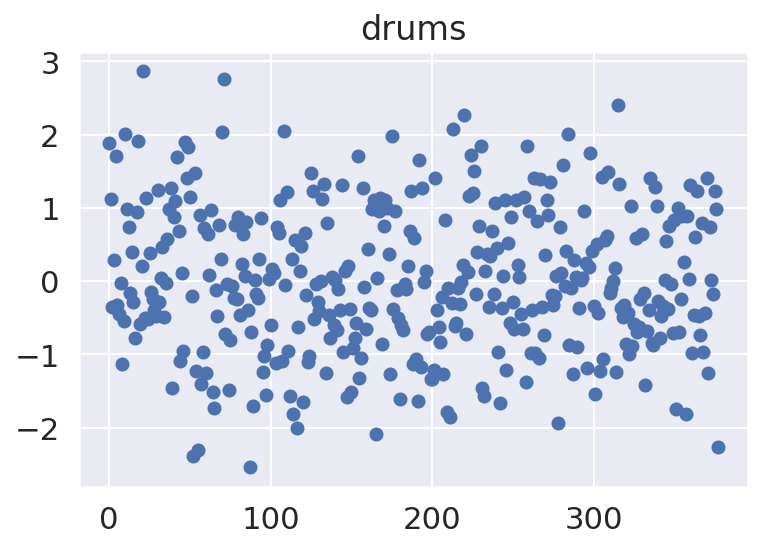

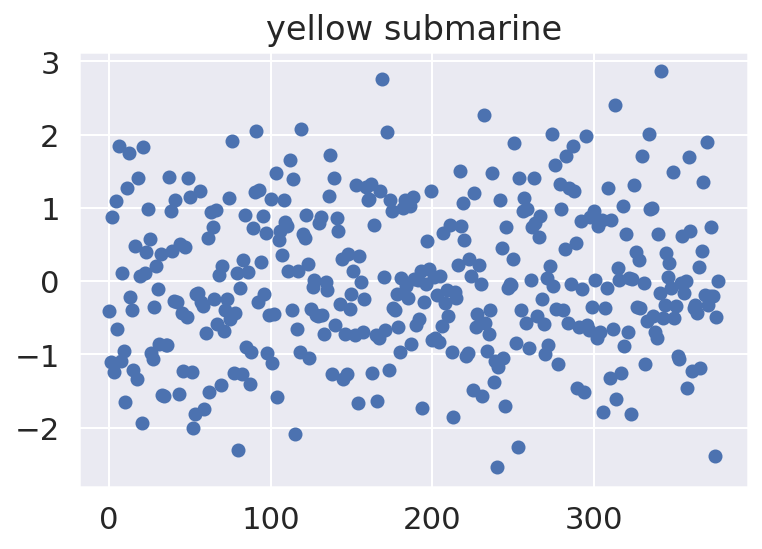

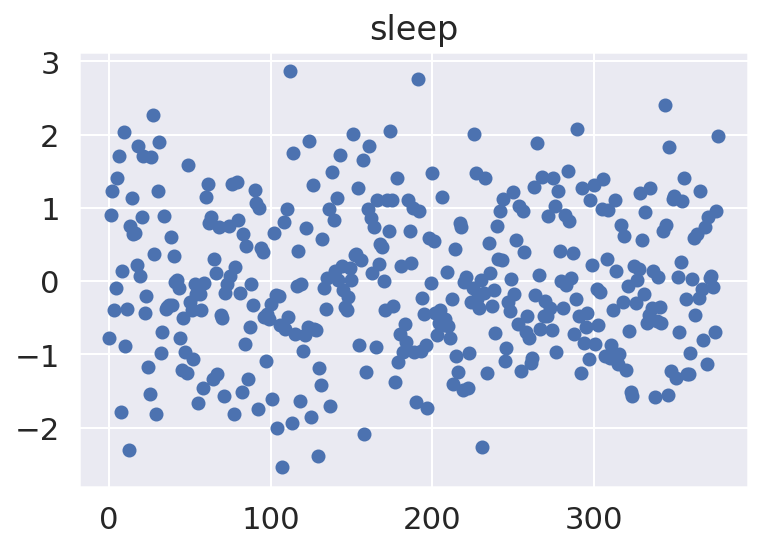

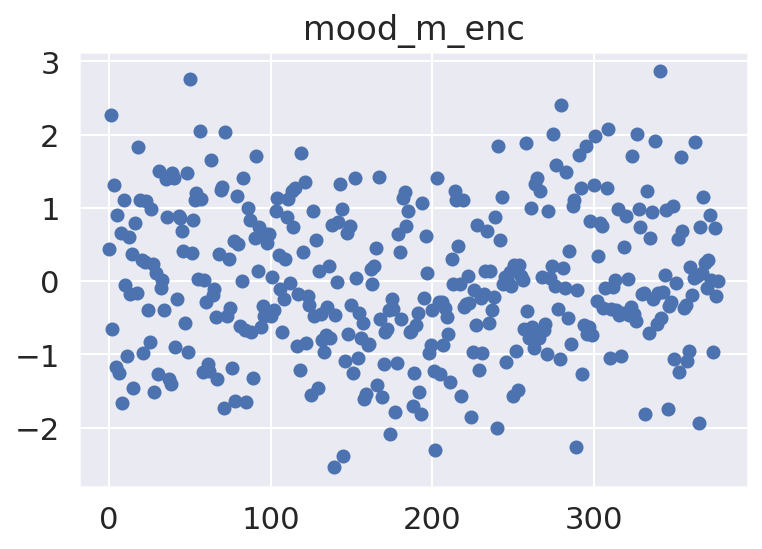

In [424]:
for i in range(X_mod.shape[1]):
    plt.figure()
    plt.plot(err[X_mod.values[:, i].argsort()], 'o')
    plt.title(X_mod.columns[i])

Исходя из графиков, видим какую-то гетероскедатичность по 'Fadeev', а также что признак 'mood' имеет парабольный вид, значит возможно стоит доопределить модель квадратом данного признака. Для начала просто воспользуемся критерием Reset-Рэмси, чтобы проверить неполноту относительно квадратов признаков.

In [425]:
mod = statsmodels.regression.linear_model.OLS(y, X_mod)
statsmodels.stats.diagnostic.linear_reset(mod.fit(), power = 2, use_f=True )

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[114.88809533]]), p=2.1837545870733737e-23, df_denom=352, df_num=1>

In [426]:
def calc_ramsey(model, X, y):
    rss = ((y.values - model.predict(X))**2).sum()
    std = rss / (X.shape[0] - X.shape[1] - 1)
    x_reset = np.hstack([X.values, model.predict(X).reshape((-1, 1)) ** 2])
    model_reset = make_basic_pipeline(LinearRegression(fit_intercept=True))
    model_reset.fit(x_reset, y)
    y_reset = model_reset.predict(x_reset)
    return sps.f.sf((rss - ((y - y_reset) ** 2).sum()) / std, 1, X.shape[0] - X.shape[1] - 1)

In [427]:
calc_ramsey(model_mod, X_mod, y)

6.715619458410099e-19

Есть недоопределенность по квадрату признаков. Добавим признак, равный квадрату настроения. 

In [428]:
X_mod2 = X_mod
X_mod2['mood_sqr'] = np.power(X_mod['mood_m_enc'],2)

In [429]:
model =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin, cv_lin = train_and_test_cv(model, None, "Linear", X_mod2, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin) * (X_mod2.shape[0] - 1) / (X_mod2.shape[0] - X_mod2.shape[1] - 1))

R^2 score  --  0.8973172179586275
cv score  --  -1.7332432686381707
R^2 fixed --  0.8897110859555629


Отлично, $R^2$ немного увеличился (на 0.003), также как и cv_score (на 0.04). Но посмотрим, доопределена ли модель теперь.

In [375]:
calc_ramsey(model, X_mod2, y)

9.301087369689929e-19

Как видим, недоопределенность все равно есть.

Как могли заметить ранее, самые значимые признаки -- друзья. Они -- бинарные. Возможно, есть зависимость от количества друзей,гуляющих одновременно или от пересечений друзей.

In [376]:
X_mod3 = X_mod2.copy()
X_mod3['fk'] = (X_mod3['Fadeev'] & X_mod3['Khaldeev'] & ! X_mod3['Pepermaldeev']) 
X_mod3['fp'] = (X_mod3['Fadeev'] & X_mod3['Pepermaldeev'] ! X_mod3['Khaldeev']) 
X_mod3['kp'] = (X_mod3['Khaldeev'] & X_mod3['Pepermaldeev'] & ) 
X_mod3['fkp'] = (X_mod3['Fadeev'] & X_mod3['Khaldeev'] &  X_mod3['Pepermaldeev'])
X_mod3['num'] = ( X_mod3['Fadeev'] + X_mod3['Khaldeev'] + X_mod3['Pepermaldeev'])
model3 =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin, cv_lin = train_and_test_cv(model3, None, "Linear", X_mod3, y, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin) * (X_mod3.shape[0] - 1) / (X_mod3.shape[0] - X_mod3.shape[1] - 1))

R^2 score  --  0.9822921231192675
cv score  --  -0.33060291150629784
R^2 fixed --  0.9807055792368897


Хороший прогресс. Посмотрим теперь на критерий.

In [377]:
calc_ramsey(model3, X_mod3, y)

0.06028235774142784

Теперь, как видим, недоопределенности нет. Попробуем еще поиграться с регуляризацией.

In [378]:
parameters = {'Model__alpha': np.append(np.arange(0.2, 20.1, 0.05), np.logspace(-6, -3, 4))}
model_r = make_basic_pipeline(Ridge(fit_intercept=True)) 
r2, cv = train_and_test_cv(model_r, parameters, "Ridge", X_mod3, y, True)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_mod3.shape[0] - 1) / (X_mod3.shape[0] - X_mod3.shape[1] - 1))

Best parameters: {'Model__alpha': 0.001}
R^2 score  --  0.9822920924757708
cv score  --  -0.3286103016742289
R^2 fixed --  0.9807055458478774


In [386]:
fs

Best parameters: {'Model__alpha': 1e-06}
R^2 score  --  0.9821671331157695
cv score  --  -0.32863070754715307
R^2 fixed --  0.9805693907070668


Еще немного улучшился cv_score. Сохраним.

In [389]:
X_all_rfe = all_X[all_X.columns[tree.support_]]

In [391]:
X_all3 = X_all_rfe.copy()
X_all3['mood_sqr'] = np.power(X_all3['mood_m_enc'],2)
X_all3['fk'] = (X_all3['Fadeev'] & X_all3['Khaldeev']) 
X_all3['fp'] = (X_all3['Fadeev'] & X_all3['Pepermaldeev']) 
X_all3['kp'] = (X_all3['Khaldeev'] & X_all3['Pepermaldeev']) 
X_all3['fkp'] = (X_all3['Fadeev'] & X_all3['Khaldeev'] &  X_all3['Pepermaldeev'])
X_all3['num'] = ( X_all3['Fadeev'] + X_all3['Khaldeev'] + X_all3['Pepermaldeev'])
res = model3.predict(X_all3)
res_fr = pd.DataFrame({'id' : all_X['id'].values, 'duration': res})
res_fr.to_csv("third.csv", index = False)

Как видим, регуляризация не помогает.

In [86]:
X.columns[tree.support_]

Index(['Fadeev', 'Khaldeev', 'Pepermaldeev', 'kees', 'turtle', 'gloves',
       'cardboard', 'toothpaste', 'watch', 'table', 'monkey', 'irunine',
       'rabbit', 'grand piano', 'whistle', 'Stanley cup', 'desk', 'elefant',
       'zeta function', 'Alla Pugachyova', 'soldering iron', 'drums',
       'yellow submarine', 'sleep', 'mood_m_enc'],
      dtype='object')

**Итог:** Оставляем следующую модель. Кодируем настроение через mean-encoding. Отбрасываем все признаки, кроме вышеперечисленных, а также добавляем квадрат признака настроения и пересечение и сумму друзей.

### Задача 4

In [92]:
all_data = pd.read_csv('data/msps-2018-hw9-4/parkinsons_updrs_train.csv')

In [93]:
all_data

subject#  age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  \
0            1   72    0     5.6431    0.00662     0.000034     0.00401   
1            1   72    0    12.6660    0.00300     0.000017     0.00132   
2            1   72    0    19.6810    0.00481     0.000025     0.00205   
3            1   72    0    25.6470    0.00528     0.000027     0.00191   
4            1   72    0    33.6420    0.00335     0.000020     0.00093   
...        ...  ...  ...        ...        ...          ...         ...   
5870        42   61    0   142.7900    0.00406     0.000031     0.00167   
5871        42   61    0   149.8400    0.00297     0.000025     0.00119   
5872        42   61    0   156.8200    0.00349     0.000025     0.00152   
5873        42   61    0   163.7300    0.00281     0.000020     0.00128   
5874        42   61    0   170.7300    0.00282     0.000021     0.00135   

      Jitter:PPQ5  Jitter:DDP  Shimmer  ...  Shimmer:APQ11  Shimmer:DDA  \
0         0.00317     0.01204  0.02565  ...        0.01662      0.04314   
1         0.00150     0.00395  0.02024  ...        0.01689      0.02982   
2         0.00208     0.00616  0.01675  ...        0.01458      0.02202   
3         0.00264     0.00573  0.02309  ...        0.01963      0.03317   
4         0.00130     0.00278  0.01703  ...        0.01819      0.02036   
...           ...         ...      ...  ...            ...          ...   
5870      0.00168     0.00500  0.01896  ...        0.01549      0.02920   
5871      0.00147     0.00358  0.02315  ...        0.01904      0.03157   
5872      0.00187     0.00456  0.02499  ...        0.01877      0.04112   
5873      0.00151     0.00383  0.01484  ...        0.01307      0.02078   
5874      0.00166     0.00406  0.01907  ...        0.01470      0.02839   

           NHR     HNR     RPDE      DFA      PPE  motor_UPDRS_train  \
0     0.014290  21.640  0.41888  0.54842  0.16006             28.199   
1     0.011112  27.183  0.43493  0.56477  0.10810                NaN   
2     0.020220  23.047  0.46222  0.54405  0.21014             28.695   
3     0.027837  24.445  0.48730  0.57794  0.33277             28.905   
4     0.011625  26.126  0.47188  0.56122  0.19361             29.187   
...        ...     ...      ...      ...      ...                ...   
5870  0.025137  22.369  0.64215  0.55314  0.21367             22.485   
5871  0.011927  22.886  0.52598  0.56518  0.12621             21.988   
5872  0.017701  25.065  0.47792  0.57888  0.14157             21.495   
5873  0.007984  24.422  0.56865  0.56327  0.14204             21.007   
5874  0.008172  23.259  0.58608  0.57077  0.15336                NaN   

      total_UPDRS_train    id  
0                34.398     1  
1                   NaN     2  
2                35.389     3  
3                35.810     4  
4                36.375     5  
...                 ...   ...  
5870             33.485  5871  
5871             32.988  5872  
5872             32.495  5873  
5873             32.007  5874  
5874                NaN  5875  

[5875 rows x 23 columns]

In [94]:
all_data.isna().any()

subject#             False
age                  False
sex                  False
test_time            False
Jitter(%)            False
Jitter(Abs)          False
Jitter:RAP           False
Jitter:PPQ5          False
Jitter:DDP           False
Shimmer              False
Shimmer(dB)          False
Shimmer:APQ3         False
Shimmer:APQ5         False
Shimmer:APQ11        False
Shimmer:DDA          False
NHR                  False
HNR                  False
RPDE                 False
DFA                  False
PPE                  False
motor_UPDRS_train     True
total_UPDRS_train     True
id                   False
dtype: bool

Здесь на самом деле нужно внимательно взглянуть на данные. Нужно заметить, что в рамках одного объекта (поле 'subject#'), наши таргеты упорядочены (идет возрастание, потом данные таргетов дублируются). При этом, точно с таким же возрастанием идет время (поле test_time). При этом, при смене объекта значения таргета меняются на порядок. Зависисимость от 'subject#' там очевидно нелинейная, но мы же ведь mean_target_encoding можем перекодировать этот признак, тогда он будет коррелировать с таргетами.
Таким образом, сейчас гипотеза заключается в том, что есть зависимост только от объекта и времени теста.

Если гипотеза верна, то стоит вопрос в том, а может ли нам прийти после обучения объект с другим id. Если нет -- то вообще все хорошо. Если же может, то тут уже мы не сможем его перекодировать. В связи с этим, сделаем следующее -- сначала рассмотрим случай с перекодированием id, а затем попробуем его выбросить и решать задачу без него.

ПОстроим пару графиков, чтобы подкрепить слова.

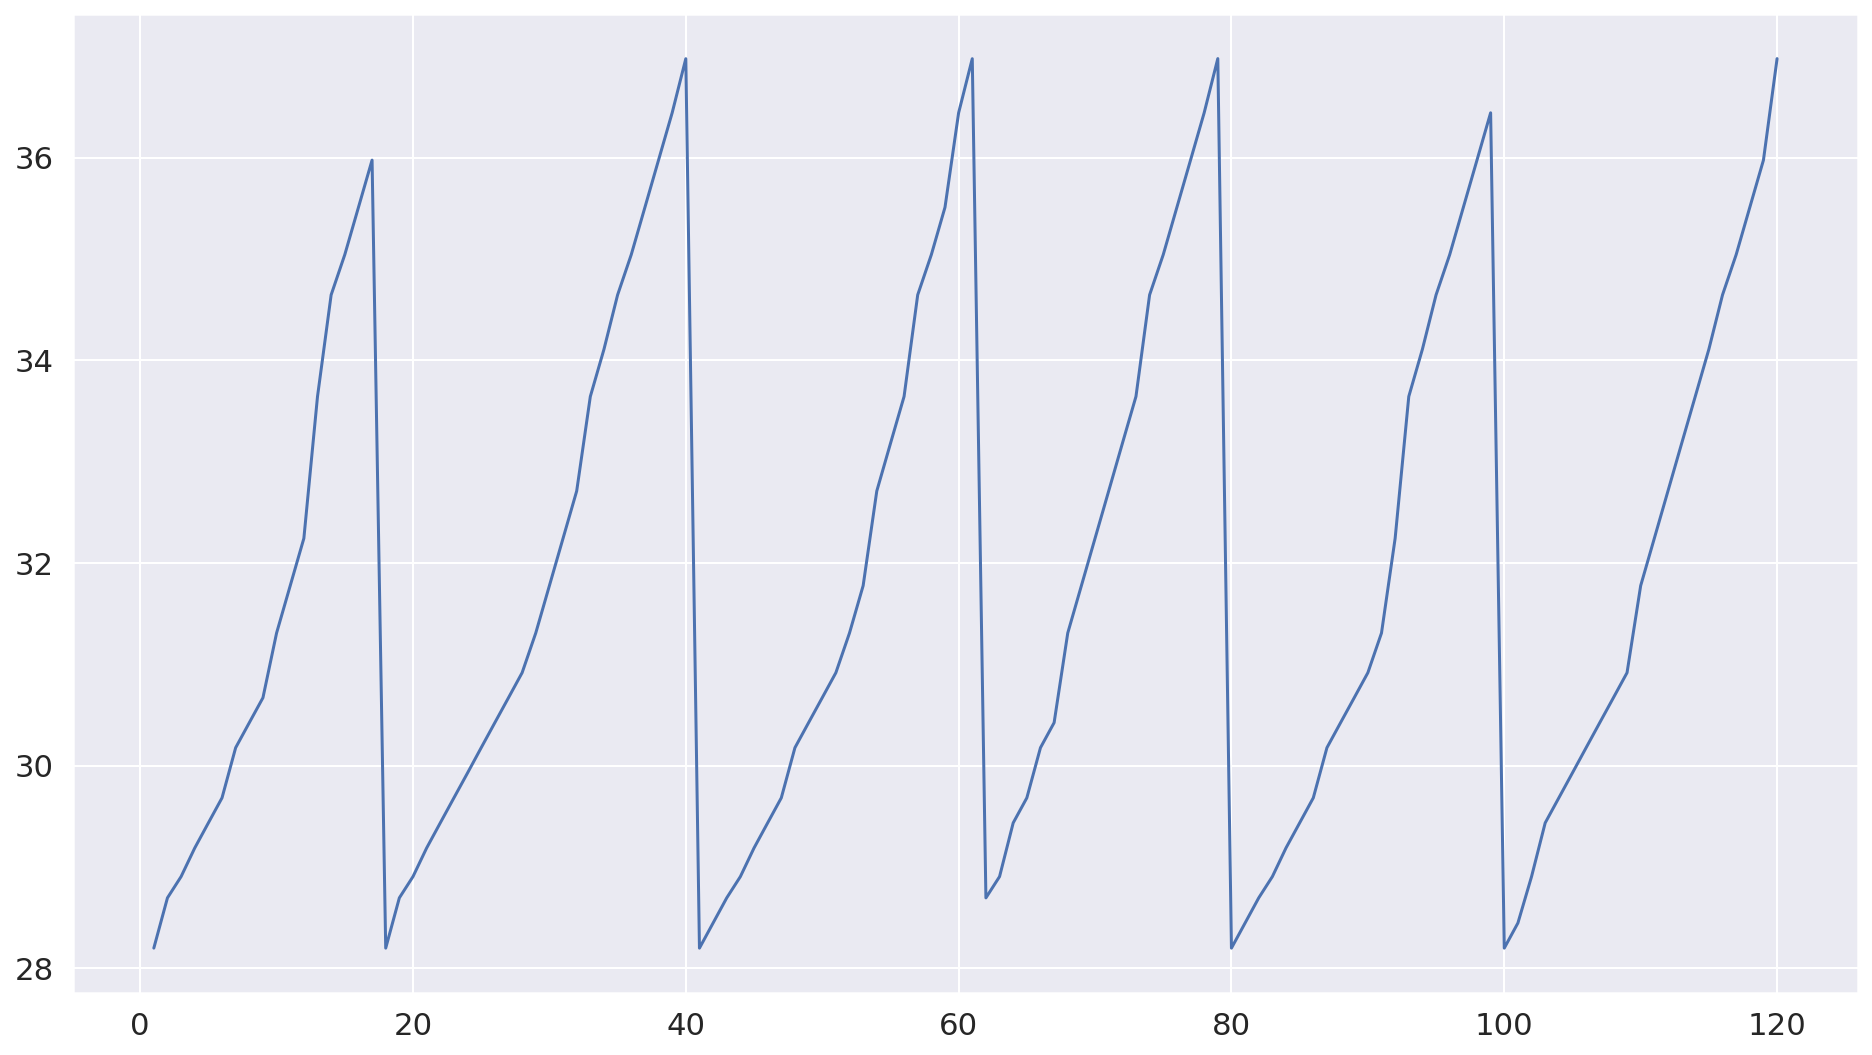

In [95]:
dat = all_data.dropna()
first = dat[dat['subject#'] == 1]['motor_UPDRS_train']
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, len(first) + 1), first.values)

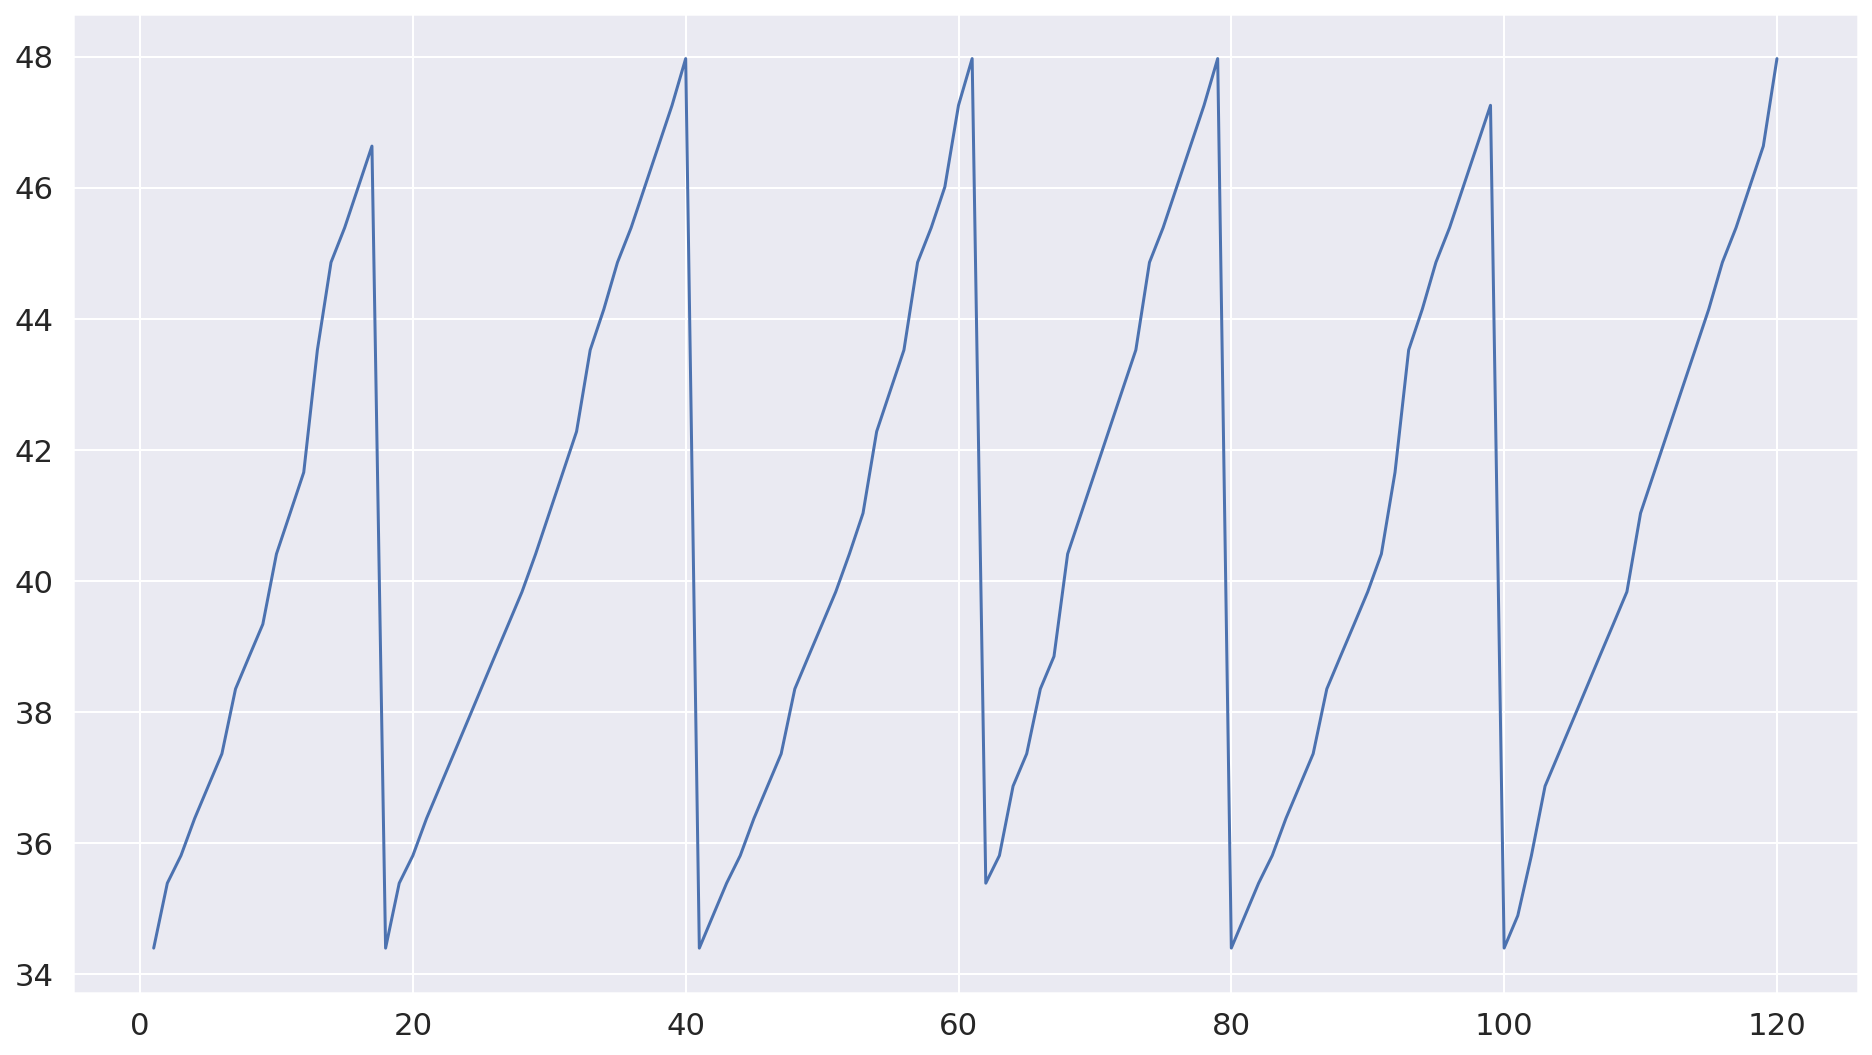

In [96]:
dat = all_data.dropna()
first = dat[dat['subject#'] == 1]['total_UPDRS_train']
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, len(first) + 1), first.values)

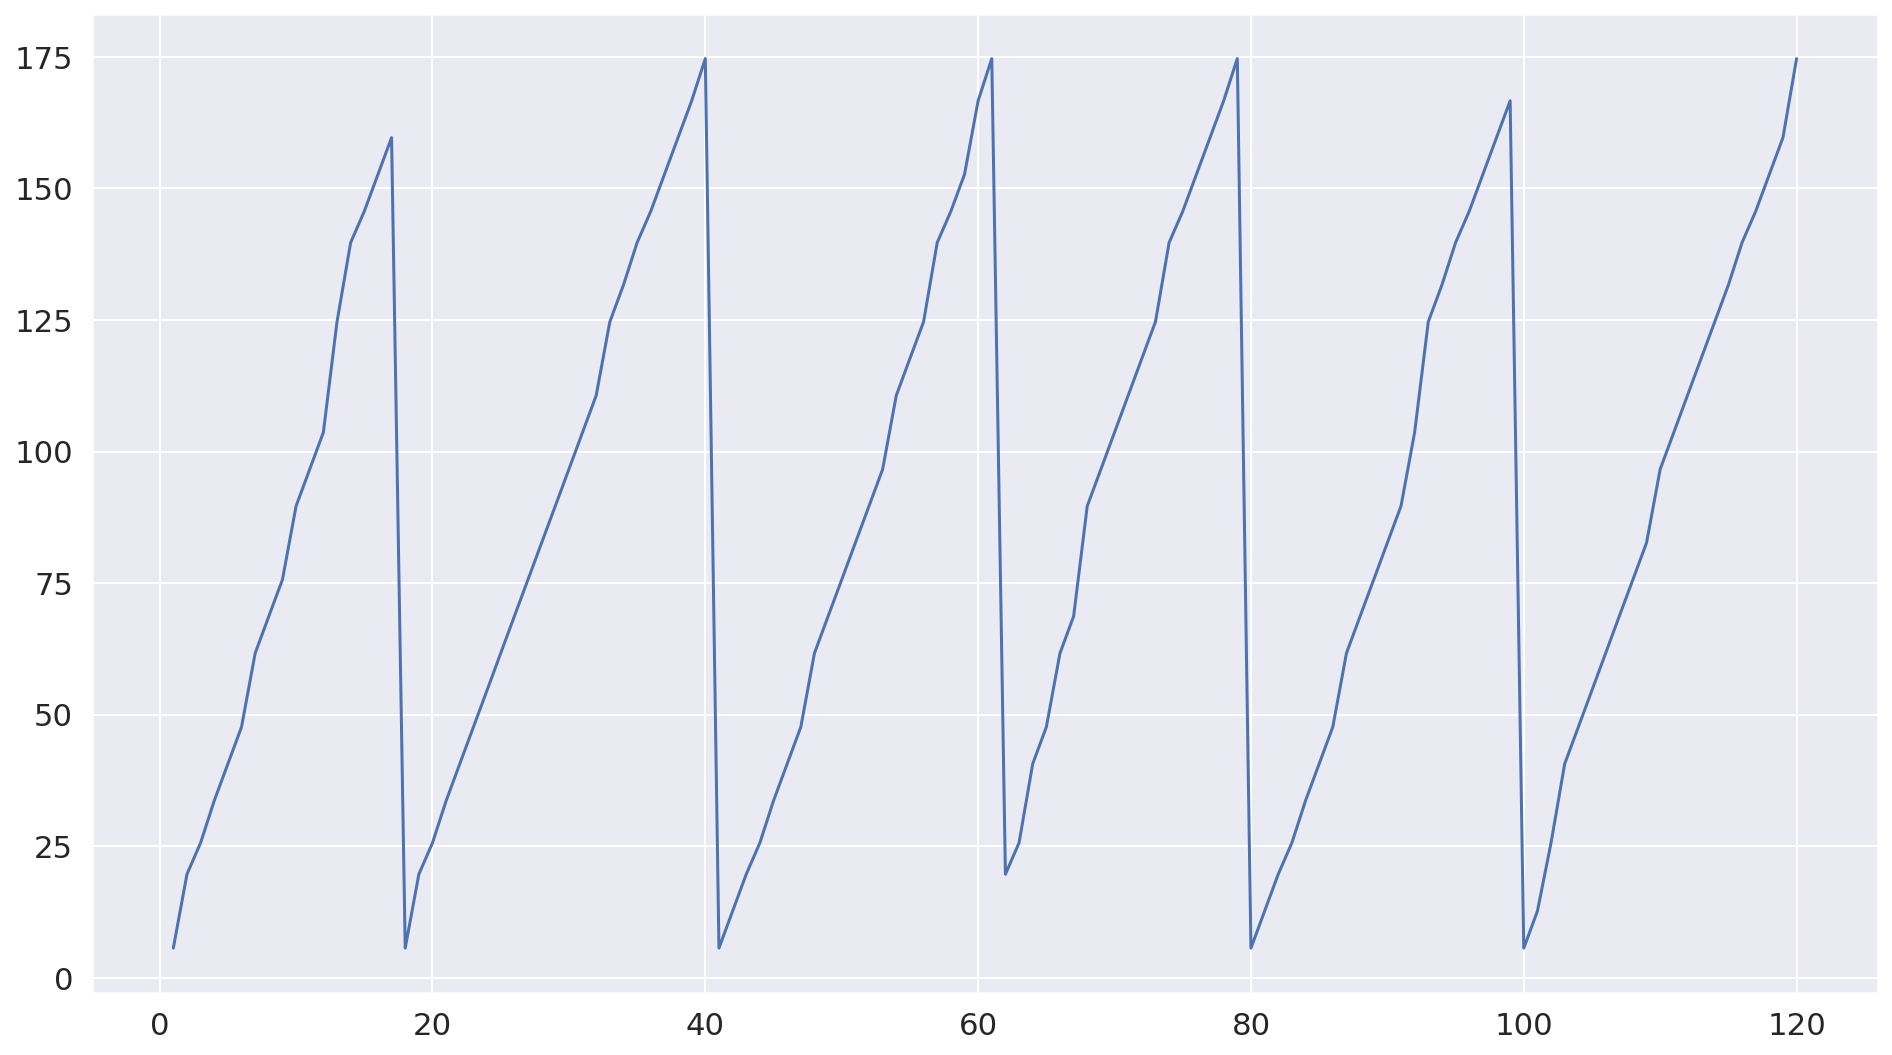

In [97]:
dat = all_data.dropna()
first = dat[dat['subject#'] == 1]['test_time']
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, len(first) + 1), first.values)

Как видим, если убрать порядок, то графики совершенно эквивалентны. Это значит, тут как раз ровно линейная зависимость таргета от времени. Разве это не чудесно?)

Закодируем заново номера объктов.

In [98]:
data_c = all_data.copy()
data_c['subject_for_mot'] = all_data[ 'subject#']
data_c['subject_for_tot'] = all_data[ 'subject#']
data_c = data_c.drop(['subject#'], axis = 1)
data_tr1 = mean_target_encoding(data_c,'motor_UPDRS_train', 'subject_for_mot')
data_tr = mean_target_encoding(data_tr1,'total_UPDRS_train', 'subject_for_tot')

In [99]:
all_data

subject#  age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  \
0            1   72    0     5.6431    0.00662     0.000034     0.00401   
1            1   72    0    12.6660    0.00300     0.000017     0.00132   
2            1   72    0    19.6810    0.00481     0.000025     0.00205   
3            1   72    0    25.6470    0.00528     0.000027     0.00191   
4            1   72    0    33.6420    0.00335     0.000020     0.00093   
...        ...  ...  ...        ...        ...          ...         ...   
5870        42   61    0   142.7900    0.00406     0.000031     0.00167   
5871        42   61    0   149.8400    0.00297     0.000025     0.00119   
5872        42   61    0   156.8200    0.00349     0.000025     0.00152   
5873        42   61    0   163.7300    0.00281     0.000020     0.00128   
5874        42   61    0   170.7300    0.00282     0.000021     0.00135   

      Jitter:PPQ5  Jitter:DDP  Shimmer  ...  Shimmer:APQ11  Shimmer:DDA  \
0         0.00317     0.01204  0.02565  ...        0.01662      0.04314   
1         0.00150     0.00395  0.02024  ...        0.01689      0.02982   
2         0.00208     0.00616  0.01675  ...        0.01458      0.02202   
3         0.00264     0.00573  0.02309  ...        0.01963      0.03317   
4         0.00130     0.00278  0.01703  ...        0.01819      0.02036   
...           ...         ...      ...  ...            ...          ...   
5870      0.00168     0.00500  0.01896  ...        0.01549      0.02920   
5871      0.00147     0.00358  0.02315  ...        0.01904      0.03157   
5872      0.00187     0.00456  0.02499  ...        0.01877      0.04112   
5873      0.00151     0.00383  0.01484  ...        0.01307      0.02078   
5874      0.00166     0.00406  0.01907  ...        0.01470      0.02839   

           NHR     HNR     RPDE      DFA      PPE  motor_UPDRS_train  \
0     0.014290  21.640  0.41888  0.54842  0.16006             28.199   
1     0.011112  27.183  0.43493  0.56477  0.10810                NaN   
2     0.020220  23.047  0.46222  0.54405  0.21014             28.695   
3     0.027837  24.445  0.48730  0.57794  0.33277             28.905   
4     0.011625  26.126  0.47188  0.56122  0.19361             29.187   
...        ...     ...      ...      ...      ...                ...   
5870  0.025137  22.369  0.64215  0.55314  0.21367             22.485   
5871  0.011927  22.886  0.52598  0.56518  0.12621             21.988   
5872  0.017701  25.065  0.47792  0.57888  0.14157             21.495   
5873  0.007984  24.422  0.56865  0.56327  0.14204             21.007   
5874  0.008172  23.259  0.58608  0.57077  0.15336                NaN   

      total_UPDRS_train    id  
0                34.398     1  
1                   NaN     2  
2                35.389     3  
3                35.810     4  
4                36.375     5  
...                 ...   ...  
5870             33.485  5871  
5871             32.988  5872  
5872             32.495  5873  
5873             32.007  5874  
5874                NaN  5875  

[5875 rows x 23 columns]

In [100]:
data_tr = data_tr.drop([ 'subject_for_mot', 'subject_for_tot'],axis = 1)
data_tr

age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0      72    0     5.6431    0.00662     0.000034     0.00401      0.00317   
1      72    0    12.6660    0.00300     0.000017     0.00132      0.00150   
2      72    0    19.6810    0.00481     0.000025     0.00205      0.00208   
3      72    0    25.6470    0.00528     0.000027     0.00191      0.00264   
4      72    0    33.6420    0.00335     0.000020     0.00093      0.00130   
...   ...  ...        ...        ...          ...         ...          ...   
5870   61    0   142.7900    0.00406     0.000031     0.00167      0.00168   
5871   61    0   149.8400    0.00297     0.000025     0.00119      0.00147   
5872   61    0   156.8200    0.00349     0.000025     0.00152      0.00187   
5873   61    0   163.7300    0.00281     0.000020     0.00128      0.00151   
5874   61    0   170.7300    0.00282     0.000021     0.00135      0.00166   

      Jitter:DDP  Shimmer  Shimmer(dB)  ...       NHR     HNR     RPDE  \
0        0.01204  0.02565        0.230  ...  0.014290  21.640  0.41888   
1        0.00395  0.02024        0.179  ...  0.011112  27.183  0.43493   
2        0.00616  0.01675        0.181  ...  0.020220  23.047  0.46222   
3        0.00573  0.02309        0.327  ...  0.027837  24.445  0.48730   
4        0.00278  0.01703        0.176  ...  0.011625  26.126  0.47188   
...          ...      ...          ...  ...       ...     ...      ...   
5870     0.00500  0.01896        0.160  ...  0.025137  22.369  0.64215   
5871     0.00358  0.02315        0.215  ...  0.011927  22.886  0.52598   
5872     0.00456  0.02499        0.244  ...  0.017701  25.065  0.47792   
5873     0.00383  0.01484        0.131  ...  0.007984  24.422  0.56865   
5874     0.00406  0.01907        0.171  ...  0.008172  23.259  0.58608   

          DFA      PPE  motor_UPDRS_train  total_UPDRS_train    id  \
0     0.54842  0.16006             28.199             34.398     1   
1     0.56477  0.10810                NaN                NaN     2   
2     0.54405  0.21014             28.695             35.389     3   
3     0.57794  0.33277             28.905             35.810     4   
4     0.56122  0.19361             29.187             36.375     5   
...       ...      ...                ...                ...   ...   
5870  0.55314  0.21367             22.485             33.485  5871   
5871  0.56518  0.12621             21.988             32.988  5872   
5872  0.57888  0.14157             21.495             32.495  5873   
5873  0.56327  0.14204             21.007             32.007  5874   
5874  0.57077  0.15336                NaN                NaN  5875   

      subject_for_mot_m_enc  subject_for_tot_m_enc  
0                 31.926067              40.774542  
1                 31.926067              40.774542  
2                 31.926067              40.774542  
3                 31.926067              40.774542  
4                 31.926067              40.774542  
...                     ...                    ...  
5870              22.812655              33.154718  
5871              22.812655              33.154718  
5872              22.812655              33.154718  
5873              22.812655              33.154718  
5874              22.812655              33.154718  

[5875 rows x 24 columns]

In [101]:
all_X = data_tr.drop(['motor_UPDRS_train', 'total_UPDRS_train'],axis = 1)

In [102]:
data = data_tr.dropna()

In [103]:
data

age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0      72    0     5.6431    0.00662     0.000034     0.00401      0.00317   
2      72    0    19.6810    0.00481     0.000025     0.00205      0.00208   
3      72    0    25.6470    0.00528     0.000027     0.00191      0.00264   
4      72    0    33.6420    0.00335     0.000020     0.00093      0.00130   
5      72    0    40.6520    0.00353     0.000023     0.00119      0.00159   
...   ...  ...        ...        ...          ...         ...          ...   
5869   61    0   136.8000    0.00274     0.000021     0.00118      0.00138   
5870   61    0   142.7900    0.00406     0.000031     0.00167      0.00168   
5871   61    0   149.8400    0.00297     0.000025     0.00119      0.00147   
5872   61    0   156.8200    0.00349     0.000025     0.00152      0.00187   
5873   61    0   163.7300    0.00281     0.000020     0.00128      0.00151   

      Jitter:DDP  Shimmer  Shimmer(dB)  ...       NHR     HNR     RPDE  \
0        0.01204  0.02565        0.230  ...  0.014290  21.640  0.41888   
2        0.00616  0.01675        0.181  ...  0.020220  23.047  0.46222   
3        0.00573  0.02309        0.327  ...  0.027837  24.445  0.48730   
4        0.00278  0.01703        0.176  ...  0.011625  26.126  0.47188   
5        0.00357  0.02227        0.214  ...  0.009438  22.946  0.53949   
...          ...      ...          ...  ...       ...     ...      ...   
5869     0.00355  0.02526        0.218  ...  0.006058  23.935  0.45357   
5870     0.00500  0.01896        0.160  ...  0.025137  22.369  0.64215   
5871     0.00358  0.02315        0.215  ...  0.011927  22.886  0.52598   
5872     0.00456  0.02499        0.244  ...  0.017701  25.065  0.47792   
5873     0.00383  0.01484        0.131  ...  0.007984  24.422  0.56865   

          DFA      PPE  motor_UPDRS_train  total_UPDRS_train    id  \
0     0.54842  0.16006             28.199             34.398     1   
2     0.54405  0.21014             28.695             35.389     3   
3     0.57794  0.33277             28.905             35.810     4   
4     0.56122  0.19361             29.187             36.375     5   
5     0.57243  0.19500             29.435             36.870     6   
...       ...      ...                ...                ...   ...   
5869  0.56142  0.13446             22.908             33.908  5870   
5870  0.55314  0.21367             22.485             33.485  5871   
5871  0.56518  0.12621             21.988             32.988  5872   
5872  0.57888  0.14157             21.495             32.495  5873   
5873  0.56327  0.14204             21.007             32.007  5874   

      subject_for_mot_m_enc  subject_for_tot_m_enc  
0                 31.926067              40.774542  
2                 31.926067              40.774542  
3                 31.926067              40.774542  
4                 31.926067              40.774542  
5                 31.926067              40.774542  
...                     ...                    ...  
5869              22.812655              33.154718  
5870              22.812655              33.154718  
5871              22.812655              33.154718  
5872              22.812655              33.154718  
5873              22.812655              33.154718  

[4394 rows x 24 columns]

In [104]:
X = data.drop(['motor_UPDRS_train', 'total_UPDRS_train'], axis = 1)
y_mot, y_tot = data['motor_UPDRS_train'], data['total_UPDRS_train']

In [105]:
X.shape

(4394, 22)

In [106]:
X_mod1 = X[['test_time', 'subject_for_mot_m_enc']]
model_n1 =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin_n, cv_lin = train_and_test_cv(model_n1, None, "Linear", X_mod1, y_mot, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin_n) * (X_mod1.shape[0] - 1) / (X_mod1.shape[0] - X_mod1.shape[1] - 1))

R^2 score  --  0.9236439991861436
cv score  --  -5.605121136531575
R^2 fixed --  0.923609220775388


In [107]:
X_mod2 = X[['test_time', 'subject_for_tot_m_enc']]
model_n2 =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin_n, cv_lin = train_and_test_cv(model_n2, None, "Linear", X_mod2, y_tot, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin_n) * (X_mod2.shape[0] - 1) / (X_mod2.shape[0] - X_mod2.shape[1] - 1))

R^2 score  --  0.9414705107988687
cv score  --  -7.380939233895313
R^2 fixed --  0.9414438519561444


In [108]:
# сейв данной модели для высылки
X_all_mod1 =  all_X[['test_time', 'subject_for_mot_m_enc']]
X_all_mod2 =  all_X[['test_time', 'subject_for_tot_m_enc']]
res1 = model_n1.predict(X_all_mod1)
res2 = model_n2.predict(X_all_mod2)
res_fr = pd.DataFrame({'motor_UPDRS': res1, 'total_UPDRS': res2, 'id' : all_X['id'].values})
res_fr.to_csv("forth.csv", index = False)

Очень хорошие цифры. Для сравнения, сравним с моделью, где все оставшиеся признаки не выкидываем.

Как видим, cv_score значительно упал. Значит действительно, остальные признаки только мешают.

In [109]:
model_n =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin_n, cv_lin = train_and_test_cv(model_n, None, "Linear", X, y_mot, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin_n) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))

R^2 score  --  0.9242465427451094
cv score  --  -5.858469615403445
R^2 fixed --  0.9238652624752381


Чтобы понять, какую хорошую работу мы проделали, сравнимся с самой обычной моделью без предобработанных данных.

In [110]:
X_v = all_data.dropna().drop(['motor_UPDRS_train', 'total_UPDRS_train'], axis = 1)
y_mot_v = all_data['motor_UPDRS_train'].dropna()
model_n =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin_n, cv_lin = train_and_test_cv(model_n, None, "Linear", X_v, y_mot_v, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin_n) * (X_v.shape[0] - 1) / (X_v.shape[0] - X_v.shape[1] - 1))

R^2 score  --  0.2402963220530795
cv score  --  -96.0821145250656
R^2 fixed --  0.2366472421727306


Хороший прирост. Более того, как видим обучение модели без преобразовання 'subject#' получилось совсем плохим. Это дает намек на то, что скорее всего при выбросе 'subject#' врядли получится как-то с помощью отбора признаков и регуляризаций сделать модель сильно лучше. Но мы попробуем. Искать будем один motor_UPDRS_train, так как motor_UPDRS_train и total_UPDRS_train очевидно скоррелированы.

In [111]:
X = all_data.dropna().drop(['subject#','motor_UPDRS_train', 'total_UPDRS_train', 'id'], axis = 1)
y_mot = all_data['motor_UPDRS_train'].dropna()


In [112]:
X

age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0      72    0     5.6431    0.00662     0.000034     0.00401      0.00317   
2      72    0    19.6810    0.00481     0.000025     0.00205      0.00208   
3      72    0    25.6470    0.00528     0.000027     0.00191      0.00264   
4      72    0    33.6420    0.00335     0.000020     0.00093      0.00130   
5      72    0    40.6520    0.00353     0.000023     0.00119      0.00159   
...   ...  ...        ...        ...          ...         ...          ...   
5869   61    0   136.8000    0.00274     0.000021     0.00118      0.00138   
5870   61    0   142.7900    0.00406     0.000031     0.00167      0.00168   
5871   61    0   149.8400    0.00297     0.000025     0.00119      0.00147   
5872   61    0   156.8200    0.00349     0.000025     0.00152      0.00187   
5873   61    0   163.7300    0.00281     0.000020     0.00128      0.00151   

      Jitter:DDP  Shimmer  Shimmer(dB)  Shimmer:APQ3  Shimmer:APQ5  \
0        0.01204  0.02565        0.230       0.01438       0.01309   
2        0.00616  0.01675        0.181       0.00734       0.00844   
3        0.00573  0.02309        0.327       0.01106       0.01265   
4        0.00278  0.01703        0.176       0.00679       0.00929   
5        0.00357  0.02227        0.214       0.01006       0.01337   
...          ...      ...          ...           ...           ...   
5869     0.00355  0.02526        0.218       0.01375       0.01595   
5870     0.00500  0.01896        0.160       0.00973       0.01133   
5871     0.00358  0.02315        0.215       0.01052       0.01277   
5872     0.00456  0.02499        0.244       0.01371       0.01456   
5873     0.00383  0.01484        0.131       0.00693       0.00870   

      Shimmer:APQ11  Shimmer:DDA       NHR     HNR     RPDE      DFA      PPE  
0           0.01662      0.04314  0.014290  21.640  0.41888  0.54842  0.16006  
2           0.01458      0.02202  0.020220  23.047  0.46222  0.54405  0.21014  
3           0.01963      0.03317  0.027837  24.445  0.48730  0.57794  0.33277  
4           0.01819      0.02036  0.011625  26.126  0.47188  0.56122  0.19361  
5           0.02263      0.03019  0.009438  22.946  0.53949  0.57243  0.19500  
...             ...          ...       ...     ...      ...      ...      ...  
5869        0.02108      0.04126  0.006058  23.935  0.45357  0.56142  0.13446  
5870        0.01549      0.02920  0.025137  22.369  0.64215  0.55314  0.21367  
5871        0.01904      0.03157  0.011927  22.886  0.52598  0.56518  0.12621  
5872        0.01877      0.04112  0.017701  25.065  0.47792  0.57888  0.14157  
5873        0.01307      0.02078  0.007984  24.422  0.56865  0.56327  0.14204  

[4394 rows x 19 columns]

In [113]:
model_n =  make_basic_pipeline(LinearRegression(fit_intercept=True))
r2_lin_n, cv_lin = train_and_test_cv(model_n, None, "Linear", X, y_mot, False)
print(f"R^2 fixed -- ", 1 - (1 - r2_lin_n) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))

R^2 score  --  0.15658839203132435
cv score  --  -82.74951928403455
R^2 fixed --  0.1529247384987673


0.15 в коэффициенте детерминации выглядит совсем плохо(

In [114]:
forest = ExtraTreesRegressor(n_estimators=100)
forest.fit(X, y_mot)

ExtraTreesRegressor()

In [115]:
for ind, val in enumerate(forest.feature_importances_):
    print(ind, " -- ", val)


0  --  0.6053826377576681
1  --  0.08266130879012332
2  --  0.06458369860634808
3  --  0.006387086458631273
4  --  0.02246203859990229
5  --  0.00712278717582583
6  --  0.006917342490361782
7  --  0.006712575748830606
8  --  0.007378368153566138
9  --  0.00824055889005337
10  --  0.008236483604062605
11  --  0.009010241839221155
12  --  0.009303879288462834
13  --  0.007557213124999366
14  --  0.009968888301718342
15  --  0.024241960733260636
16  --  0.02758407769462798
17  --  0.0705414871626517
18  --  0.015707365579684458


In [116]:
k = X.shape[1]
print(k)

cv_scores, r2_fixed_scores = [], []

for features_count in range(1, k + 1):
    tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100, 
                                             random_state = 1), n_features_to_select=features_count, step=1)
    X_rfe = tree.fit_transform(X, y_mot)
    model = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
    r2, cv = train_and_test_cv(model, None, "Linear", X_rfe, y_mot, False)
    cv_scores.append(cv)
    r2_fixed_scores.append(1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - features_count - 1))

19
R^2 score  --  0.07048913698687442
cv score  --  -73.48022690550378
R^2 score  --  0.07443957227602815
cv score  --  -73.94188838159998
R^2 score  --  0.0748498552012401
cv score  --  -79.32035655714691
R^2 score  --  0.08544513578580615
cv score  --  -78.66462034069133
R^2 score  --  0.11654256394032836
cv score  --  -75.1001799884414
R^2 score  --  0.11695638532373098
cv score  --  -77.47277892666791
R^2 score  --  0.12048031080155153
cv score  --  -77.69961524148324
R^2 score  --  0.12418500647357644
cv score  --  -77.5983668826323
R^2 score  --  0.14231984008921794
cv score  --  -75.86780840495626
R^2 score  --  0.1430028288942593
cv score  --  -76.20848847202738
R^2 score  --  0.14307813483898657
cv score  --  -77.33797723455584
R^2 score  --  0.14917487967220722
cv score  --  -76.40559524454821
R^2 score  --  0.14919530079445553
cv score  --  -76.48853755460806
R^2 score  --  0.15429604246324258
cv score  --  -80.08416828941515
R^2 score  --  0.15446554331280027
cv score  --  

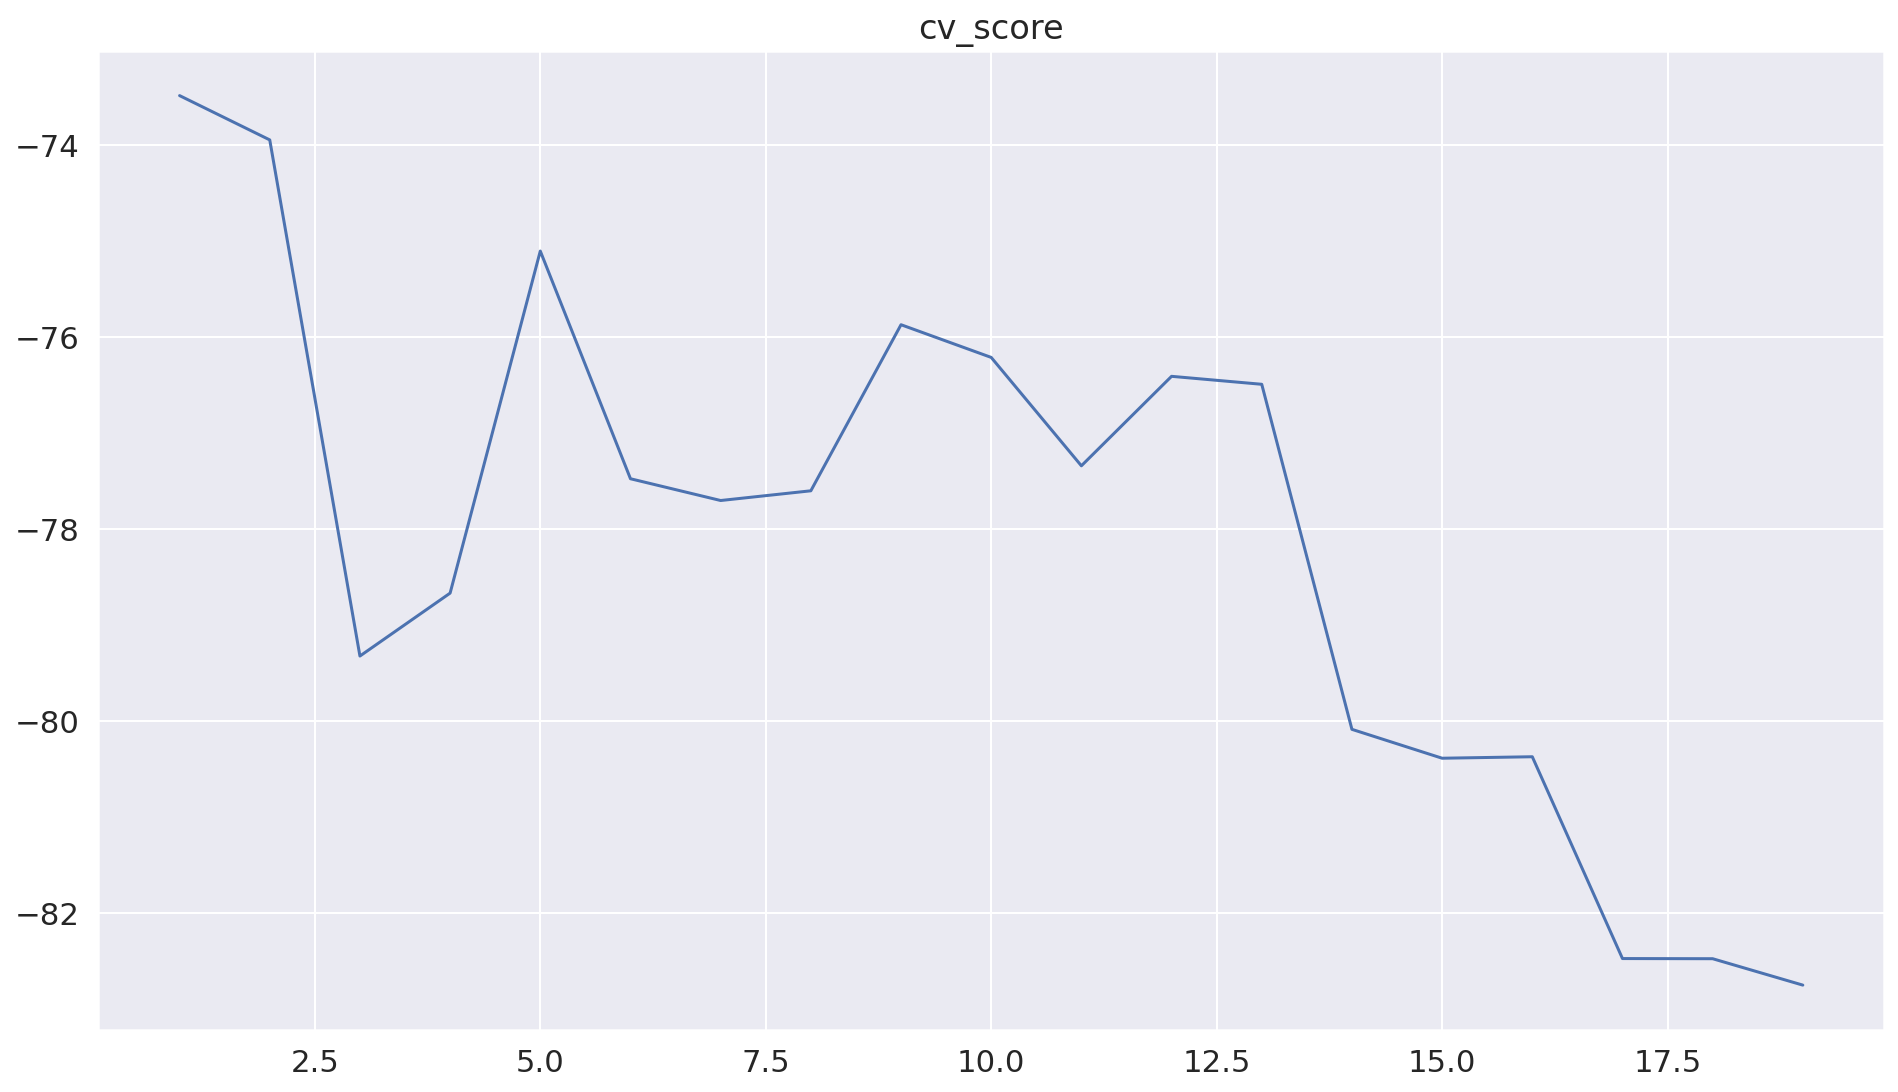

In [117]:
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, k  + 1), cv_scores)
plt.title('cv_score')
plt.show()

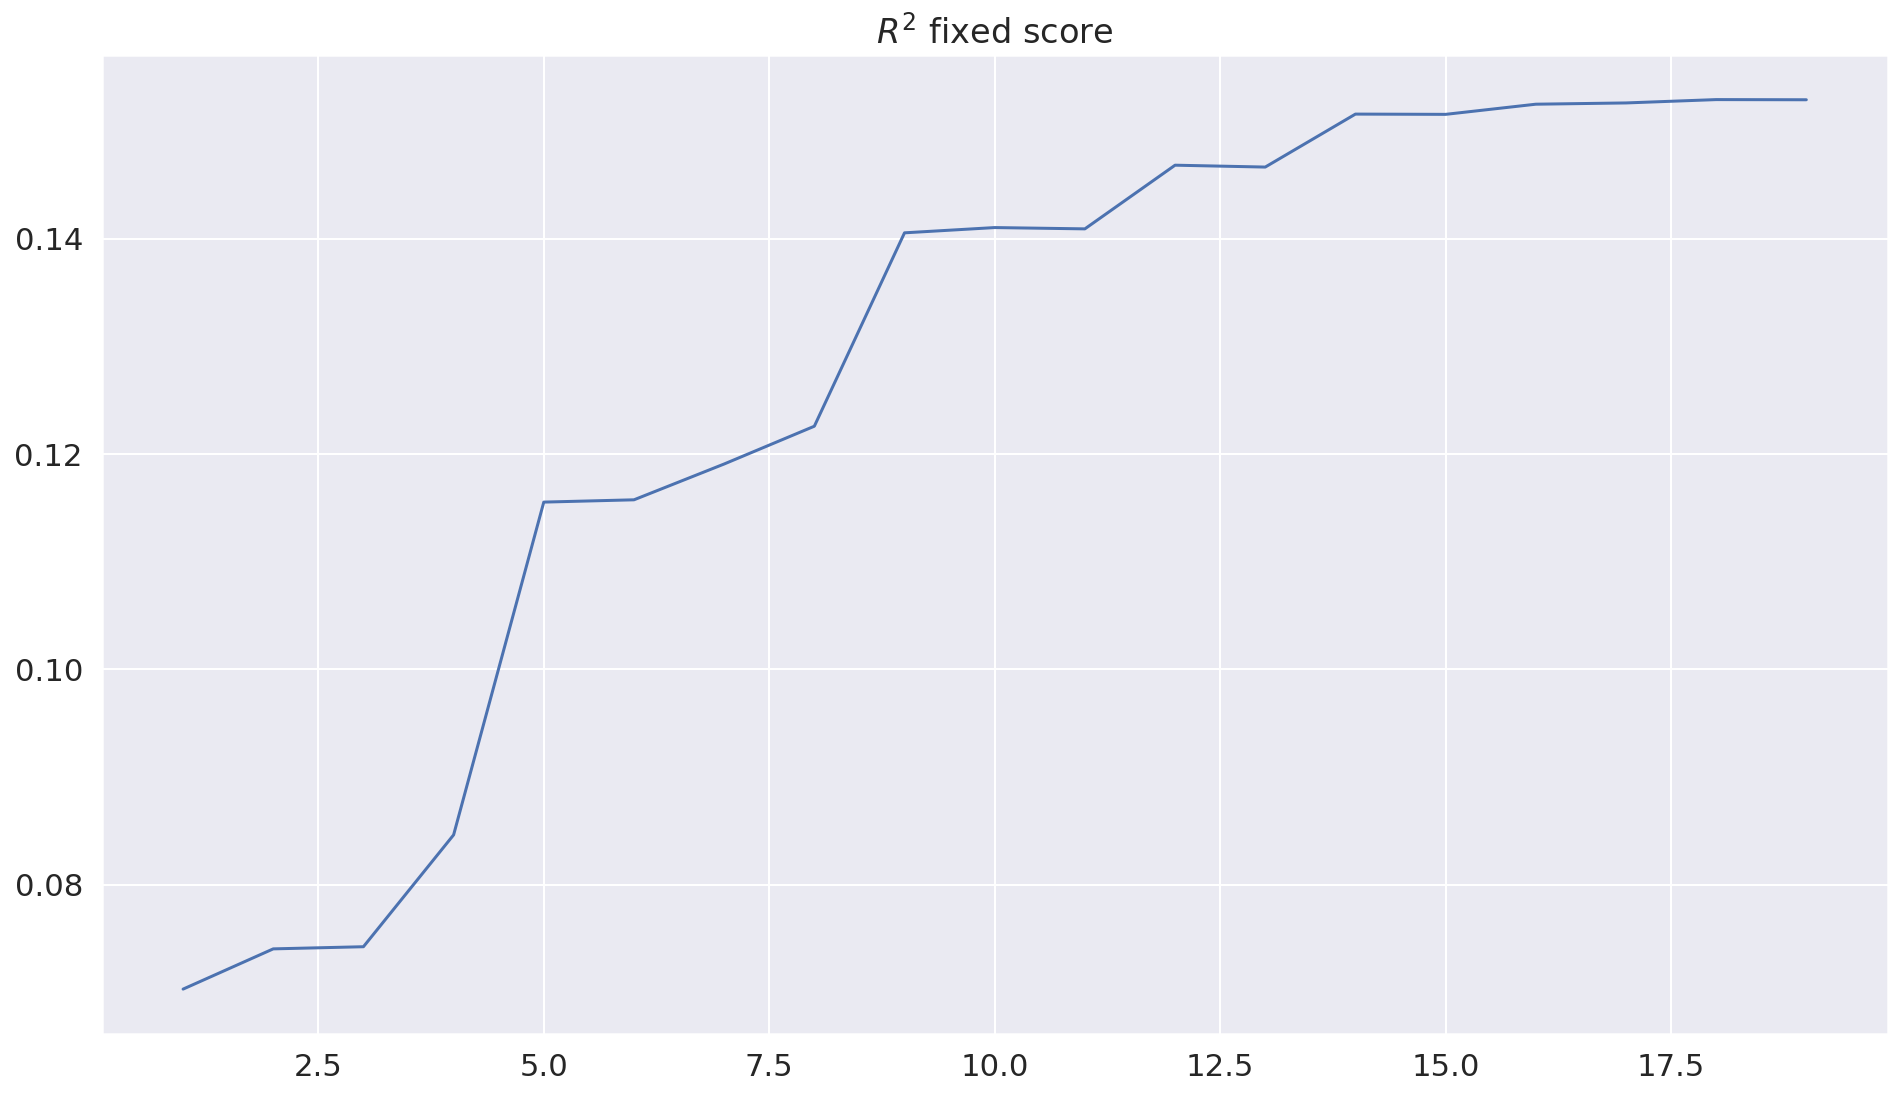

In [118]:
plt.figure(figsize = (16, 9))
plt.plot(np.arange(1, k  + 1), r2_fixed_scores)
plt.title(fr'$R^2$ fixed score')
plt.show()

Если взять 12 фич, то получается самый интересный результат.

In [119]:
tree = RFE(estimator=ExtraTreesRegressor(n_estimators=100, random_state = 1),n_features_to_select=12,  step=1)
X_mod = tree.fit_transform(X, y_mot)
model_mod = make_basic_pipeline(LinearRegression(fit_intercept=True)) 
r2, cv = train_and_test_cv(model_mod, None, "Linear", X_mod, y_mot, False)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X_mod.shape[0] - 1) / (X_mod.shape[0] - X_mod.shape[1] - 1))

R^2 score  --  0.14917487967220722
cv score  --  -76.40559524454821
R^2 fixed --  0.14684438402191424


In [120]:
X_mod = X[X.columns[tree.support_]]

In [121]:
X_mod

age  sex  test_time  Jitter(Abs)  Shimmer:APQ3  Shimmer:APQ5  \
0      72    0     5.6431     0.000034       0.01438       0.01309   
2      72    0    19.6810     0.000025       0.00734       0.00844   
3      72    0    25.6470     0.000027       0.01106       0.01265   
4      72    0    33.6420     0.000020       0.00679       0.00929   
5      72    0    40.6520     0.000023       0.01006       0.01337   
...   ...  ...        ...          ...           ...           ...   
5869   61    0   136.8000     0.000021       0.01375       0.01595   
5870   61    0   142.7900     0.000031       0.00973       0.01133   
5871   61    0   149.8400     0.000025       0.01052       0.01277   
5872   61    0   156.8200     0.000025       0.01371       0.01456   
5873   61    0   163.7300     0.000020       0.00693       0.00870   

      Shimmer:APQ11       NHR     HNR     RPDE      DFA      PPE  
0           0.01662  0.014290  21.640  0.41888  0.54842  0.16006  
2           0.01458  0.020220  23.047  0.46222  0.54405  0.21014  
3           0.01963  0.027837  24.445  0.48730  0.57794  0.33277  
4           0.01819  0.011625  26.126  0.47188  0.56122  0.19361  
5           0.02263  0.009438  22.946  0.53949  0.57243  0.19500  
...             ...       ...     ...      ...      ...      ...  
5869        0.02108  0.006058  23.935  0.45357  0.56142  0.13446  
5870        0.01549  0.025137  22.369  0.64215  0.55314  0.21367  
5871        0.01904  0.011927  22.886  0.52598  0.56518  0.12621  
5872        0.01877  0.017701  25.065  0.47792  0.57888  0.14157  
5873        0.01307  0.007984  24.422  0.56865  0.56327  0.14204  

[4394 rows x 12 columns]

Посмотрим на распредление остатков. 

In [122]:
err = (y_mot - model_mod.predict(X_mod)).values

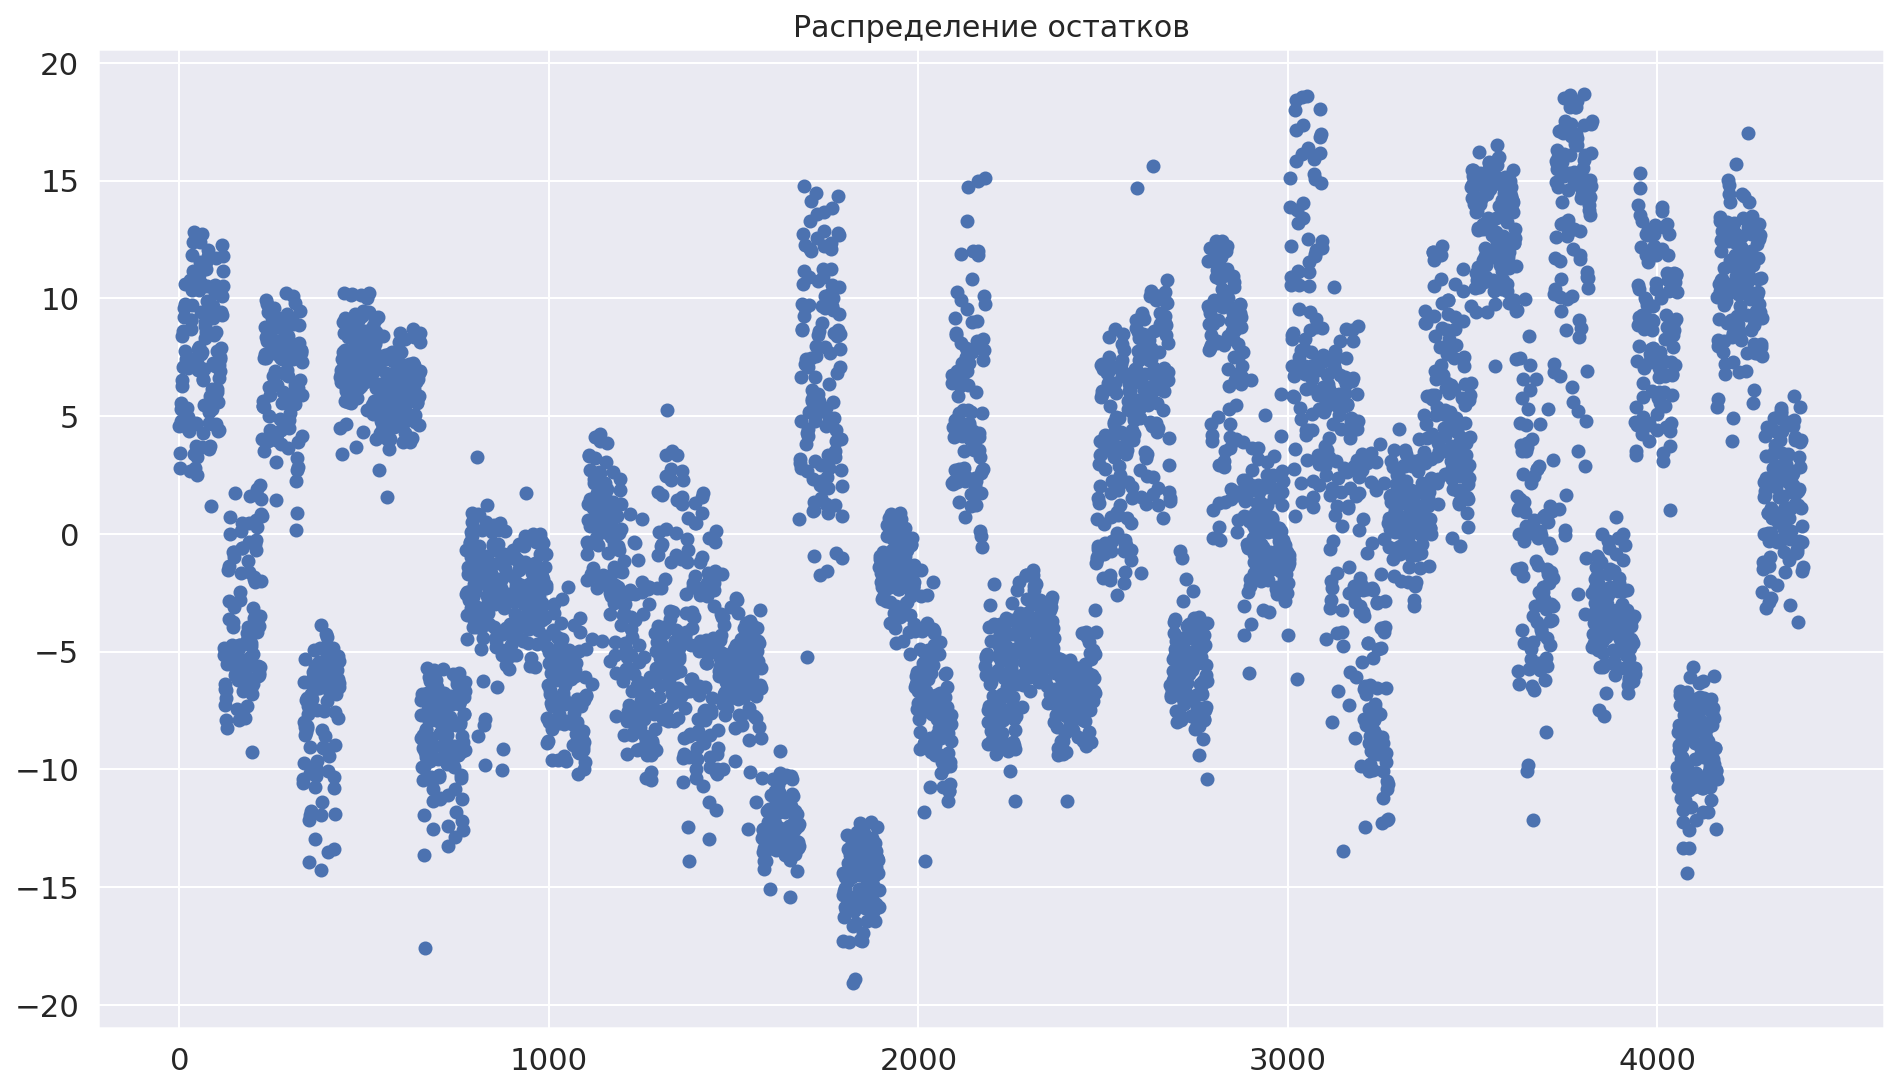

In [123]:
plt.figure(figsize = (16, 9))
plt.plot(err, 'o');
plt.title("Распределение остатков", fontsize=15);

Очевиден тренд от времени ('id'), но мы его как раз отбросили.

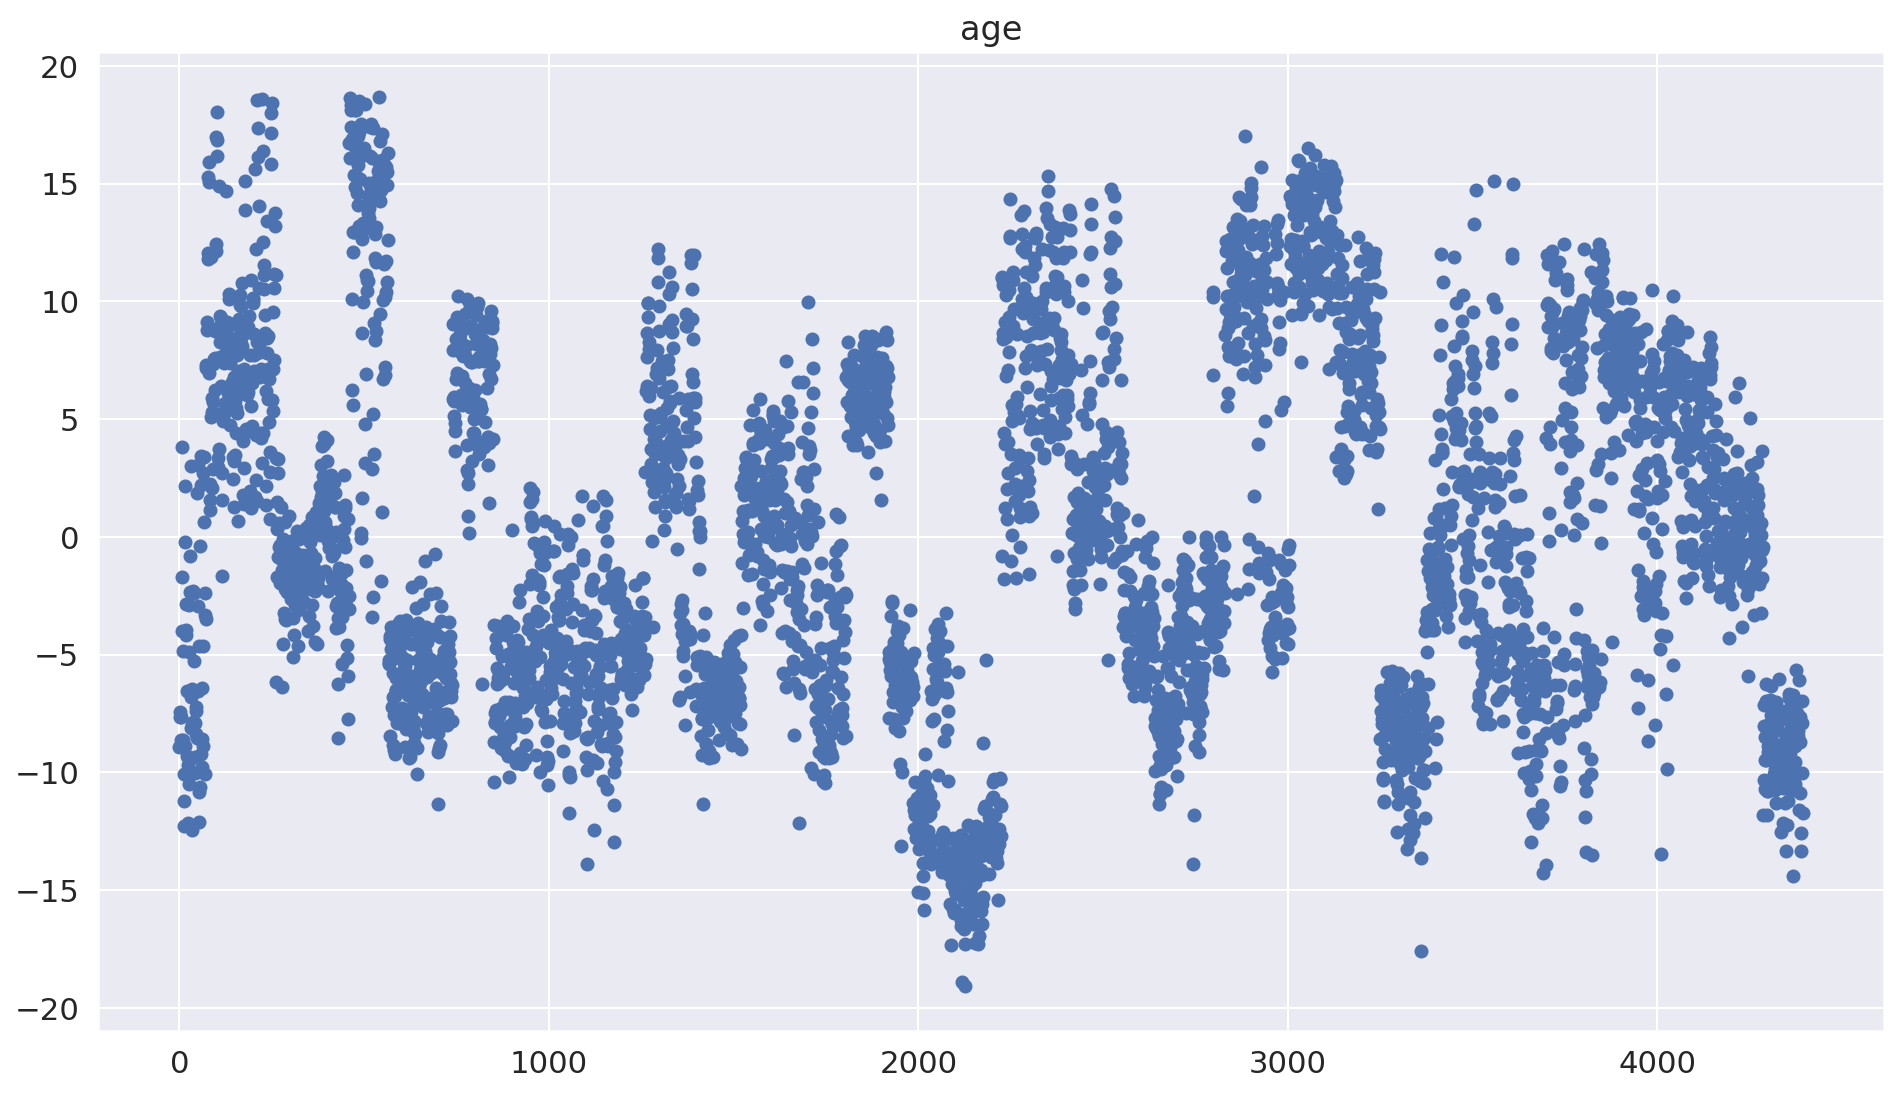

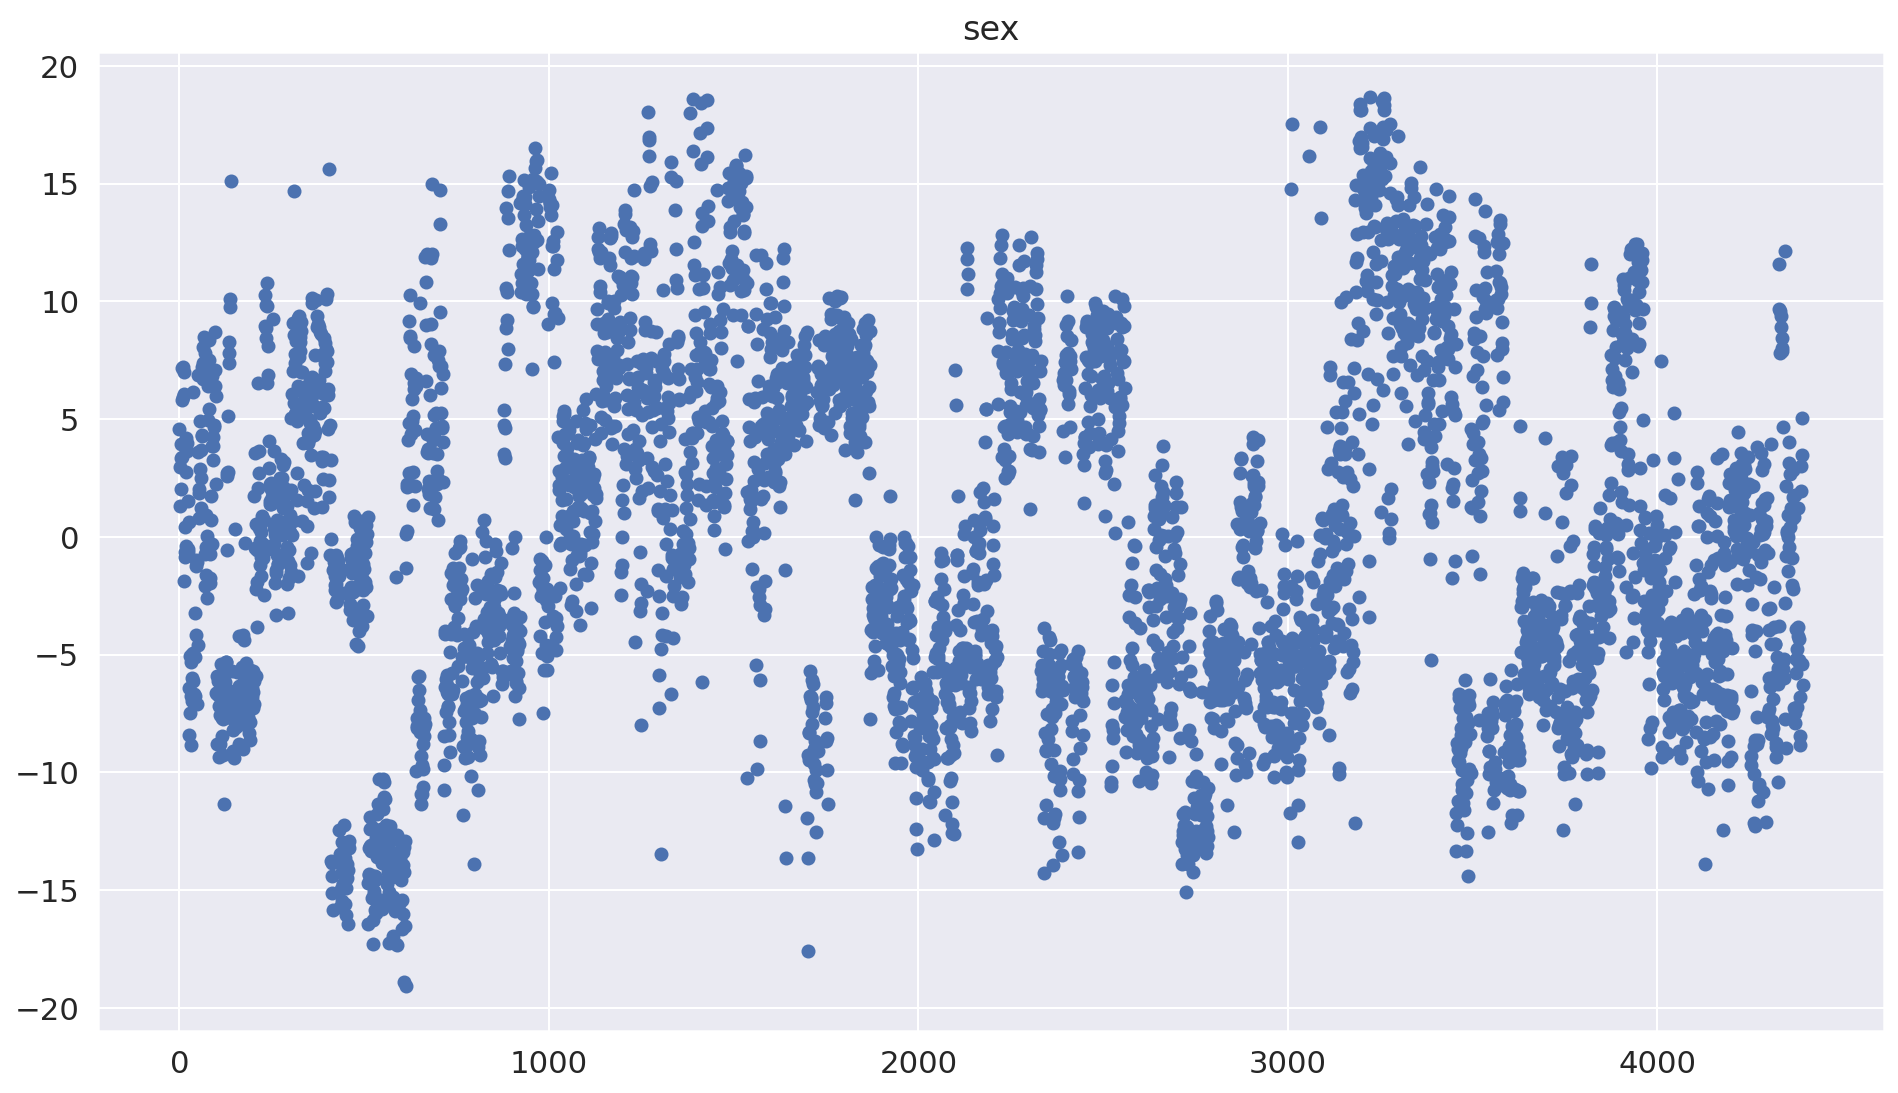

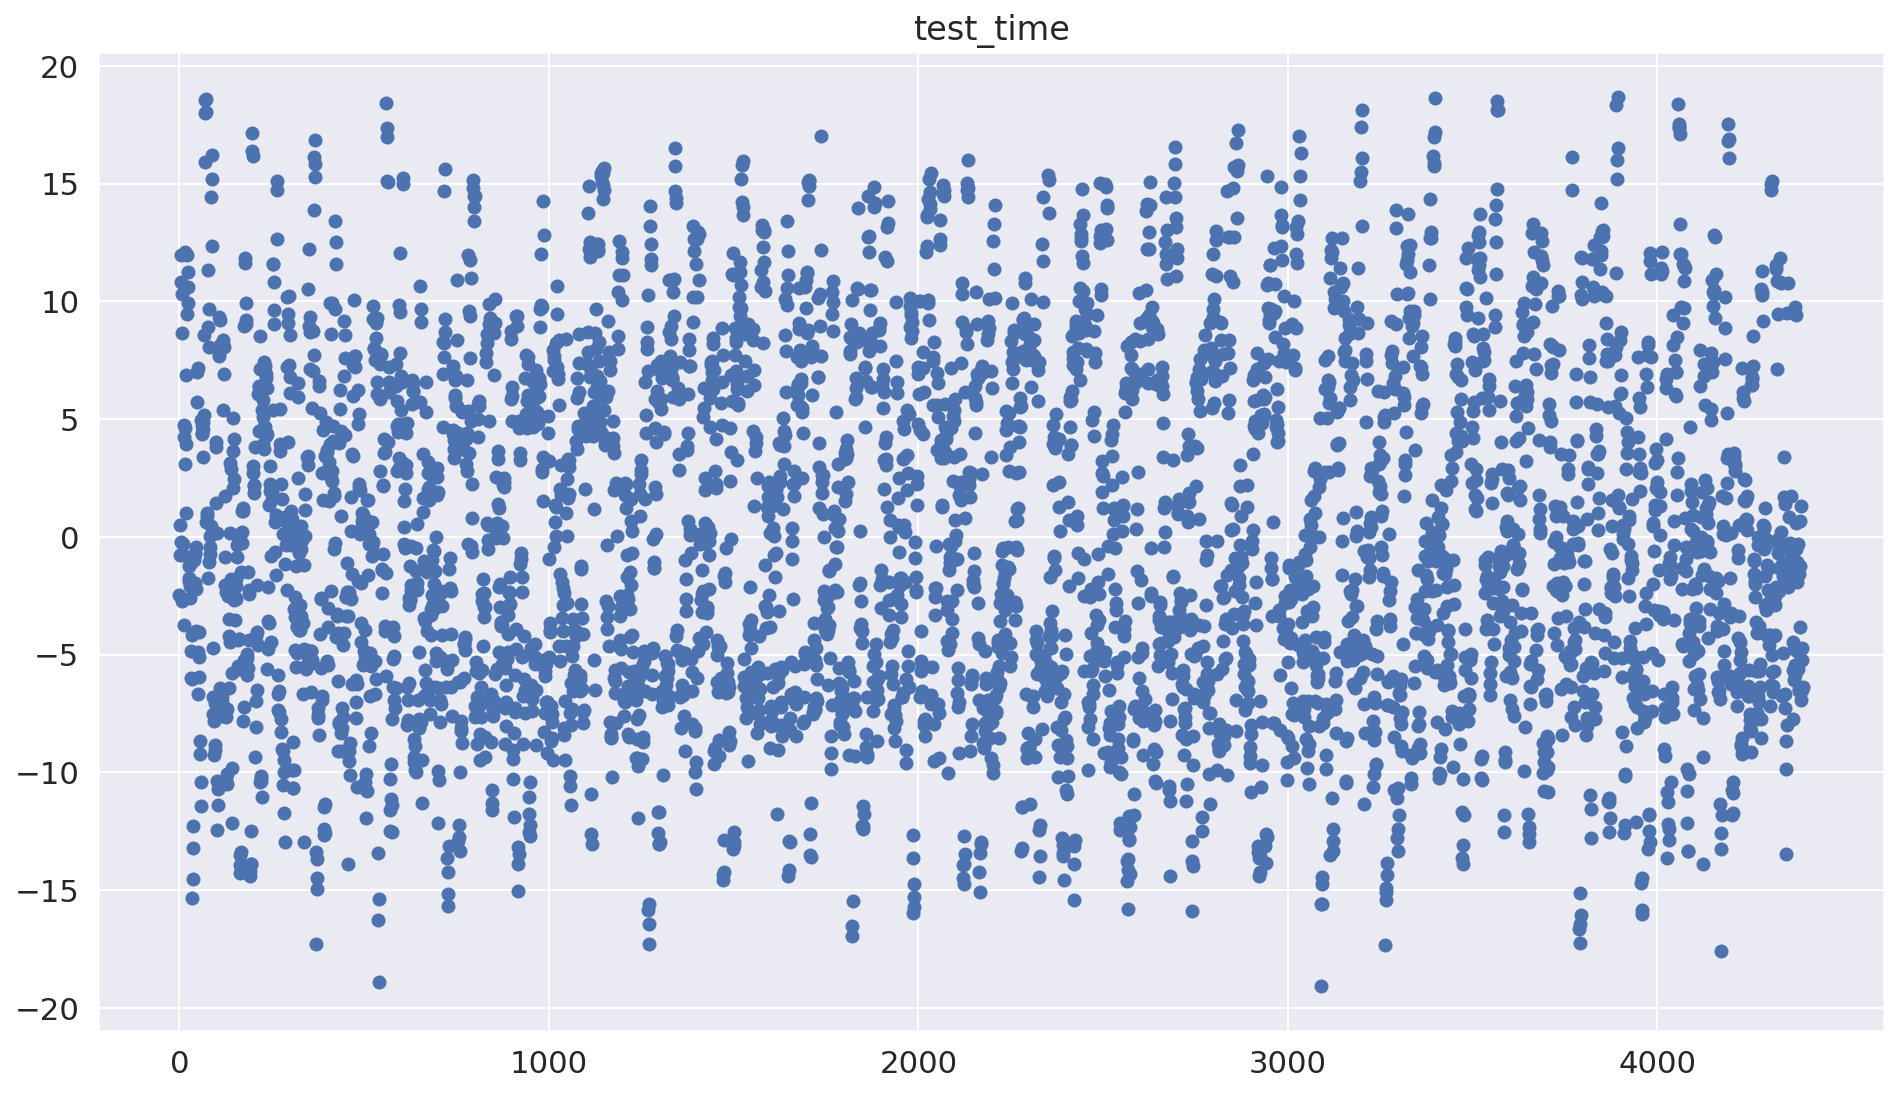

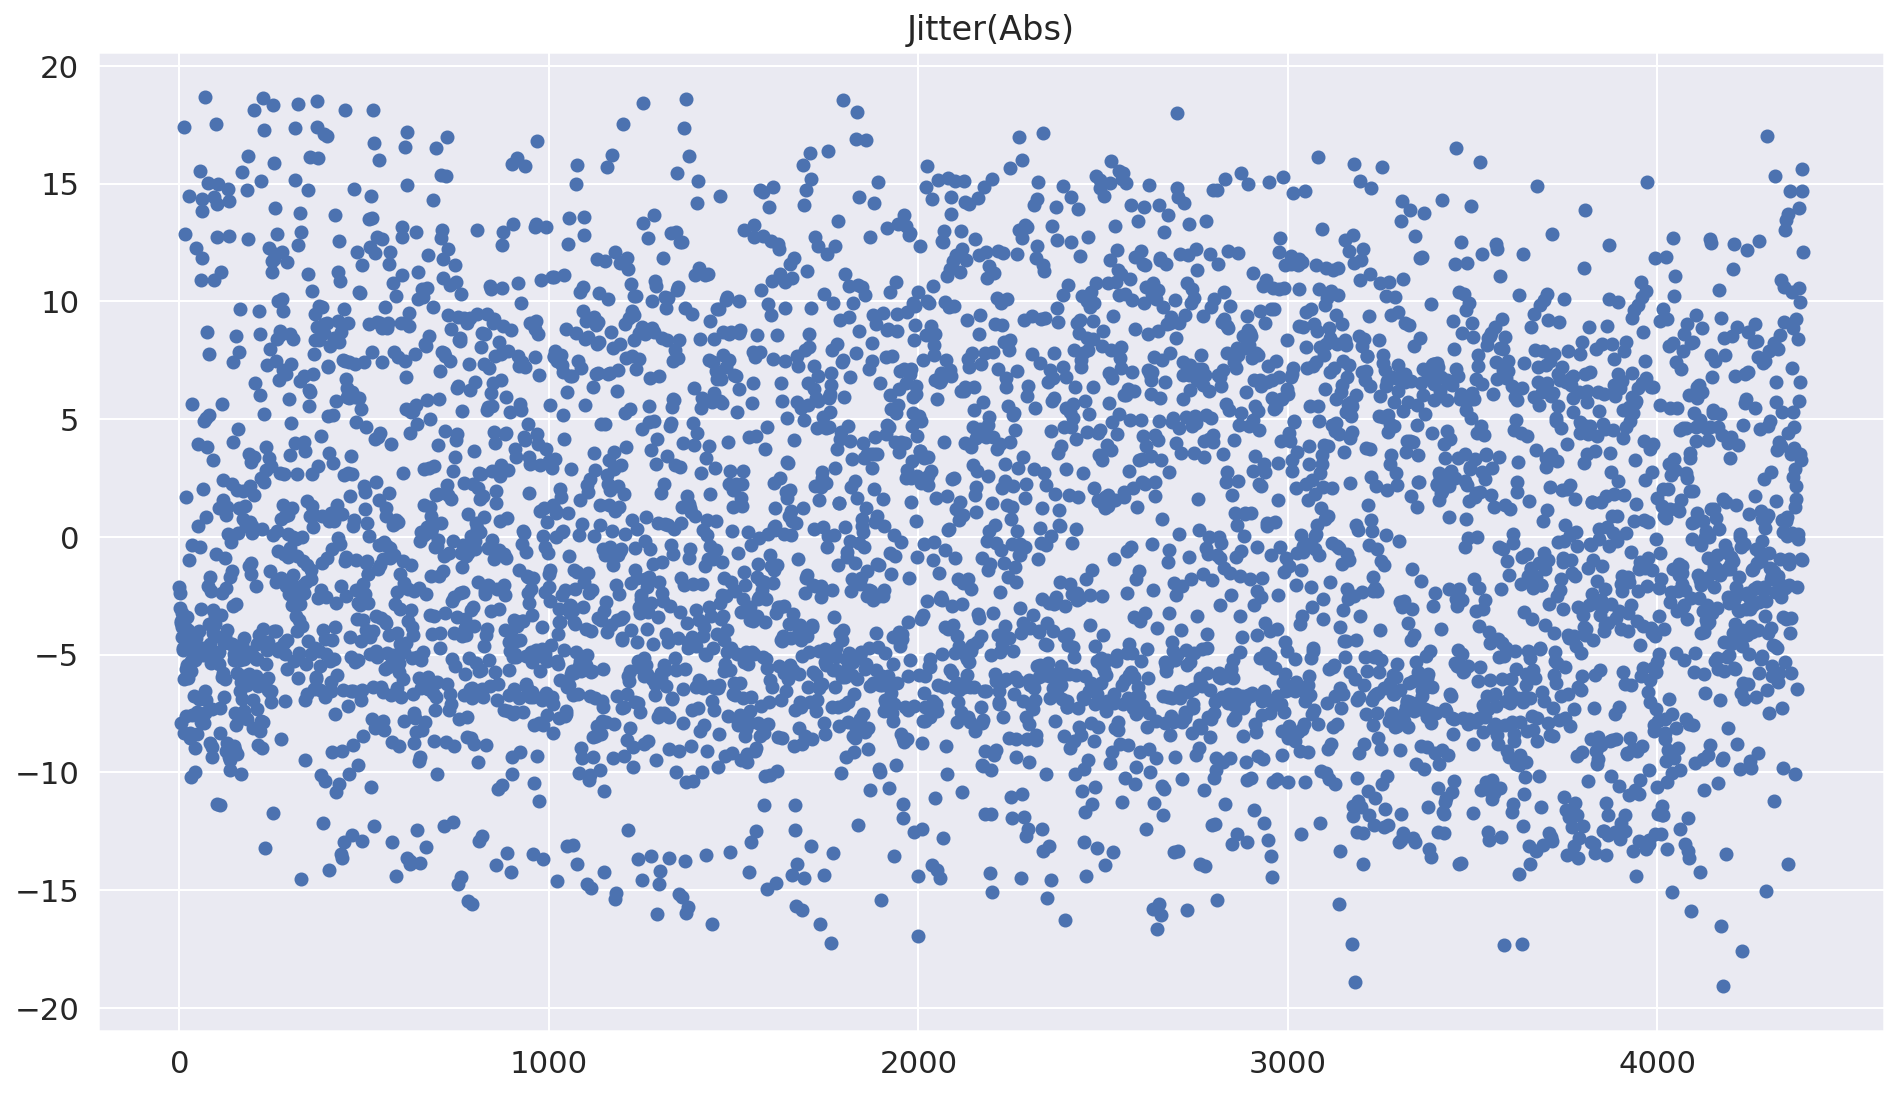

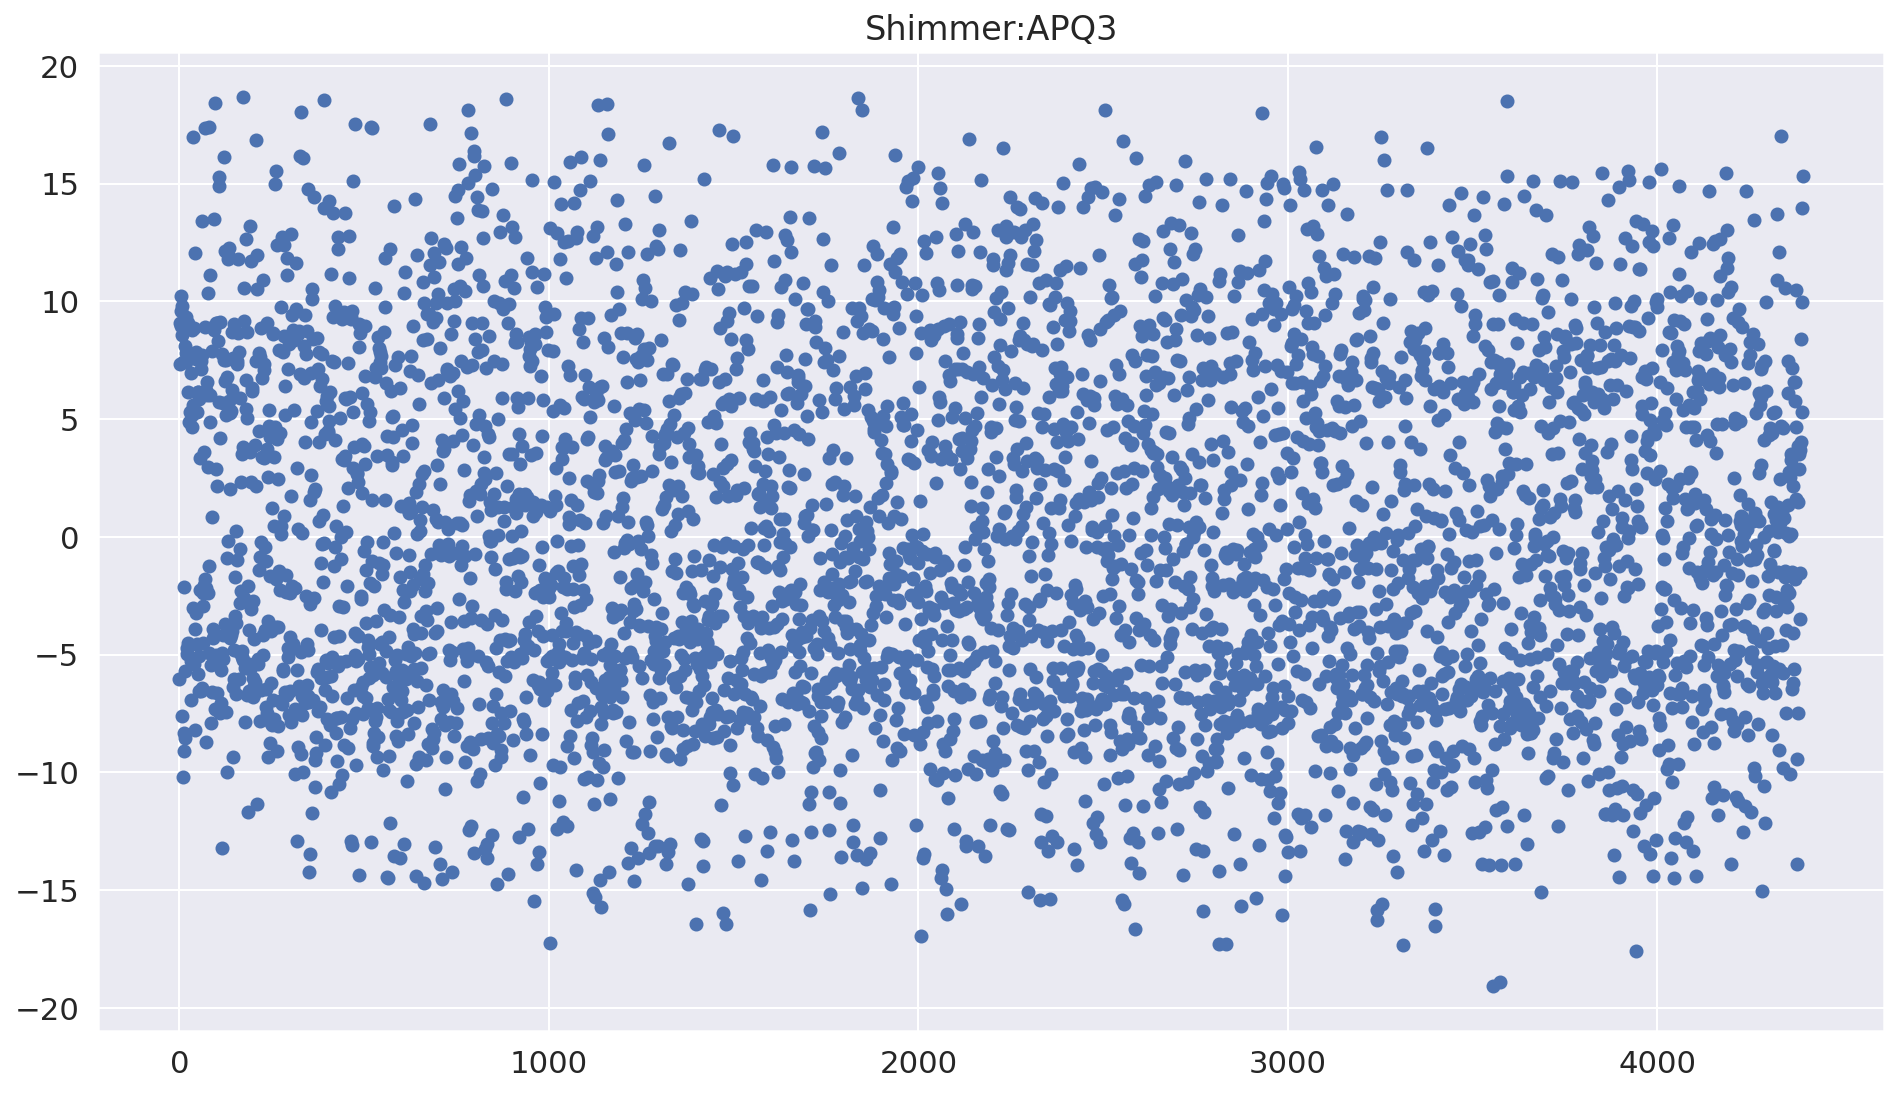

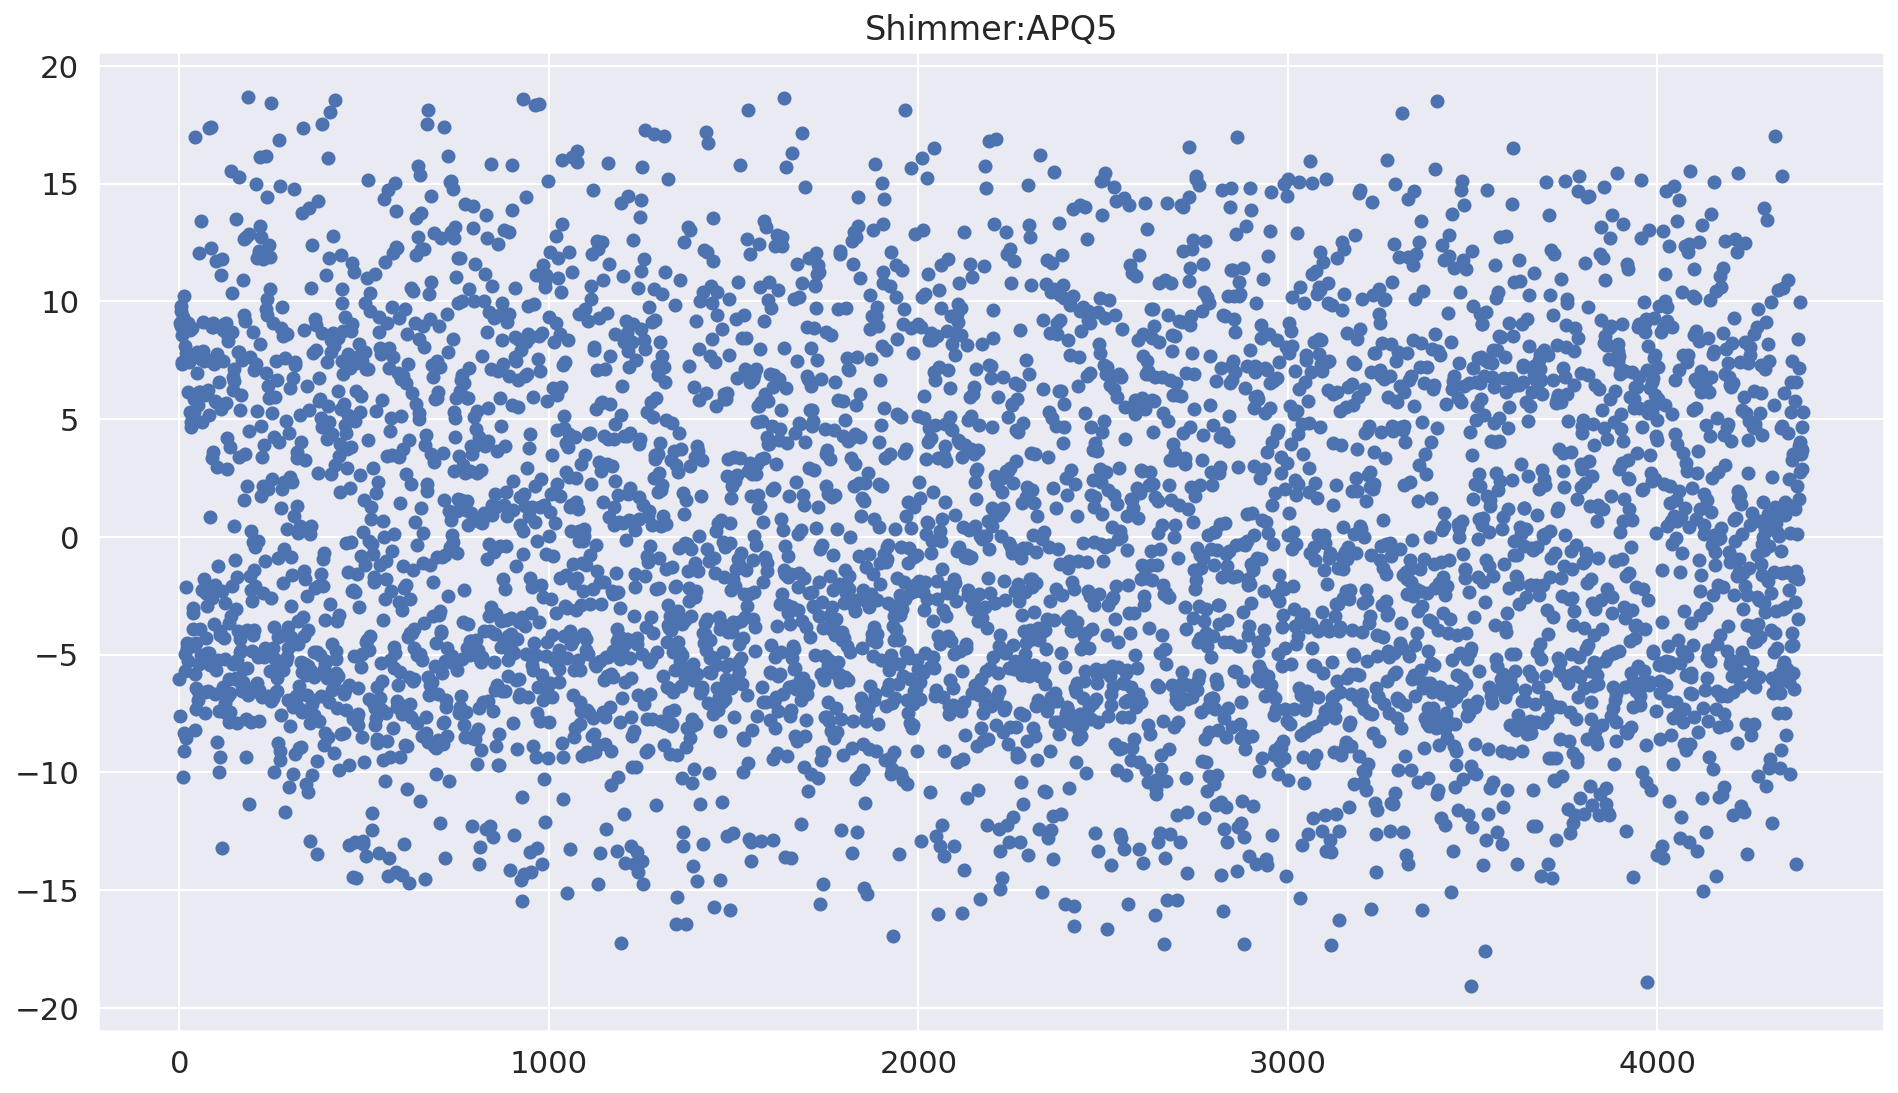

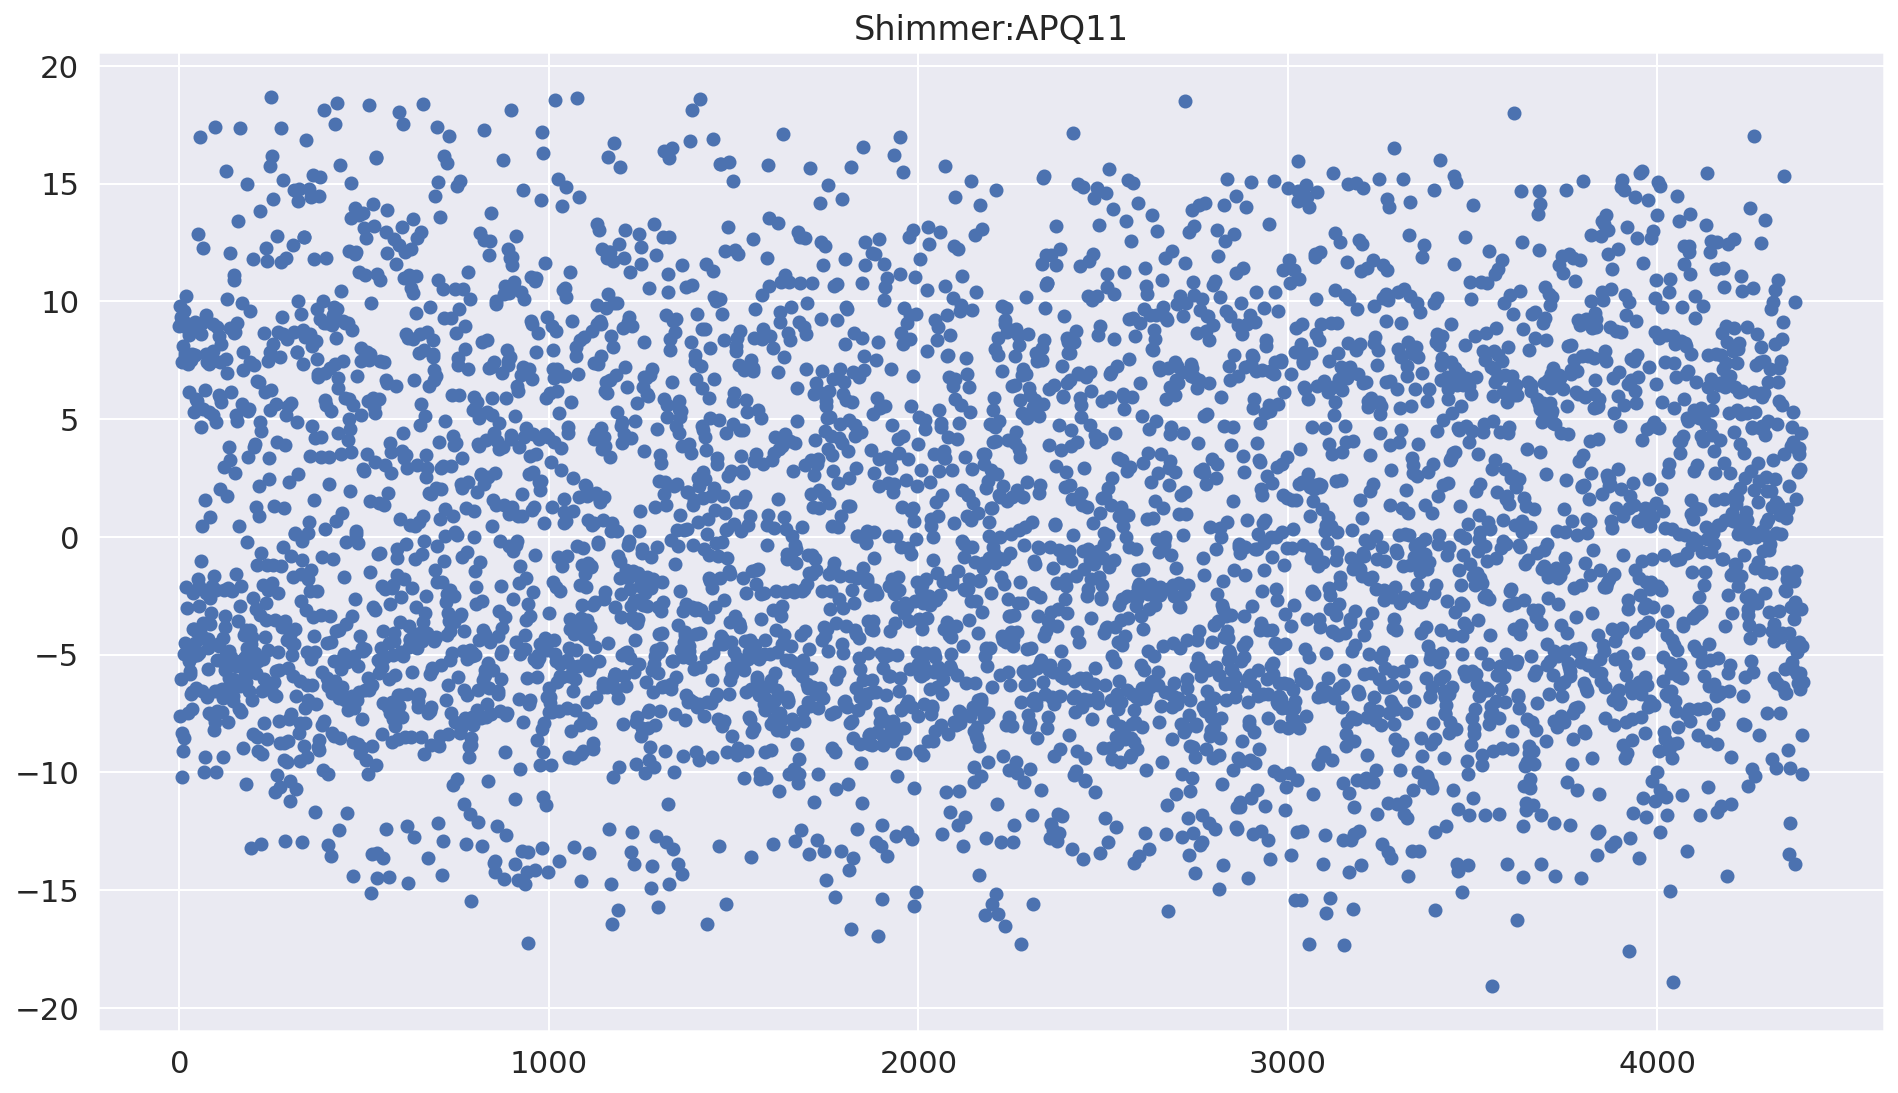

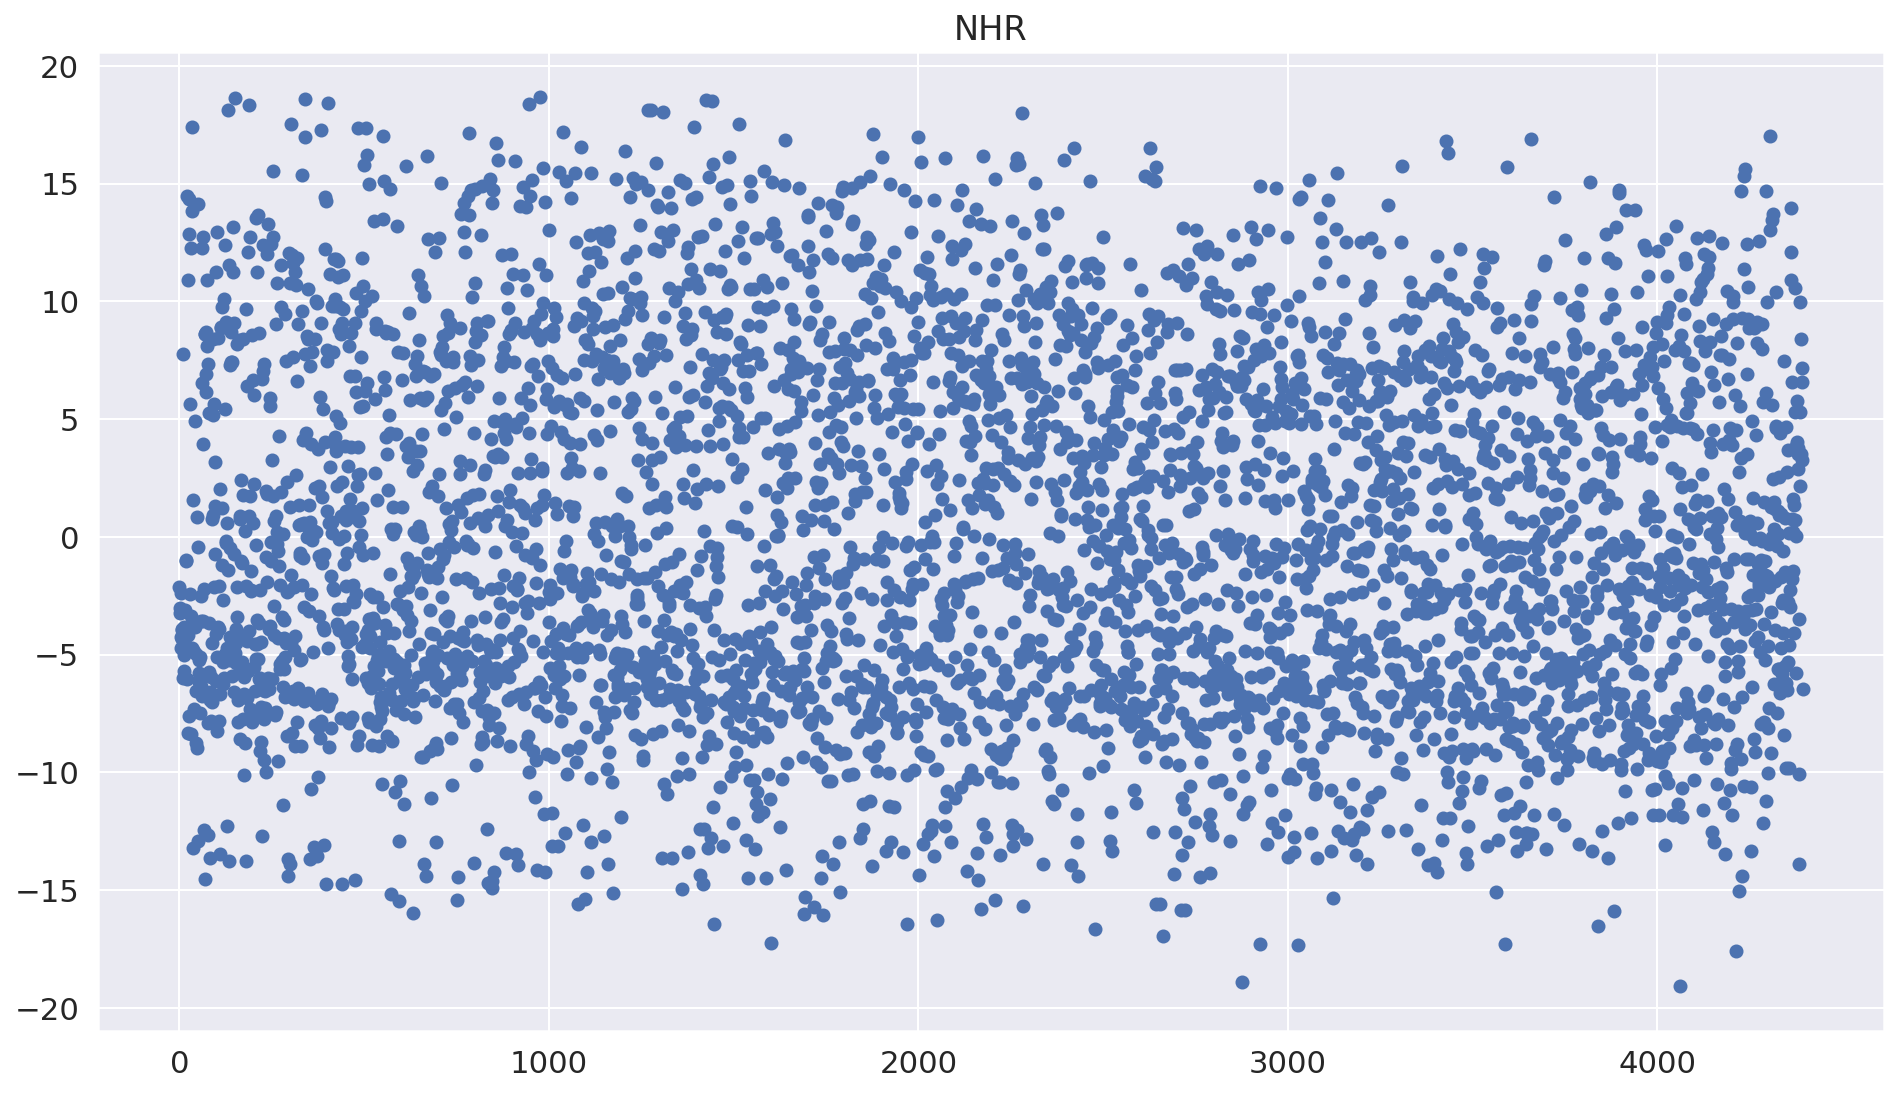

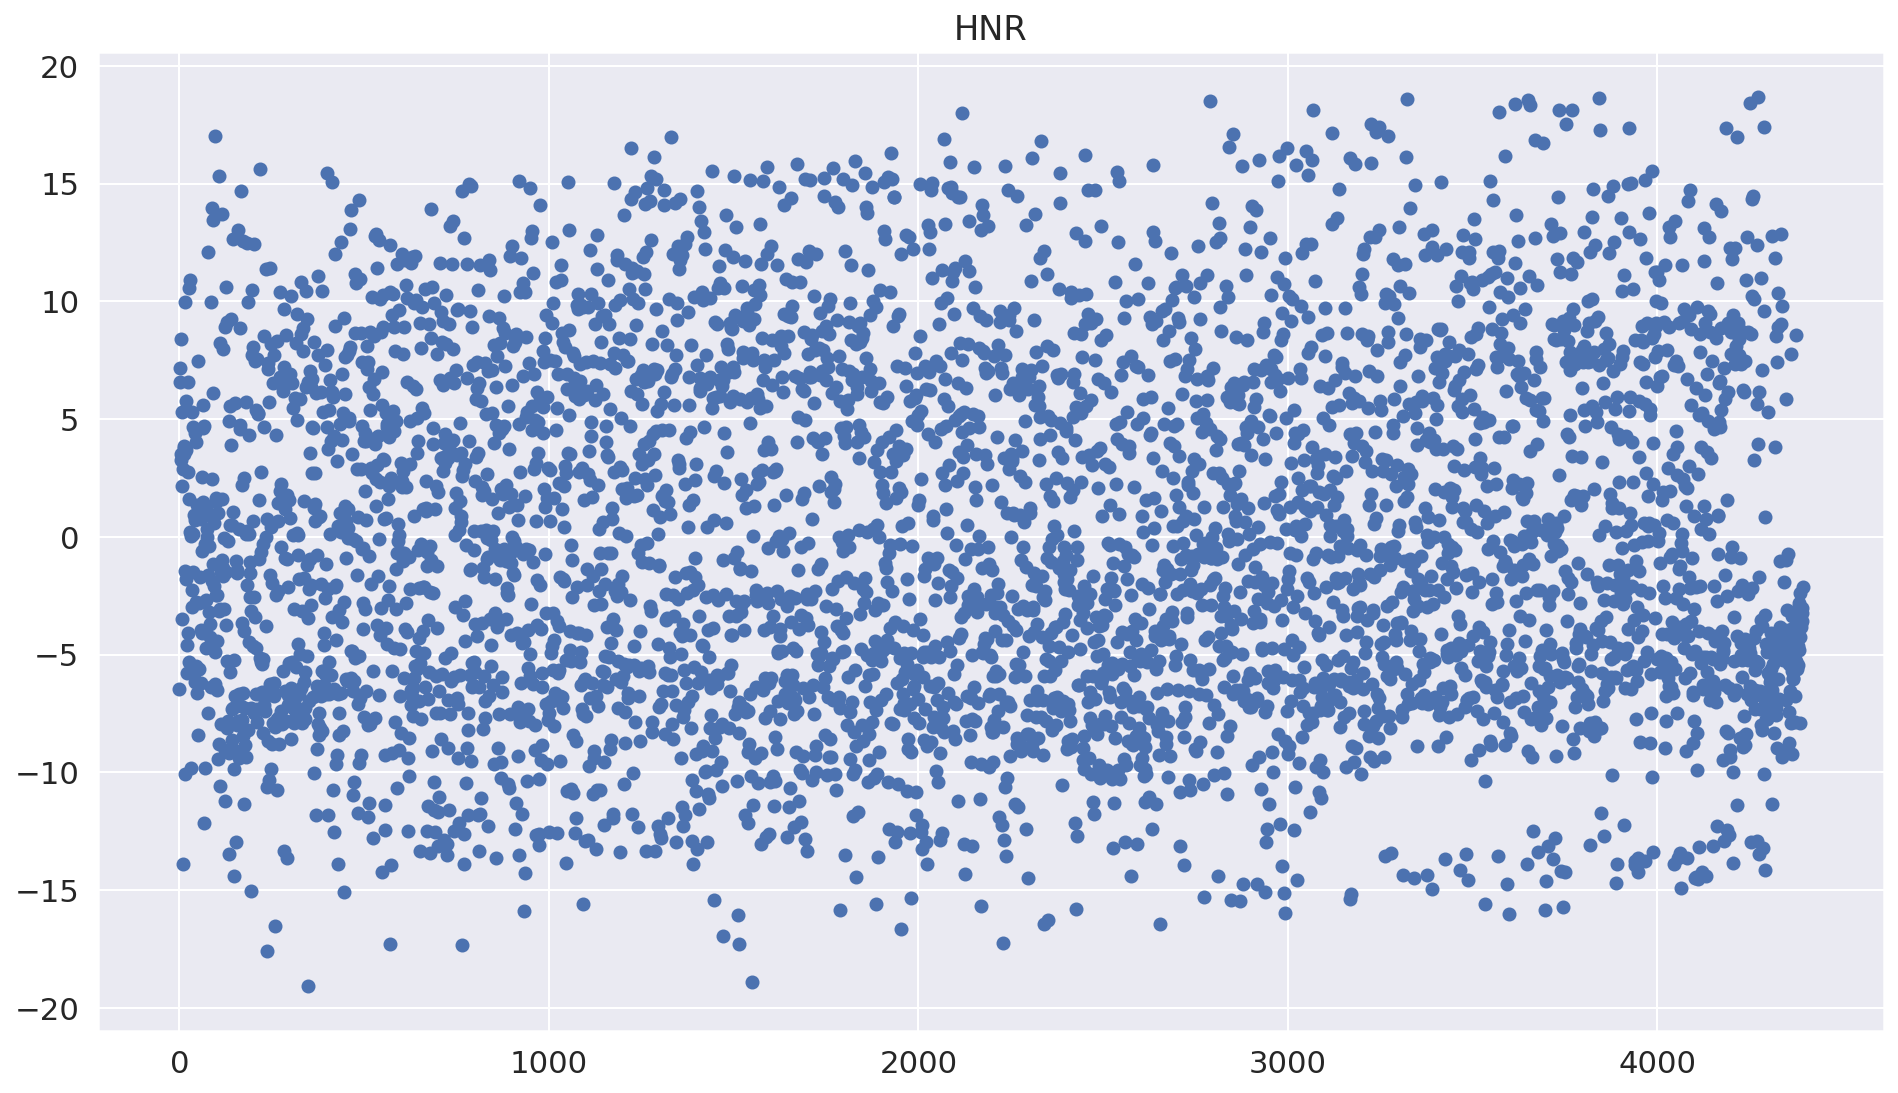

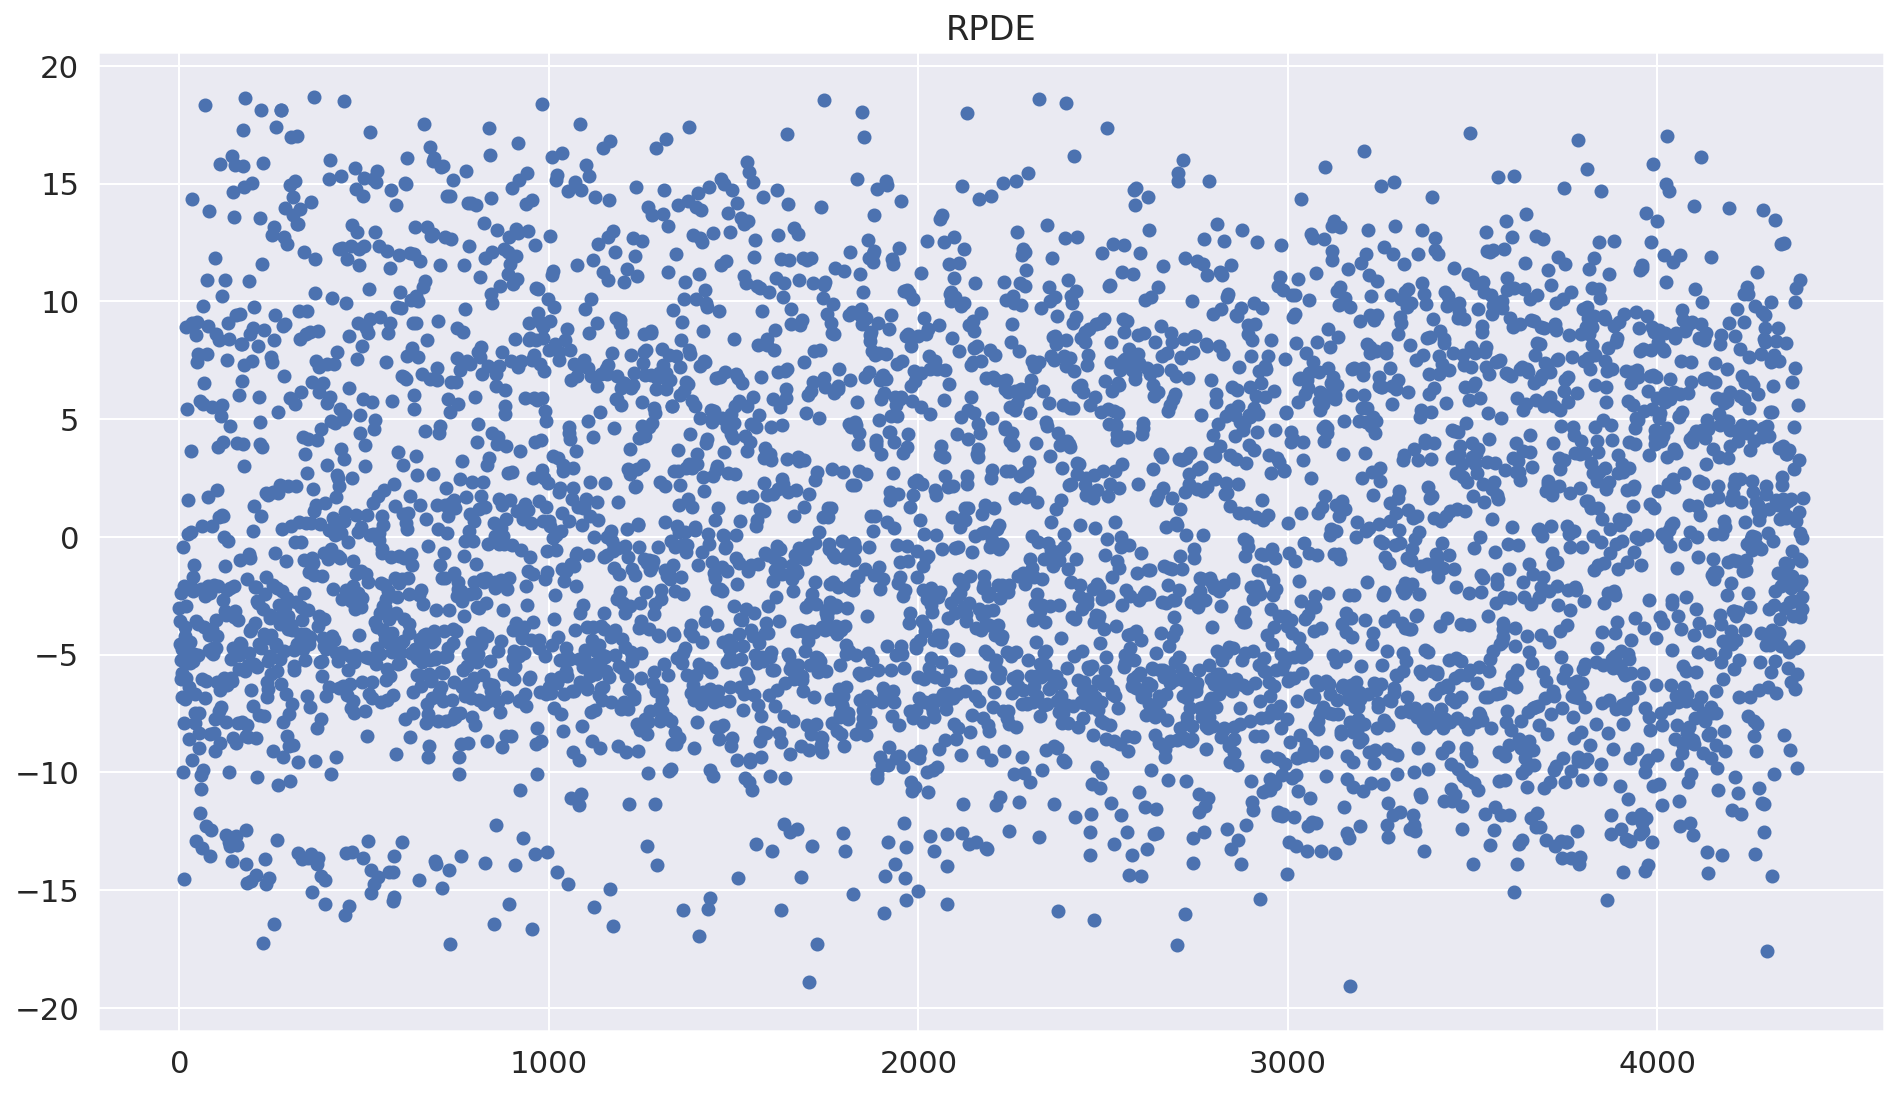

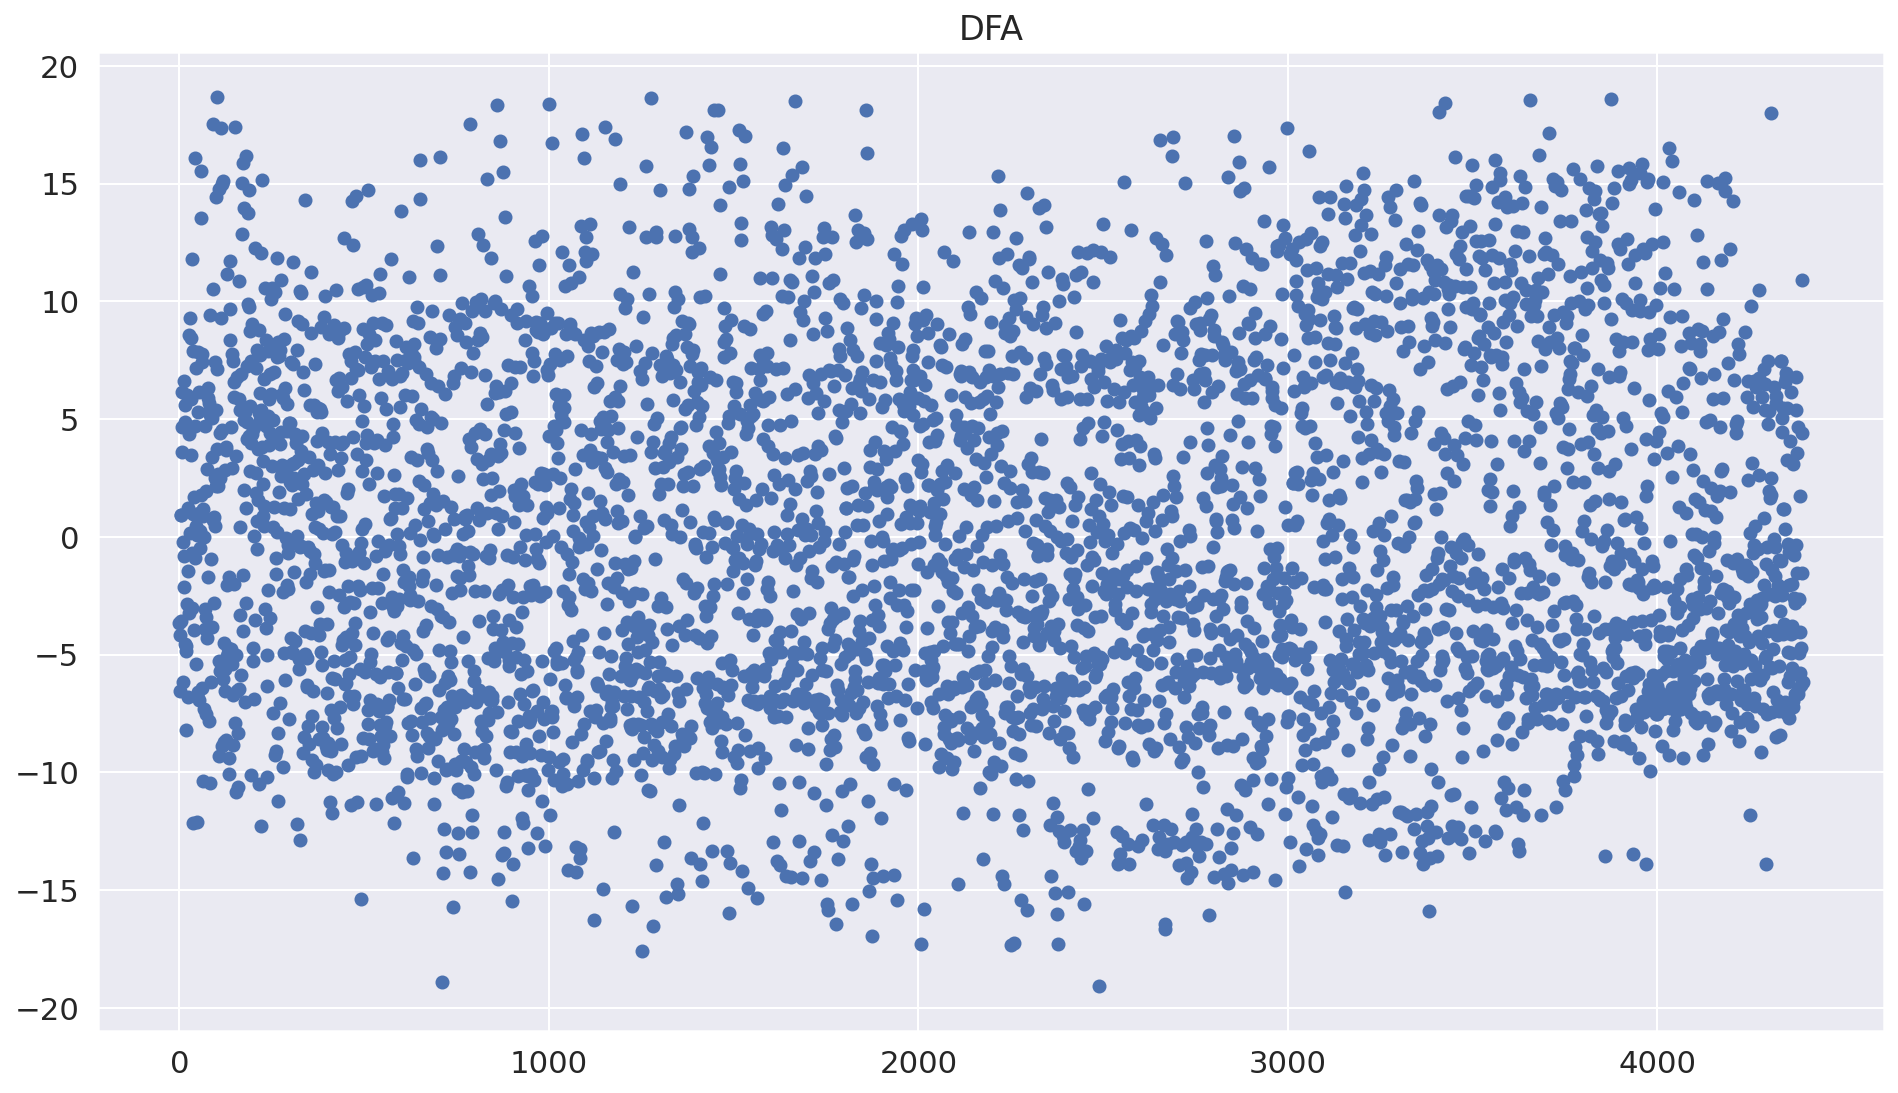

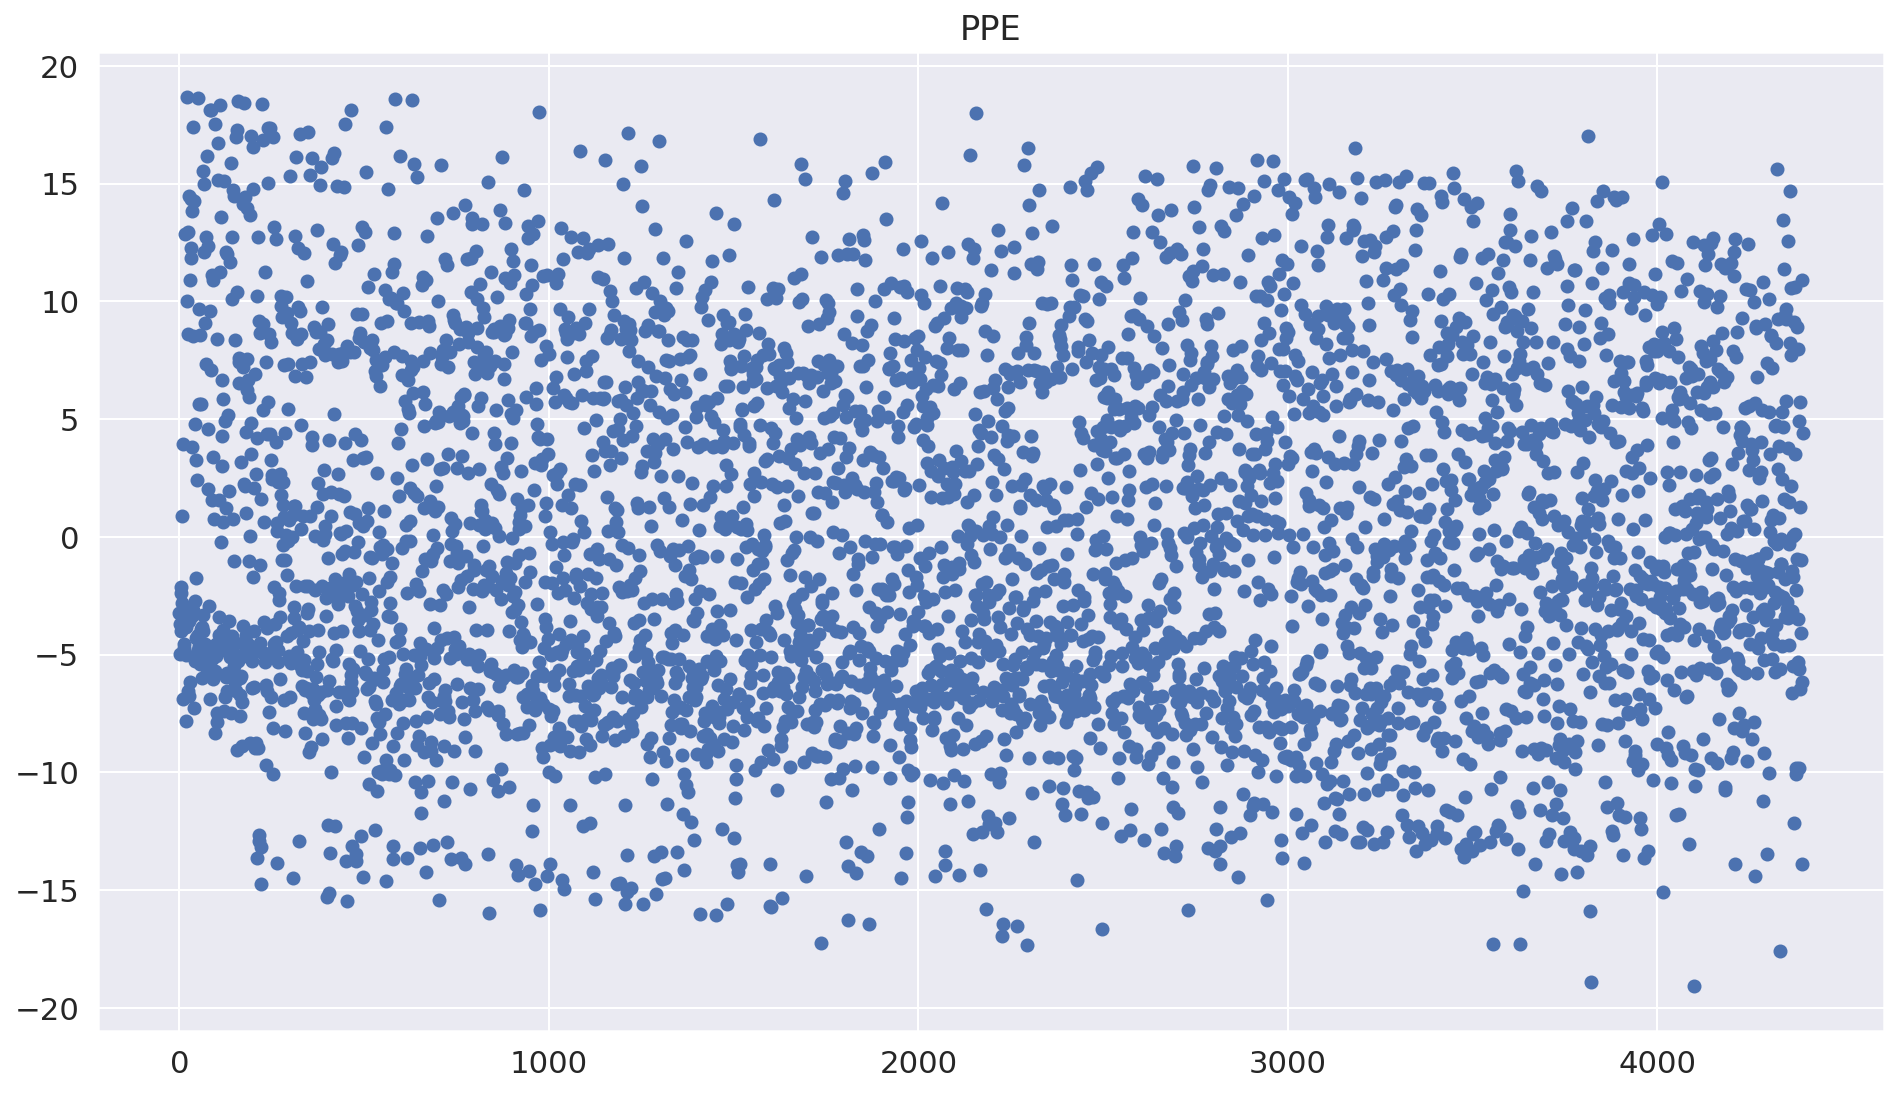

In [124]:
for i in range(X_mod.shape[1]):
    plt.figure(figsize = (16, 9))
    plt.plot(err[X_mod.values[:, i].argsort()], 'o')
    plt.title(X_mod.columns[i])

Есть тренд по признакам 'age' и 'sex', но очевидно, что это наследованные признаки от id объекта. 

Попробуем порегуляризовать.

In [125]:
parameters = {'Model__alpha': np.append(np.arange(0.2, 1000, 2), np.logspace(-6, -3, 4))}
model = make_basic_pipeline(Ridge(fit_intercept=True)) 
r2, cv = train_and_test_cv(model, parameters, "Ridge", X, y_mot, True)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))

Best parameters: {'Model__alpha': 998.2}
R^2 score  --  0.13816689770855417
cv score  --  -75.87106044228256
R^2 fixed --  0.13442322396746198


In [126]:
parameters = {'Model__alpha': np.append(np.arange(0.01, 3, 0.01), np.logspace(-6, -3, 4))}
model = make_basic_pipeline(Lasso(fit_intercept=True)) 
r2, cv = train_and_test_cv(model, parameters, "Lasso", X, y_mot, True)
print(f"R^2 fixed -- ", 1 - (1 - r2) * (X.shape[0] - 1) / (X.shape[0] - X.shape[1] - 1))

Best parameters: {'Model__alpha': 0.77}
R^2 score  --  0.08459329534538562
cv score  --  -78.10953480610986
R^2 fixed --  0.08061690591044335


Как видим, если не перекодировать id, все получается совсем печально.

### Задача 5

In [127]:
all_data = pd.read_csv('data/msps-2018-hw9-5/hw9t5_train.csv')

In [128]:
all_data

id sex            region school  PhD  average grades       english  \
0      0   f            Moscow  other    0            3.50      advanced   
1      1   m            Moscow      2    1            4.76      advanced   
2      2   m  Krasnodar region    NaN    0            4.22  intermediate   
3      3   m            Moscow  other    0            3.34      beginner   
4      4   m     Bashkortostan    NaN    0            4.31  intermediate   
..   ...  ..               ...    ...  ...             ...           ...   
995  995   m            Moscow     57    0            4.51  intermediate   
996  996   m             other    NaN    0            4.02  intermediate   
997  997   m            Moscow  other    0            4.49      advanced   
998  998   m             other    NaN    1            4.64      beginner   
999  999   m             other    NaN    1            4.96  intermediate   

     child  experience  alcohol  height  salary_train  
0        1           6      173     173     1152216.0  
1        0           4       87     170     1010287.0  
2        1           6       71     181     1090723.0  
3        1           7      254     169           NaN  
4        0           4      215     189      878325.0  
..     ...         ...      ...     ...           ...  
995      3           6       40     169     1144126.0  
996      0           7       98     176     1110443.0  
997      0           4      290     177      936689.0  
998      1           3        7     180      917125.0  
999      1           3       99     171     1124637.0  

[1000 rows x 12 columns]

In [129]:
all_data.isna().any()

id                False
sex               False
region            False
school             True
PhD               False
average grades    False
english           False
child             False
experience        False
alcohol           False
height            False
salary_train       True
dtype: bool

In [130]:
all_data['salary_train'].dropna().values.mean()

1098358.3782722512

Взглянем на данные, чтобы понять, какую модель нам выбрать. Как можно понять из названия колонок, скорее всего от нас требуется оценить годовую зарплату исходя из уровня образования, предпочтению к алкоголю, физических характеристик, опыта и семейного положения.


К сожалению жизнь -- очень сложный процесс, и то, какая у тебя зарплата, очевидно зависит не только от данных факторов. Всегда есть фактор удачи, связей, работа может быть в различных сферах. Поэтому, с увереностью можно сказать, что в данных скорее всего присутсвует достаточно большое количество выбросов. За них мы хотим сильно  не очень сильно штрафовать нашу модель. При этом, очевидно мы хотим ловить разницу с тем, что ошибка маленькая, и ошибка средняя или чуть больше, чем средняя. Взлянем на то, как себя ведут различные функции потерь различных робастных моделей и посмотрим, какие функции могут нам подойти. 

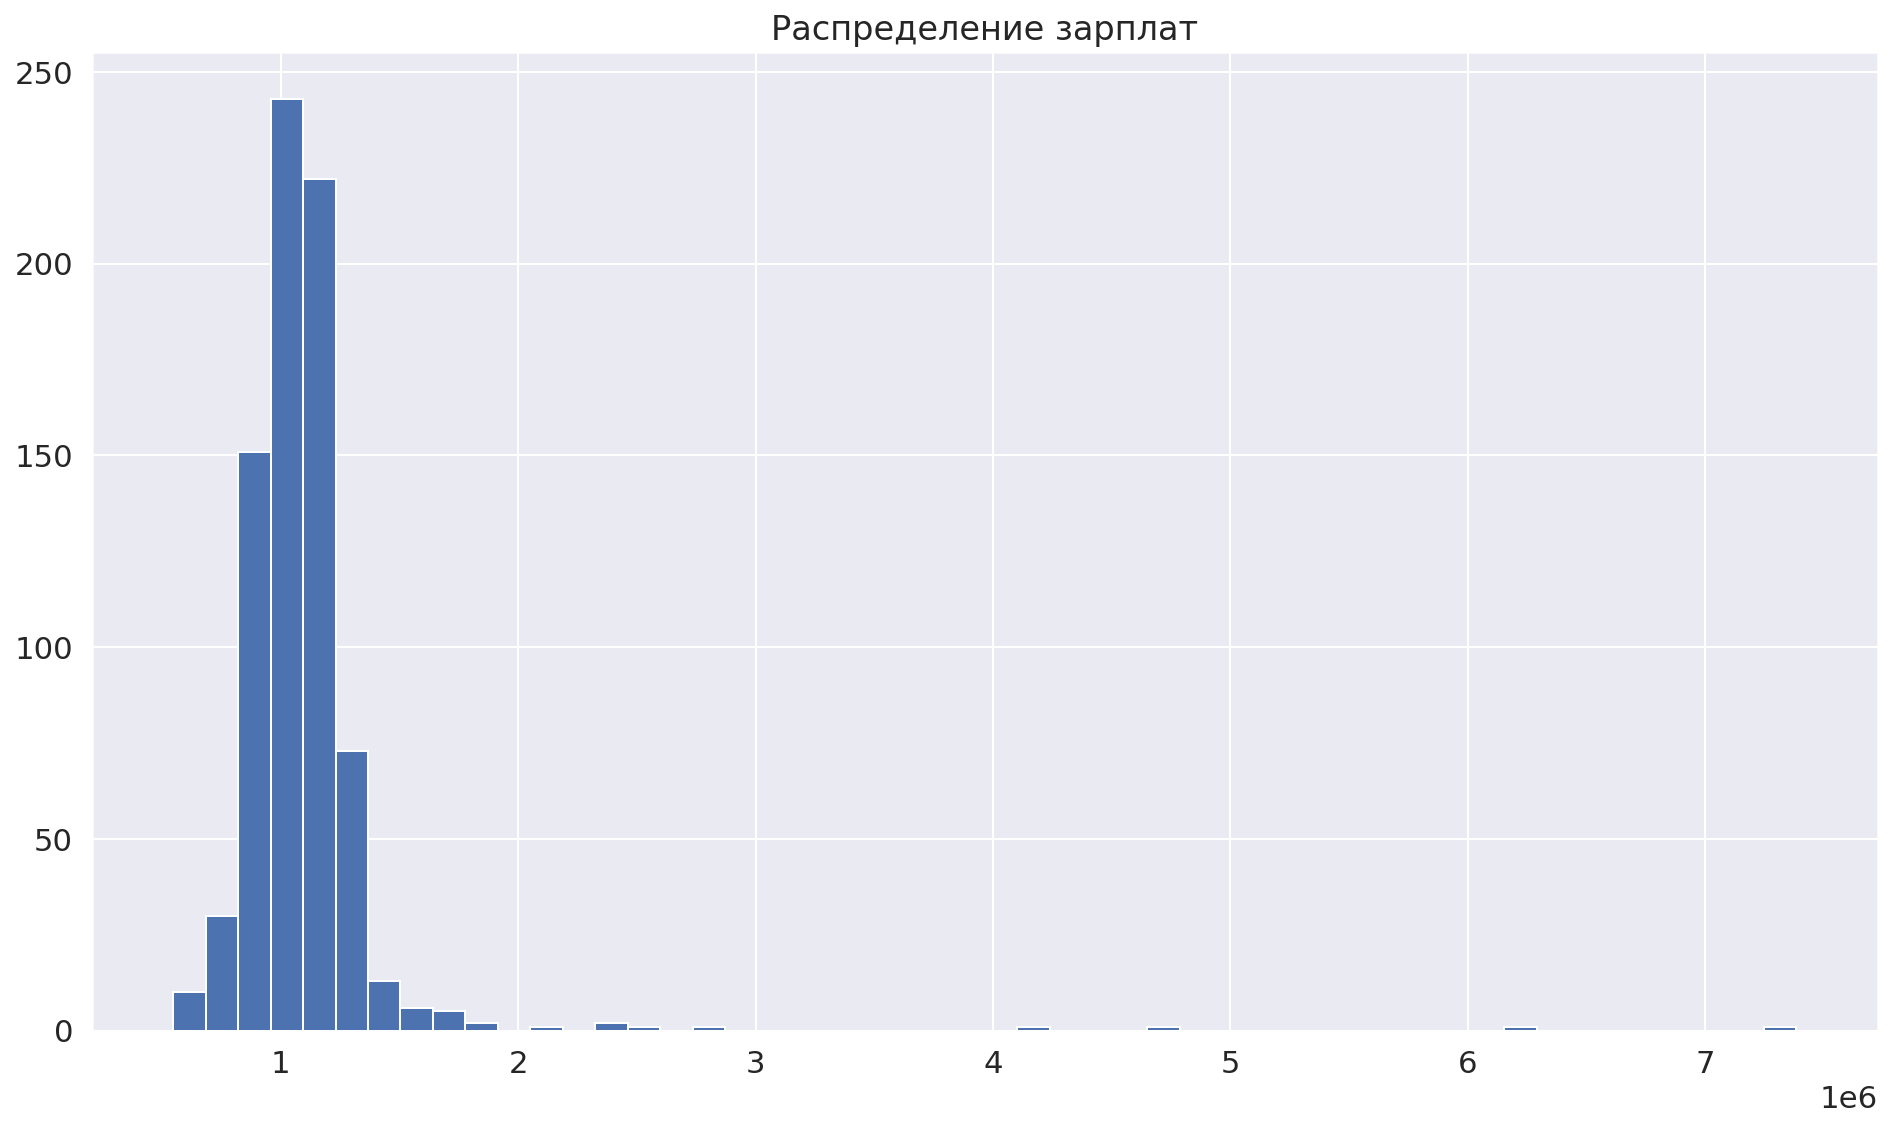

In [131]:
plt.figure(figsize = (16, 9))
plt.hist(all_data['salary_train'],bins = 50)
plt.title('Распределение зарплат')
plt.show()

In [132]:
import scipy
import scipy.special
import plotly.express as px

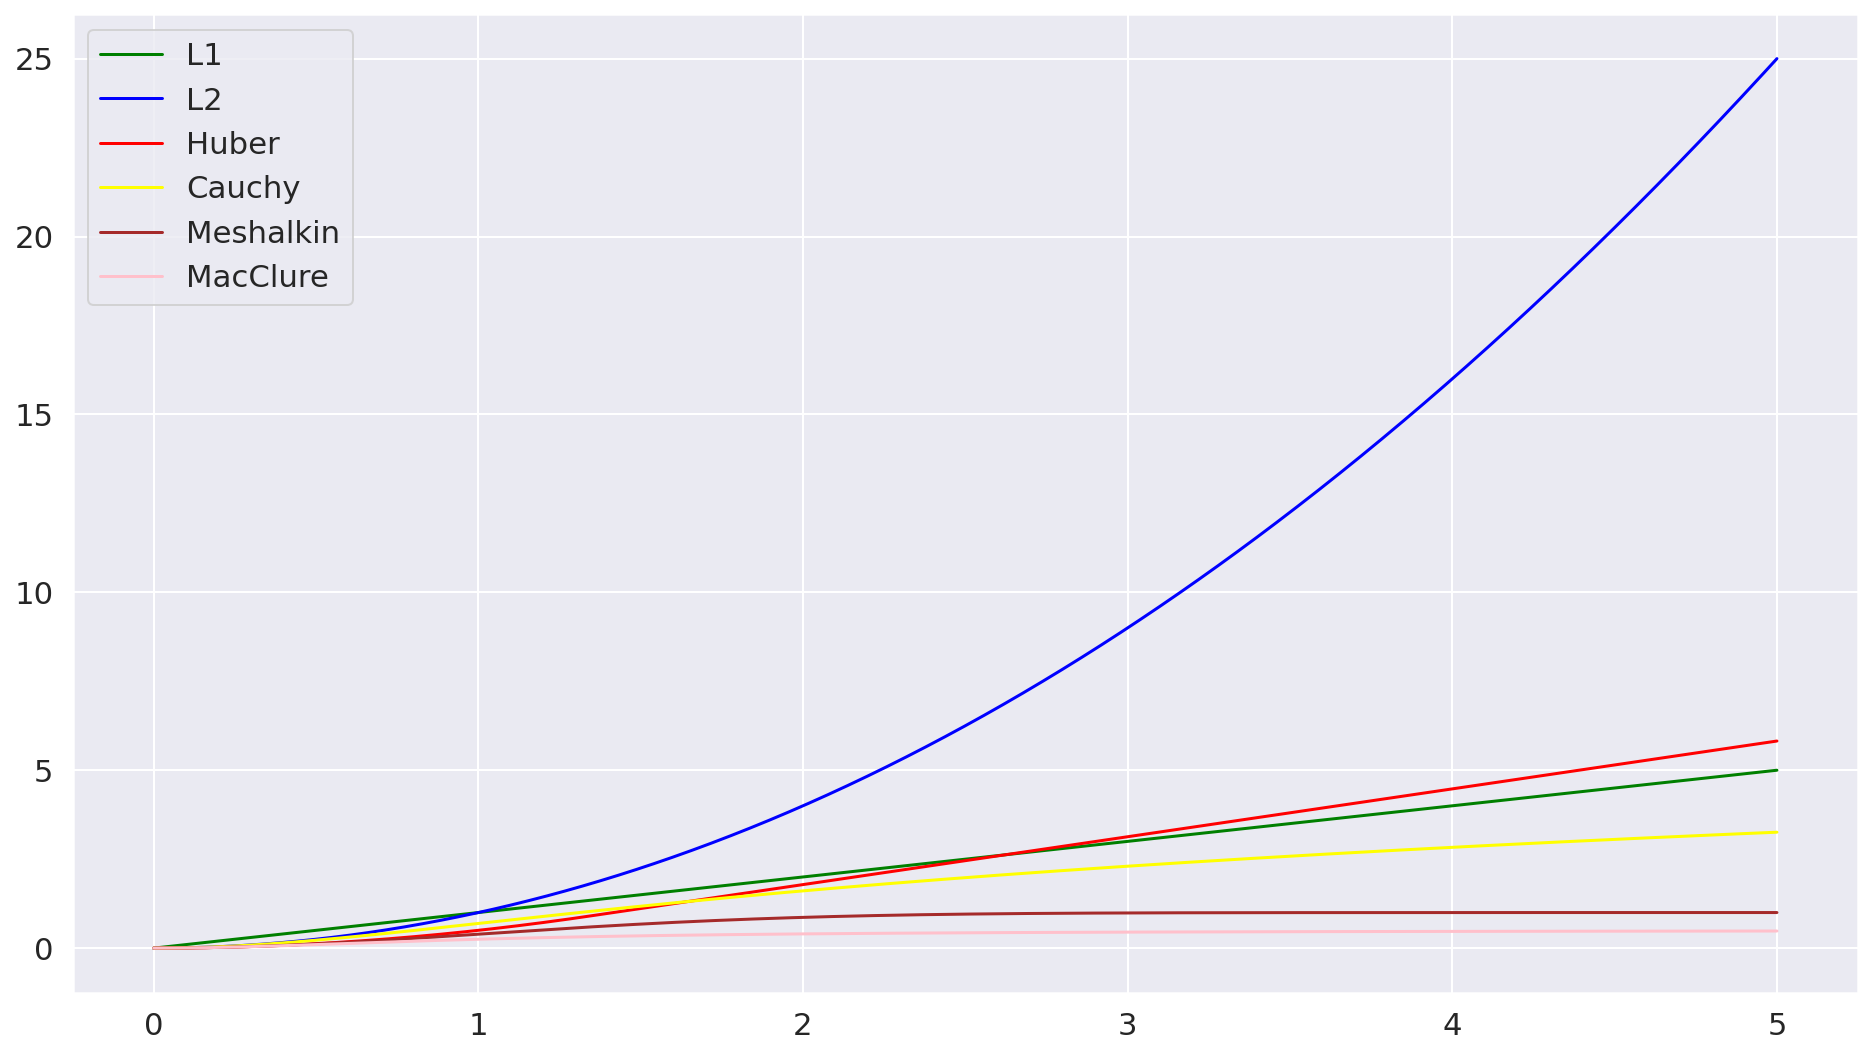

In [133]:
colors = ['green', 'blue', 'red', 'yellow', 'brown', 'pink']
labels = ['L1', 'L2', 'Huber', 'Cauchy', 'Meshalkin', 'MacClure']
grid = np.linspace(0, 5, 1000)
funcs = [lambda x: x, lambda x: x**2, lambda x: scipy.special.huber(1.345, x)
         , lambda x: np.log(1 + x**2), lambda x: 1 - np.exp((-1) * x ** 2 / 2), 
         lambda x: (x ** 2) / (2 * (1 + x**2))]
plt.figure(figsize= (16, 9))
for c, l, f in zip(colors, labels, funcs):
    plt.plot(grid, f(grid), label = l, color = c)
plt.legend()
plt.show()

L2 очень сильно начинает штрафовать, выкинем его и посмотрим еще раз:

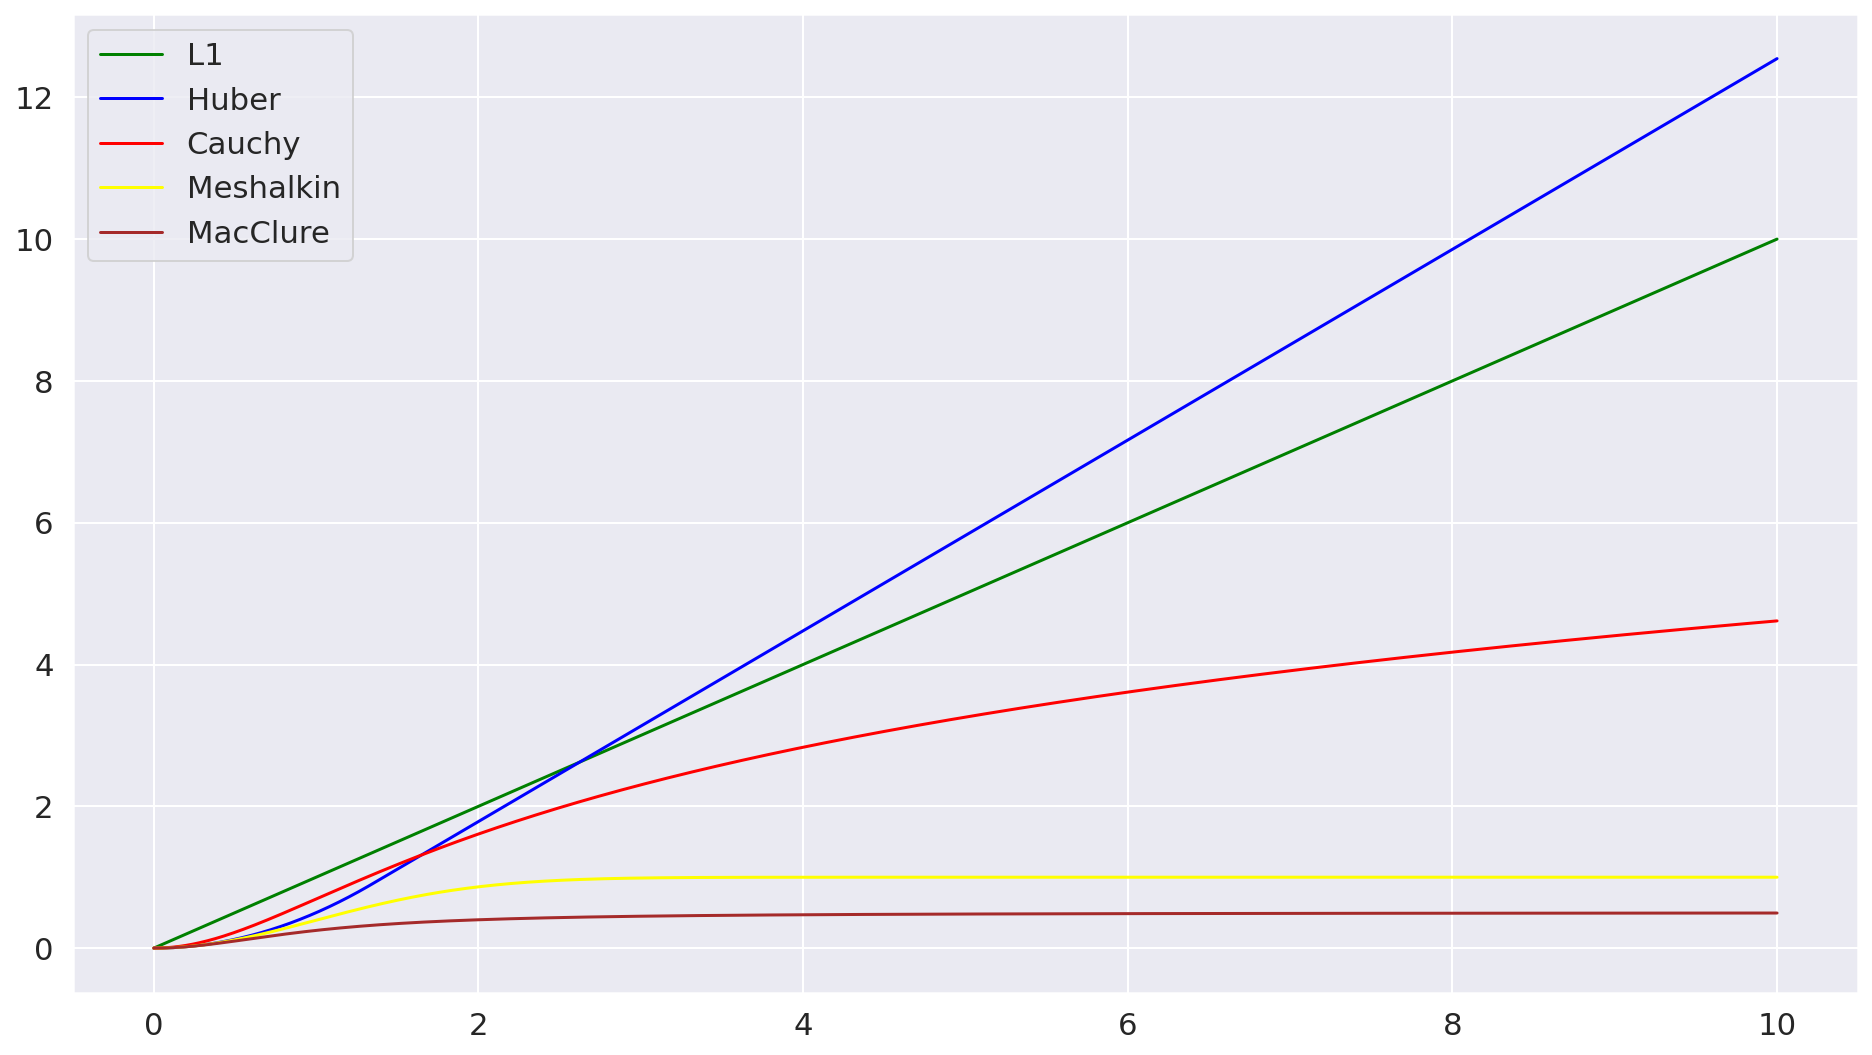

In [134]:
colors = ['green', 'blue', 'red', 'yellow', 'brown']
labels = ['L1', 'Huber', 'Cauchy', 'Meshalkin', 'MacClure']
grid = np.linspace(0, 10, 1000)
funcs = [lambda x: x, lambda x: scipy.special.huber(1.345, x)
         , lambda x: np.log(1 + x**2), lambda x: 1 - np.exp((-1) * x ** 2 / 2), 
         lambda x: (x ** 2) / (2 * (1 + x**2))]
plt.figure(figsize= (16, 9))
for c, l, f in zip(colors, labels, funcs):
    plt.plot(grid, f(grid), label = l, color = c)
plt.legend()
plt.show()


Как видим, L1 и Huber очень линейно растут, что плохо нам аукнется в выбросах. Функции потерь Мешалкина и  МакКлура с какого-то момента вообще перестают штрафовать, таким образом средняя ошибка будет плохо учитываться. А вот функция ошибок Коши кажется как раз то, что нужно. 

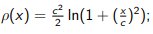

Вопрос в том, как выбрать подходящую константу. Ответ можно найти на самом деле просто, с помощью элементарных элементов математического анализа. Если внимательно присмотреться на график, то видно, что функция сначала выпукла вниз, а затем выпукла вверх. Понятное дело, что когда она становится вогнутой, мы начинаем штрафовать меньше. То есть, точка перегиба как раз и контролирует  момент, когда штрафовать нужно начать меньше. Найдем эту точку в явном виде через вторую производную:

$$
\frac{d^2}{dx^2} \big(\frac{c^2}{2} ln(1 + \big(\frac{x}{c}\big)^2)\big) = \frac{d}{dx} \big( \frac{c^2 x}{ c^2 + x^2}\big) = \frac{c^2 (c^2 - x^2)}{(c^2 + x^2)^2}
$$

Отсюда, точка перегиба -- $x = c$.

Будем считать, что если ошибка происходит в более чем 500 тысяч (чуть более 40 тысяч в месяц), то нужно уже штрафовать меньше.

Вспомним общую формулу регрессии:

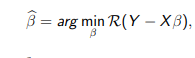

Нам нужно будет минимизировать, для этого будем использовать scipy.optimize.minimize.

Преобразуем нечисловые признаки. Из пола нужно сделать два категориальных признака. Для Региона и уровня английского языка можно снова сделать mean encoding. С признаком школы сложнее, в нем очень много пропусков. Возможно, стоит вообще удалить этот признак.

In [135]:
norm_data = all_data
norm_data['salary_train'] /= 1000
data_tr1 = mean_target_encoding(norm_data, 'salary_train', 'region')
data_tr2 = mean_target_encoding(data_tr1, 'salary_train', 'english')
one_hot = pd.get_dummies(data_tr2['sex'])
data_tr2 = data_tr2.drop(['sex', 'english', 'region', 'school'], axis = 1)
all_data_mod = data_tr2.join(one_hot)
all_data_mod['const'] = 1
all_data_mod

id  PhD  average grades  child  experience  alcohol  height  \
0      0    0            3.50      1           6      173     173   
1      1    1            4.76      0           4       87     170   
2      2    0            4.22      1           6       71     181   
3      3    0            3.34      1           7      254     169   
4      4    0            4.31      0           4      215     189   
..   ...  ...             ...    ...         ...      ...     ...   
995  995    0            4.51      3           6       40     169   
996  996    0            4.02      0           7       98     176   
997  997    0            4.49      0           4      290     177   
998  998    1            4.64      1           3        7     180   
999  999    1            4.96      1           3       99     171   

     salary_train  region_m_enc  english_m_enc  f  m  const  
0        1152.216    996.781525    1141.570515  1  0      1  
1        1010.287    996.781525    1141.570515  0  1      1  
2        1090.723   1160.392111    1103.575492  0  1      1  
3             NaN    996.781525     881.898623  0  1      1  
4         878.325   1130.773100    1103.575492  0  1      1  
..            ...           ...            ... .. ..    ...  
995      1144.126    996.781525    1103.575492  0  1      1  
996      1110.443   1122.400734    1103.575492  0  1      1  
997       936.689    996.781525    1141.570515  0  1      1  
998       917.125   1122.400734     881.898623  0  1      1  
999      1124.637   1122.400734    1103.575492  0  1      1  

[1000 rows x 13 columns]

In [136]:
data = all_data_mod.dropna()
X, y = data.drop(['salary_train'], axis = 1), data['salary_train']

In [137]:
X

id  PhD  average grades  child  experience  alcohol  height  \
0      0    0            3.50      1           6      173     173   
1      1    1            4.76      0           4       87     170   
2      2    0            4.22      1           6       71     181   
4      4    0            4.31      0           4      215     189   
5      5    0            3.85      2           7      113     165   
..   ...  ...             ...    ...         ...      ...     ...   
995  995    0            4.51      3           6       40     169   
996  996    0            4.02      0           7       98     176   
997  997    0            4.49      0           4      290     177   
998  998    1            4.64      1           3        7     180   
999  999    1            4.96      1           3       99     171   

     region_m_enc  english_m_enc  f  m  const  
0      996.781525    1141.570515  1  0      1  
1      996.781525    1141.570515  0  1      1  
2     1160.392111    1103.575492  0  1      1  
4     1130.773100    1103.575492  0  1      1  
5     1204.403587    1103.575492  0  1      1  
..            ...            ... .. ..    ...  
995    996.781525    1103.575492  0  1      1  
996   1122.400734    1103.575492  0  1      1  
997    996.781525    1141.570515  0  1      1  
998   1122.400734     881.898623  0  1      1  
999   1122.400734    1103.575492  0  1      1  

[764 rows x 12 columns]

In [138]:
y.mean

<bound method NDFrame._add_numeric_operations.<locals>.mean of 0      1152.216
1      1010.287
2      1090.723
4       878.325
5      1365.288
         ...   
995    1144.126
996    1110.443
997     936.689
998     917.125
999    1124.637
Name: salary_train, Length: 764, dtype: float64>

In [139]:
c = 500
def func_to_minimize(x):
    return (c / 2) * np.sum(np.log(1 + np.power((X @ x.T - y.values) / c, 2)))

In [140]:
min_k = minimize(func_to_minimize, np.ones(12), method='Nelder-Mead')

In [141]:
min_k.x

array([-2.58906091e-02, -2.11000506e+01, -7.42237174e+00,  8.07137280e+01,
        7.05900424e+00, -5.08172621e-02,  3.97863083e-01,  4.71379923e-01,
        4.32502440e-01, -7.73303711e+00, -4.17174742e+01,  1.94890553e+01])

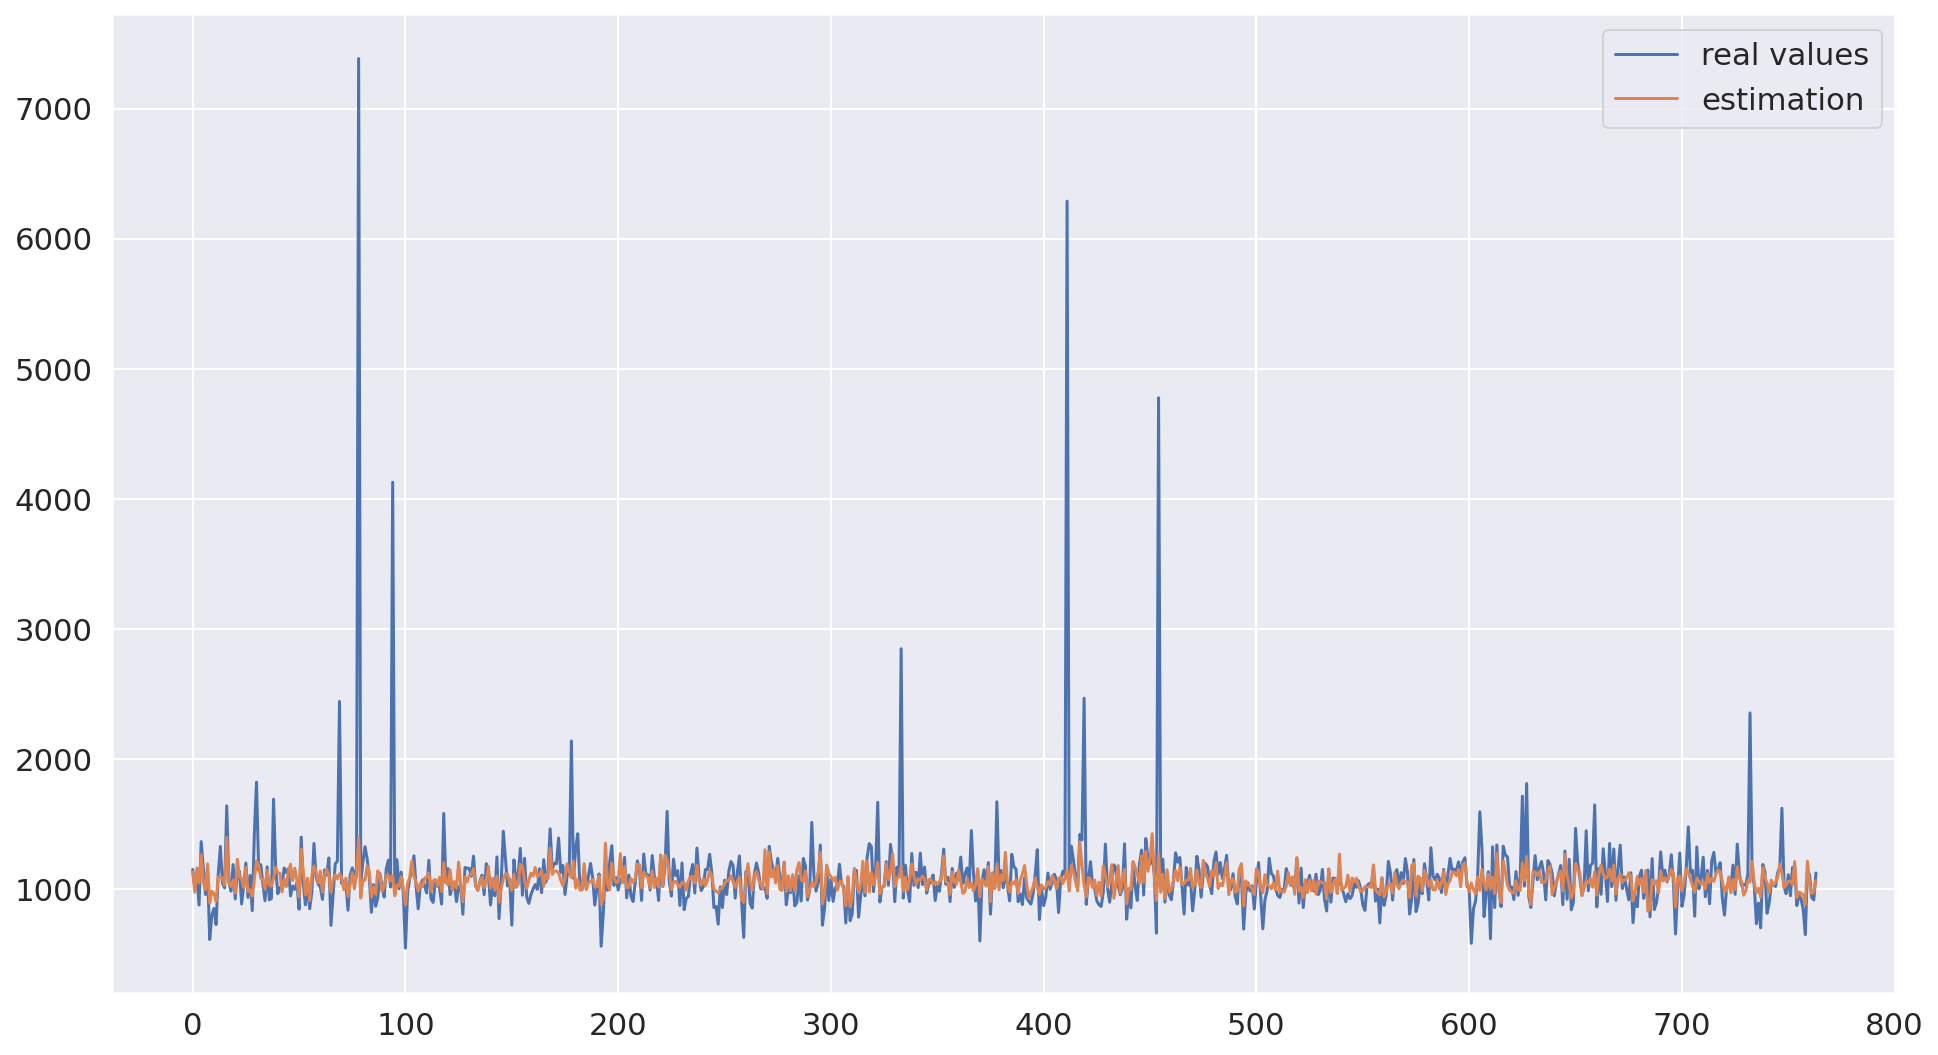

In [142]:
plt.figure(figsize = (16, 9))
plt.plot(np.arange(len(y)), y.values, label = 'real values')
plt.plot(np.arange(len(y)),np.sum(X * min_k.x, axis = 1), label = 'estimation')
plt.legend()
plt.show()

Кажется, есть что-то похожее на правду. Посмотрим на график разностей реальных значений и оценок при лимите [-200, 200]. Если большинство значений лежит там, то модель получилась адекватной. 

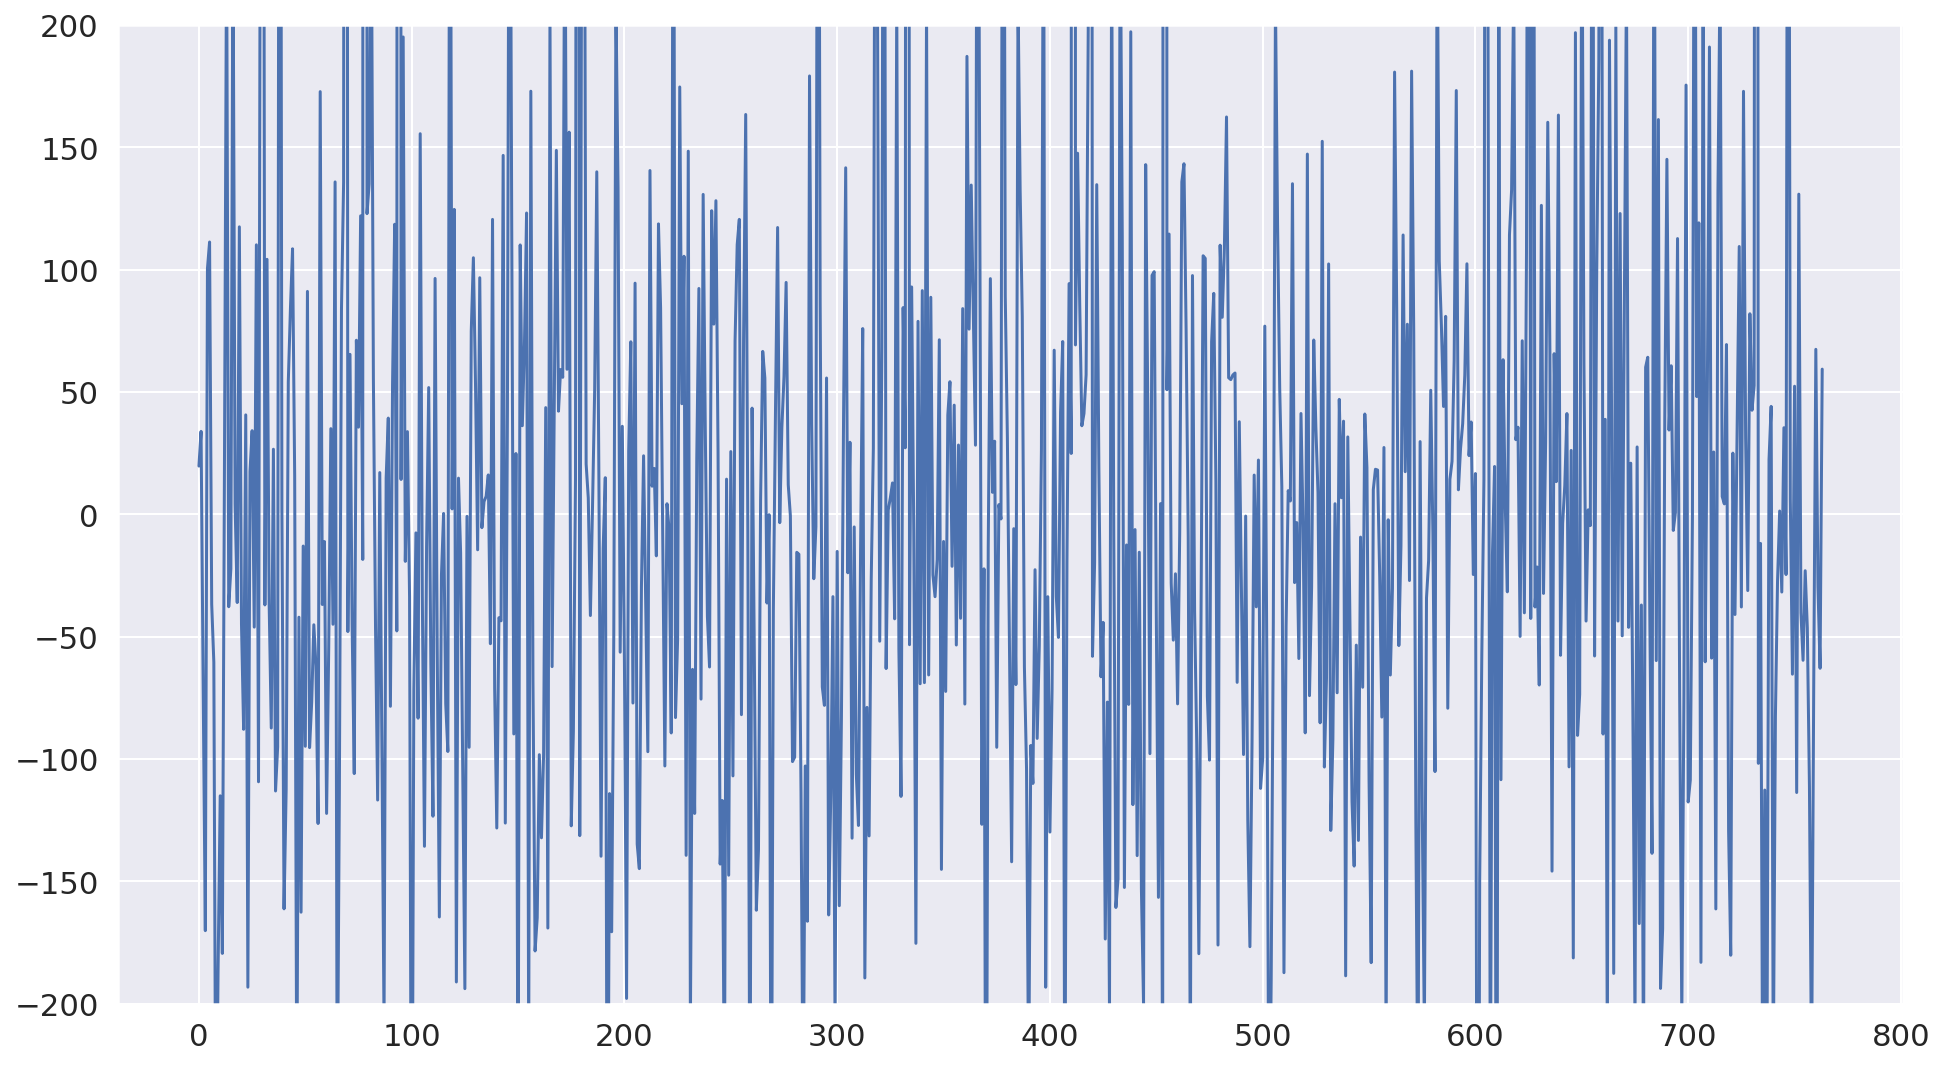

In [143]:
plt.figure(figsize = (16, 9))
plt.plot(np.arange(len(y)), y.values - np.sum(X * min_k.x, axis = 1))
plt.ylim(-200, 200)
plt.show()

Кажется, что большинство значений как раз и лежит в заданном интервале. 

Осталось ответить на вопросы о том, а можно ли использовать критерий Фишера и информационные для отбора признаков. Если брать ту же формулу для RSS, что и была, то использовать критерий Фишера точно нельзя, так как тогда понятно, что при использовании другой модели $\beta \neq (X^TX)^-1X^Ty$ и тем самым он уже не будет распределен как $\chi_2(n - k - 1)$. С информационными критериями не очень понятно, так как это просто численные значения. 

Интереснее будет рассмотреть случай, если брать RSS = $\sum_1^{n} {p(y - \hat y)}$,  где $p$ -- функция, которую мы используем в робастной модели. С критерием Фишера также вряд-ли что-то получится, так как непонятно, где возьмется сумма квадратов нормальных распределений. А вот с информационными критериями уже станет несколько лучше, так как RSS это как раз и есть loss, а кроме него информационные критерии опираются на количество элементов и количество признаков.

In [144]:
all_X

age  sex  test_time  Jitter(%)  Jitter(Abs)  Jitter:RAP  Jitter:PPQ5  \
0      72    0     5.6431    0.00662     0.000034     0.00401      0.00317   
1      72    0    12.6660    0.00300     0.000017     0.00132      0.00150   
2      72    0    19.6810    0.00481     0.000025     0.00205      0.00208   
3      72    0    25.6470    0.00528     0.000027     0.00191      0.00264   
4      72    0    33.6420    0.00335     0.000020     0.00093      0.00130   
...   ...  ...        ...        ...          ...         ...          ...   
5870   61    0   142.7900    0.00406     0.000031     0.00167      0.00168   
5871   61    0   149.8400    0.00297     0.000025     0.00119      0.00147   
5872   61    0   156.8200    0.00349     0.000025     0.00152      0.00187   
5873   61    0   163.7300    0.00281     0.000020     0.00128      0.00151   
5874   61    0   170.7300    0.00282     0.000021     0.00135      0.00166   

      Jitter:DDP  Shimmer  Shimmer(dB)  ...  Shimmer:APQ11  Shimmer:DDA  \
0        0.01204  0.02565        0.230  ...        0.01662      0.04314   
1        0.00395  0.02024        0.179  ...        0.01689      0.02982   
2        0.00616  0.01675        0.181  ...        0.01458      0.02202   
3        0.00573  0.02309        0.327  ...        0.01963      0.03317   
4        0.00278  0.01703        0.176  ...        0.01819      0.02036   
...          ...      ...          ...  ...            ...          ...   
5870     0.00500  0.01896        0.160  ...        0.01549      0.02920   
5871     0.00358  0.02315        0.215  ...        0.01904      0.03157   
5872     0.00456  0.02499        0.244  ...        0.01877      0.04112   
5873     0.00383  0.01484        0.131  ...        0.01307      0.02078   
5874     0.00406  0.01907        0.171  ...        0.01470      0.02839   

           NHR     HNR     RPDE      DFA      PPE    id  \
0     0.014290  21.640  0.41888  0.54842  0.16006     1   
1     0.011112  27.183  0.43493  0.56477  0.10810     2   
2     0.020220  23.047  0.46222  0.54405  0.21014     3   
3     0.027837  24.445  0.48730  0.57794  0.33277     4   
4     0.011625  26.126  0.47188  0.56122  0.19361     5   
...        ...     ...      ...      ...      ...   ...   
5870  0.025137  22.369  0.64215  0.55314  0.21367  5871   
5871  0.011927  22.886  0.52598  0.56518  0.12621  5872   
5872  0.017701  25.065  0.47792  0.57888  0.14157  5873   
5873  0.007984  24.422  0.56865  0.56327  0.14204  5874   
5874  0.008172  23.259  0.58608  0.57077  0.15336  5875   

      subject_for_mot_m_enc  subject_for_tot_m_enc  
0                 31.926067              40.774542  
1                 31.926067              40.774542  
2                 31.926067              40.774542  
3                 31.926067              40.774542  
4                 31.926067              40.774542  
...                     ...                    ...  
5870              22.812655              33.154718  
5871              22.812655              33.154718  
5872              22.812655              33.154718  
5873              22.812655              33.154718  
5874              22.812655              33.154718  

[5875 rows x 22 columns]

In [145]:
all_X = all_data_mod.drop(['salary_train'], axis = 1)
results = np.sum(all_X * min_k.x, axis = 1) * 1000
res_fr = pd.DataFrame({'id' : all_X['id'].values, 'salary': results})
res_fr.to_csv("fifth_res.csv", index = False)